#  Analysis Part 3: Scan over the NN settings

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
import random
import pickle
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.cm as cm
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import plot_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

## 1. Define Path and Files

In [2]:
usenamein='10k'
nsamples=5000

useinputdata = 'data/madminer_wgamma_observables_'+usenamein+'.h5'
usesamplesdir = 'data/scan_'+usenamein+'/'
usemodelsdir = 'models/scan_'+usenamein+'/'
usesummaryfile = 'data/scan_'+usenamein+'/summary.npy'

## 2. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)

#augment train sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='train'
)

#augment test sample
x, theta, t_xz = sa.extract_samples_train_local(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
#    test_split=None,
    filename='test',
    switch_train_test_events=True
)


15:25  
15:25  ------------------------------------------------------------
15:25  |                                                          |
15:25  |  MadMiner v2018.11.09                                    |
15:25  |                                                          |
15:25  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:25  |                                                          |
15:25  ------------------------------------------------------------
15:25  
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25  Found 6 benchmarks:
15:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:25     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:25     morphing_basis_vector_3: CWL2 = 17.32, CPWL

## 3. Scan

### 3a) Define Settings

In [4]:
#Number of epochs
choices_epochs = [5,10,20,50,100]
choices_nhidden = [2,3,4,5,6,7]
choices_nneuron = [10,20,50,100,200]
choices_activation = ['tanh', 'sigmoid', 'relu']
choices_regularization = [None,1,0.1,0.01,0.001]
choices_lrinitial = [0.1,0.01,0.001,0.0001]
choices_lrratio = [1,10,100,1000] 
choices_trainer = ['adam', 'amsgrad', 'sgd']

### 3b) Scan over Settings

In [5]:
# read file
if os.path.isfile(usesummaryfile):
    summary=np.load(usesummaryfile)
else:
    summary=np.array([])
n0scan=len(summary)

#scan nscan possible settings
nscan=500
for iscan in range (n0scan,n0scan+nscan):
    #Output
    print ('Do Run Number ', iscan-n0scan , ' out of ', nscan)
    
    #choose settings randomly
    index_epochs=random.randint(0,len(choices_epochs)-1)
    index_nhidden=random.randint(0,len(choices_nhidden)-1)
    index_nneuron=random.randint(0,len(choices_nneuron)-1)
    index_activation=random.randint(0,len(choices_activation)-1)
    index_regularization=random.randint(0,len(choices_regularization)-1)
    index_lrinitial=random.randint(0,len(choices_lrinitial)-1)
    index_lrratio=random.randint(0,len(choices_lrratio)-1)
    index_trainer=random.randint(0,len(choices_trainer)-1)

    this_nhidden = choices_nhidden[index_nhidden]
    this_nneuron = choices_nneuron[index_nneuron]
    this_lrinitial = choices_lrinitial[index_lrinitial]
    this_lrratio = choices_lrratio[index_lrratio]
    
    this_epochs = choices_epochs[index_epochs]
    this_hidden = tuple( [ this_nneuron for i in range(this_nhidden)] )
    this_activation = choices_activation[index_activation]
    this_regularization = choices_regularization[index_regularization]
    this_learning = ( this_lrinitial,this_lrinitial/this_lrratio )
    this_trainer = choices_trainer[index_trainer]
    
    #Setup/train/save ensemble
    forge = MLForge()
    if iscan==0:
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy',
            early_stopping=False,
            validation_split=None
        )   
    else: 
        forge.train(
            method='sally',
            x_filename=usesamplesdir+'x_train.npy',
            t_xz0_filename=usesamplesdir+'t_xz_train.npy',
            batch_size=128,
            early_stopping=False,
            validation_split=None,
            n_epochs=this_epochs,
            n_hidden=this_hidden,
            activation=this_activation,
            grad_x_regularization=this_regularization,
            initial_lr=this_learning[0],
            final_lr=this_learning[1],
            trainer=this_trainer
        )
    modelsavefile=usemodelsdir+'setup_{}/sally_test'.format(iscan)
    forge.save(modelsavefile)
    
    #Fisher Info 
    fisher = FisherInformation(useinputdata, debug=False)
    fi_mean , _ = fisher.calculate_fisher_information_full_detector(
        theta=[0.,0.], luminosity=300*1000.,return_error=True,
        model_file=modelsavefile,
        unweighted_x_sample_file=usesamplesdir+'x_test.npy'
    )
    
    #Scores and MSE
    t_pl_test=np.load(usesamplesdir+'t_xz_test.npy')
    t_ml_test=forge.evaluate(usesamplesdir+'x_test.npy')
    t_mse = mean_squared_error(t_pl_test,t_ml_test)
    
    #Save everything
    newelement= [iscan,
                 index_epochs,index_nhidden,index_nneuron,index_activation,index_regularization,
                 index_lrinitial,index_lrratio,index_trainer,
                 np.linalg.det(fi_mean),
                 t_mse
                ]
#    summary.append(newelement)
    if len(summary)==0:
        summary= [newelement]
    else:
        summary = np.append(summary, [newelement],axis=0) 
    
#Save 
np.save(usesummaryfile,summary)

15:25  Starting training
15:25    Method:                 sally
15:25    Training data: x at data/scan_10k/x_train.npy
15:25                   t_xz (theta0) at  data/scan_10k/t_xz_train.npy
15:25    Features:               all
15:25    Method:                 sally
15:25    Hidden layers:          (100, 100)
15:25    Activation function:    tanh
15:25    Batch size:             128
15:25    Trainer:                amsgrad
15:25    Epochs:                 50
15:25    Learning rate:          0.001 initially, decaying to 0.0001
15:25    Validation split:       None
15:25    Early stopping:         False
15:25    Scale inputs:           True
15:25    Regularization:         None
15:25  Loading training data
15:25  Found 5000 samples with 2 parameters and 23 observables
15:25  Rescaling inputs
15:25  Creating model for method sally
15:25  Training model


Do Run Number  0  out of  500


15:25    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
15:25    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
15:25    Epoch 15: train loss 0.0008 (mse_score: 0.0008)
15:25    Epoch 20: train loss 0.0007 (mse_score: 0.0007)
15:25    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
15:25    Epoch 30: train loss 0.0006 (mse_score: 0.0006)
15:25    Epoch 35: train loss 0.0006 (mse_score: 0.0006)
15:25    Epoch 40: train loss 0.0006 (mse_score: 0.0006)
15:25    Epoch 45: train loss 0.0006 (mse_score: 0.0006)
15:25    Epoch 50: train loss 0.0006 (mse_score: 0.0006)
15:25  Finished training
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25  Found 6 benchmarks:
15:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:25     morphing_bas

Do Run Number  1  out of  500


15:25    Epoch 2: train loss 0.0344 (mse_score: 0.0235, l2_grad_x: 10.8534)
15:25    Epoch 4: train loss 0.0039 (mse_score: 0.0029, l2_grad_x: 0.9378)
15:25    Epoch 6: train loss 0.0023 (mse_score: 0.0021, l2_grad_x: 0.2053)
15:25    Epoch 8: train loss 0.0021 (mse_score: 0.0019, l2_grad_x: 0.1420)
15:25    Epoch 10: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.1242)
15:25    Epoch 12: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.1195)
15:25    Epoch 14: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.1137)
15:25    Epoch 16: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.1121)
15:25    Epoch 18: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.1129)
15:25    Epoch 20: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.1132)
15:25  Finished training
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal po

Do Run Number  2  out of  500


15:25    Epoch 1: train loss 0.0068 (mse_score: 0.0068, l2_grad_x: 0.0000)
15:25    Epoch 2: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:25    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0002)
15:25    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:25    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:25    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:25    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:25    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0008)
15:25    Epoch 9: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0008)
15:25    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
15:25  Finished training
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  3  out of  500


15:25    Epoch 1: train loss 140.2133 (mse_score: 137.0970, l2_grad_x: 31.1630)
15:25    Epoch 2: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
15:25    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:25    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 8: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:25    Epoch 9: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:25    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25  Finished training
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  4  out of  500


15:25    Epoch 1: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0003)
15:25    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0003)
15:25    Epoch 3: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 7: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25    Epoch 9: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0003)
15:25    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:25  Finished training
15:25  Loading data from data/madminer_wgamma_observables_10k.h5
15:25  Found 2 parameters:
15:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:25     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  5  out of  500


15:25    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:25    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:26    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:26    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:26    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:26    Epoch 50: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  6  out of  500


15:26    Epoch 10: train loss 0.0020 (mse_score: 0.0020)
15:26    Epoch 20: train loss 0.0015 (mse_score: 0.0015)
15:26    Epoch 30: train loss 0.0013 (mse_score: 0.0013)
15:26    Epoch 40: train loss 0.0012 (mse_score: 0.0012)
15:26    Epoch 50: train loss 0.0012 (mse_score: 0.0012)
15:26    Epoch 60: train loss 0.0011 (mse_score: 0.0011)
15:26    Epoch 70: train loss 0.0011 (mse_score: 0.0011)
15:26    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
15:26    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
15:26    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26  Found 6 benchmarks:
15:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:26     morphing_b

Do Run Number  7  out of  500


15:26    Epoch 2: train loss 0.0241 (mse_score: 0.0241)
15:26    Epoch 3: train loss 0.0241 (mse_score: 0.0241)
15:26    Epoch 4: train loss 0.0239 (mse_score: 0.0239)
15:26    Epoch 5: train loss 0.0241 (mse_score: 0.0241)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26  Found 6 benchmarks:
15:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:26     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:26     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:26     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:26     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:26  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  8  out of  500


15:26    Epoch 1: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:26    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:26    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:26    Epoch 6: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:26    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26    Epoch 9: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  9  out of  500


15:26    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:26    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:26    Epoch 6: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:26    Epoch 8: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:26    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:26    Epoch 12: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:26    Epoch 14: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:26    Epoch 16: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:26    Epoch 18: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:26    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  10  out of  500


15:26    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0020)
15:26    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0034)
15:26    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0042)
15:26    Epoch 20: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0041)
15:26    Epoch 25: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0042)
15:26    Epoch 30: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
15:26    Epoch 35: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
15:26    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
15:26    Epoch 45: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
15:26    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0045)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  11  out of  500


15:26    Epoch 2: train loss 0.0017 (mse_score: 0.0017)
15:26    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 8: train loss 0.0015 (mse_score: 0.0015)
15:26    Epoch 9: train loss 0.0015 (mse_score: 0.0015)
15:26    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26  Found 6 benchmarks:
15:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:26     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:26     morph

Do Run Number  12  out of  500


15:26    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
15:26    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26  Found 6 benchmarks:
15:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:26     morphing_bas

Do Run Number  13  out of  500


15:26    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:26    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 12: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 14: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 16: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 18: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:26    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
15:26  Finished training
15:26  Loading data from data/madminer_wgamma_observables_10k.h5
15:26  Found 2 parameters:
15:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:26     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  14  out of  500


15:27    Epoch 5: train loss 0.0122 (mse_score: 0.0108, l2_grad_x: 1.4523)
15:27    Epoch 10: train loss 0.0036 (mse_score: 0.0034, l2_grad_x: 0.1800)
15:27    Epoch 15: train loss 0.0022 (mse_score: 0.0021, l2_grad_x: 0.0989)
15:27    Epoch 20: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0722)
15:27    Epoch 25: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0645)
15:27    Epoch 30: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0592)
15:27    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0576)
15:27    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0589)
15:27    Epoch 45: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0556)
15:27    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0557)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  15  out of  500


15:27    Epoch 1: train loss 0.0096 (mse_score: 0.0070, l2_grad_x: 0.0258)
15:27    Epoch 2: train loss 0.0023 (mse_score: 0.0017, l2_grad_x: 0.0058)
15:27    Epoch 3: train loss 0.0017 (mse_score: 0.0015, l2_grad_x: 0.0024)
15:27    Epoch 4: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0019)
15:27    Epoch 5: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0017)
15:27    Epoch 6: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0015)
15:27    Epoch 7: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0015)
15:27    Epoch 8: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0014)
15:27    Epoch 9: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0013)
15:27    Epoch 10: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0013)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  16  out of  500


15:27    Epoch 2: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0005)
15:27    Epoch 4: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0005)
15:27    Epoch 6: train loss 0.0034 (mse_score: 0.0034, l2_grad_x: 0.0006)
15:27    Epoch 8: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0007)
15:27    Epoch 10: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0008)
15:27    Epoch 12: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0008)
15:27    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0009)
15:27    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0009)
15:27    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0009)
15:27    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0009)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  17  out of  500


15:27    Epoch 2: train loss 0.0290 (mse_score: 0.0277, l2_grad_x: 0.0014)
15:27    Epoch 3: train loss 0.0279 (mse_score: 0.0265, l2_grad_x: 0.0014)
15:27    Epoch 4: train loss 0.0276 (mse_score: 0.0263, l2_grad_x: 0.0013)
15:27    Epoch 5: train loss 0.0276 (mse_score: 0.0262, l2_grad_x: 0.0013)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27  Found 6 benchmarks:
15:27     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:27     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:27     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:27     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:27     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:27     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:27  Found 23 observa

Do Run Number  18  out of  500


15:27    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  19  out of  500


15:27    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:27    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0012)
15:27    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
15:27    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0024)
15:27    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
15:27    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0032)
15:27    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0033)
15:27    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0034)
15:27    Epoch 90: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0034)
15:27    Epoch 100: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0034)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maxima

Do Run Number  20  out of  500


15:27    Epoch 1: train loss 0.0175 (mse_score: 0.0175)
15:27    Epoch 2: train loss 0.0042 (mse_score: 0.0042)
15:27    Epoch 3: train loss 0.0025 (mse_score: 0.0025)
15:27    Epoch 4: train loss 0.0021 (mse_score: 0.0021)
15:27    Epoch 5: train loss 0.0020 (mse_score: 0.0020)
15:27  Finished training
15:27  Loading data from data/madminer_wgamma_observables_10k.h5
15:27  Found 2 parameters:
15:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:27  Found 6 benchmarks:
15:27     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:27     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:27     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:27     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:27     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:27     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:27  Found 23 observables: px_l, px_v, px

Do Run Number  21  out of  500


15:27    Epoch 10: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
15:27    Epoch 20: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0000)
15:27    Epoch 30: train loss 0.0031 (mse_score: 0.0031, l2_grad_x: 0.0000)
15:27    Epoch 40: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
15:27    Epoch 50: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
15:27    Epoch 60: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:27    Epoch 70: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:28    Epoch 80: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:28    Epoch 90: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:28    Epoch 100: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maxima

Do Run Number  22  out of  500


15:28    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:28    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:28    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 50: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 60: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 70: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 80: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 90: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28    Epoch 100: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maxima

Do Run Number  23  out of  500


15:28    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0011)
15:28    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
15:28    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
15:28    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
15:28    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maxima

Do Run Number  24  out of  500


15:28    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:28    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:28    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:28    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28  Found 6 benchmarks:
15:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:28     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:28     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:28     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:28     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:28  Found 23 observa

Do Run Number  25  out of  500


15:28    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0018)
15:28    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0014)
15:28    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0013)
15:28    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0013)
15:28    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0013)
15:28    Epoch 12: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0012)
15:28    Epoch 14: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0012)
15:28    Epoch 16: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0012)
15:28    Epoch 18: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0012)
15:28    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0012)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  26  out of  500


15:28    Epoch 2: train loss 0.0114 (mse_score: 0.0114, l2_grad_x: 0.0004)
15:28    Epoch 4: train loss 0.0111 (mse_score: 0.0111, l2_grad_x: 0.0004)
15:28    Epoch 6: train loss 0.0109 (mse_score: 0.0109, l2_grad_x: 0.0004)
15:28    Epoch 8: train loss 0.0106 (mse_score: 0.0106, l2_grad_x: 0.0004)
15:28    Epoch 10: train loss 0.0102 (mse_score: 0.0102, l2_grad_x: 0.0004)
15:28    Epoch 12: train loss 0.0100 (mse_score: 0.0100, l2_grad_x: 0.0004)
15:28    Epoch 14: train loss 0.0097 (mse_score: 0.0097, l2_grad_x: 0.0004)
15:28    Epoch 16: train loss 0.0095 (mse_score: 0.0095, l2_grad_x: 0.0004)
15:28    Epoch 18: train loss 0.0094 (mse_score: 0.0093, l2_grad_x: 0.0004)
15:28    Epoch 20: train loss 0.0091 (mse_score: 0.0090, l2_grad_x: 0.0004)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  27  out of  500


15:28    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:28    Epoch 3: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:28    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:28    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28    Epoch 7: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28    Epoch 9: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:28  Finished training
15:28  Loading data from data/madminer_wgamma_observables_10k.h5
15:28  Found 2 parameters:
15:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:28  Found 6 benchmarks:
15:28  

Do Run Number  28  out of  500


15:29    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0045)
15:29    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0055)
15:29    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0058)
15:29    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0060)
15:29    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0061)
15:29    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0062)
15:29    Epoch 70: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
15:29    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
15:29    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
15:29    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0063)
15:29  Finished training
15:29  Loading data from data/madminer_wgamma_observables_10k.h5
15:29  Found 2 parameters:
15:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:29     CPWL2 (LHA: dim6 5, maxima

Do Run Number  29  out of  500


15:29    Epoch 1: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
15:29    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
15:29    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
15:29    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
15:29    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
15:29  Finished training
15:29  Loading data from data/madminer_wgamma_observables_10k.h5
15:29  Found 2 parameters:
15:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:29  Found 6 benchmarks:
15:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:29     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:29     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:29     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:29     morph

Do Run Number  30  out of  500


15:29    Epoch 2: train loss 1282.7393 (mse_score: 17.1212, l2_grad_x: 126561.8077)
15:29    Epoch 4: train loss 272.4005 (mse_score: 4.2703, l2_grad_x: 26813.0219)
15:29    Epoch 6: train loss 736.6206 (mse_score: 1.2442, l2_grad_x: 73537.6364)
15:29    Epoch 8: train loss 899.0486 (mse_score: 10.5252, l2_grad_x: 88852.3403)
15:29    Epoch 10: train loss 1515.6933 (mse_score: 6.5779, l2_grad_x: 150911.5357)
15:29    Epoch 12: train loss 87.9725 (mse_score: 6.7206, l2_grad_x: 8125.1888)
15:29    Epoch 14: train loss 48.5856 (mse_score: 6.2986, l2_grad_x: 4228.6966)
15:29    Epoch 16: train loss 55.7160 (mse_score: 5.6747, l2_grad_x: 5004.1285)
15:29    Epoch 18: train loss 1348.1902 (mse_score: 5.0434, l2_grad_x: 134314.6811)
15:29    Epoch 20: train loss 649.0279 (mse_score: 4.4293, l2_grad_x: 64459.8658)
15:29  Finished training
15:29  Loading data from data/madminer_wgamma_observables_10k.h5
15:29  Found 2 parameters:
15:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), r

Do Run Number  31  out of  500


15:29    Epoch 1: train loss 23710.6365 (mse_score: 23706.2061, l2_grad_x: 44.3015)
15:29    Epoch 2: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0000)
15:29    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:29    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:29    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:29    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:29    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:29    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal

Do Run Number  32  out of  500


15:30    Epoch 10: train loss 0.0011 (mse_score: 0.0011)
15:30    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
15:30    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
15:30    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
15:30    Epoch 50: train loss 0.0022 (mse_score: 0.0022)
15:30    Epoch 60: train loss 0.0013 (mse_score: 0.0013)
15:30    Epoch 70: train loss 0.0013 (mse_score: 0.0013)
15:30    Epoch 80: train loss 0.0012 (mse_score: 0.0012)
15:30    Epoch 90: train loss 0.0015 (mse_score: 0.0015)
15:30    Epoch 100: train loss 0.0015 (mse_score: 0.0015)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30  Found 6 benchmarks:
15:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:30     morphing_b

Do Run Number  33  out of  500


15:30    Epoch 1: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
15:30    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  34  out of  500


15:30    Epoch 1: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0024)
15:30    Epoch 2: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0025)
15:30    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0025)
15:30    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0025)
15:30    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0025)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30  Found 6 benchmarks:
15:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:30     morph

Do Run Number  35  out of  500


15:30    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:30    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
15:30    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
15:30    Epoch 25: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
15:30    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:30    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:30    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:30    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:30    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  36  out of  500


15:30    Epoch 2: train loss 0.0440 (mse_score: 0.0439, l2_grad_x: 0.0002)
15:30    Epoch 4: train loss 0.0339 (mse_score: 0.0338, l2_grad_x: 0.0002)
15:30    Epoch 6: train loss 0.0280 (mse_score: 0.0279, l2_grad_x: 0.0001)
15:30    Epoch 8: train loss 0.0242 (mse_score: 0.0240, l2_grad_x: 0.0001)
15:30    Epoch 10: train loss 0.0212 (mse_score: 0.0211, l2_grad_x: 0.0001)
15:30    Epoch 12: train loss 0.0193 (mse_score: 0.0192, l2_grad_x: 0.0001)
15:30    Epoch 14: train loss 0.0180 (mse_score: 0.0178, l2_grad_x: 0.0001)
15:30    Epoch 16: train loss 0.0172 (mse_score: 0.0170, l2_grad_x: 0.0001)
15:30    Epoch 18: train loss 0.0163 (mse_score: 0.0162, l2_grad_x: 0.0001)
15:30    Epoch 20: train loss 0.0158 (mse_score: 0.0157, l2_grad_x: 0.0001)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  37  out of  500


15:30    Epoch 2: train loss 0.0232 (mse_score: 0.0232, l2_grad_x: 0.0000)
15:30    Epoch 4: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0000)
15:30    Epoch 6: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
15:30    Epoch 8: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:30    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:30    Epoch 12: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:30    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30    Epoch 18: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:30    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  38  out of  500


15:30    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
15:30    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
15:30    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0023)
15:30    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0027)
15:30    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0029)
15:30    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0030)
15:30    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
15:30    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
15:30    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
15:30    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0032)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maxima

Do Run Number  39  out of  500


15:30    Epoch 1: train loss 0.0057 (mse_score: 0.0057)
15:30    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
15:30    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:30    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:30    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:30  Finished training
15:30  Loading data from data/madminer_wgamma_observables_10k.h5
15:30  Found 2 parameters:
15:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:30  Found 6 benchmarks:
15:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:30     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:30  Found 23 observables: px_l, px_v, px

Do Run Number  40  out of  500


15:31    Epoch 1: train loss 0.0013 (mse_score: 0.0013)
15:31    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
15:31    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 6: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 7: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 8: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 9: train loss 0.0010 (mse_score: 0.0010)
15:31    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31  Found 6 benchmarks:
15:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:31     morphing_basis_vecto

Do Run Number  41  out of  500


15:31    Epoch 1: train loss 1.0892 (mse_score: 1.0892, l2_grad_x: 0.0000)
15:31    Epoch 2: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
15:31    Epoch 3: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:31    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  42  out of  500


15:31    Epoch 10: train loss 0.0151 (mse_score: 0.0111, l2_grad_x: 0.0041)
15:31    Epoch 20: train loss 0.0148 (mse_score: 0.0108, l2_grad_x: 0.0041)
15:31    Epoch 30: train loss 0.0147 (mse_score: 0.0106, l2_grad_x: 0.0040)
15:31    Epoch 40: train loss 0.0149 (mse_score: 0.0109, l2_grad_x: 0.0040)
15:31    Epoch 50: train loss 0.0149 (mse_score: 0.0109, l2_grad_x: 0.0040)
15:31    Epoch 60: train loss 0.0147 (mse_score: 0.0107, l2_grad_x: 0.0040)
15:31    Epoch 70: train loss 0.0146 (mse_score: 0.0106, l2_grad_x: 0.0040)
15:31    Epoch 80: train loss 0.0152 (mse_score: 0.0112, l2_grad_x: 0.0040)
15:31    Epoch 90: train loss 0.0146 (mse_score: 0.0106, l2_grad_x: 0.0040)
15:31    Epoch 100: train loss 0.0147 (mse_score: 0.0107, l2_grad_x: 0.0040)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maxima

Do Run Number  43  out of  500


15:31    Epoch 2: train loss 0.0446 (mse_score: 0.0446, l2_grad_x: 0.0000)
15:31    Epoch 4: train loss 0.0399 (mse_score: 0.0399, l2_grad_x: 0.0000)
15:31    Epoch 6: train loss 0.0377 (mse_score: 0.0377, l2_grad_x: 0.0000)
15:31    Epoch 8: train loss 0.0366 (mse_score: 0.0366, l2_grad_x: 0.0000)
15:31    Epoch 10: train loss 0.0362 (mse_score: 0.0362, l2_grad_x: 0.0000)
15:31    Epoch 12: train loss 0.0361 (mse_score: 0.0361, l2_grad_x: 0.0000)
15:31    Epoch 14: train loss 0.0361 (mse_score: 0.0361, l2_grad_x: 0.0000)
15:31    Epoch 16: train loss 0.0359 (mse_score: 0.0359, l2_grad_x: 0.0000)
15:31    Epoch 18: train loss 0.0359 (mse_score: 0.0359, l2_grad_x: 0.0000)
15:31    Epoch 20: train loss 0.0359 (mse_score: 0.0359, l2_grad_x: 0.0000)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  44  out of  500


15:31    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:31    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31  Found 6 benchmarks:
15:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:31     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:31     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:31     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:31     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:31  Found 23 observa

Do Run Number  45  out of  500


15:31    Epoch 1: train loss 0.0062 (mse_score: 0.0058, l2_grad_x: 0.0030)
15:31    Epoch 2: train loss 0.0056 (mse_score: 0.0053, l2_grad_x: 0.0030)
15:31    Epoch 3: train loss 0.0056 (mse_score: 0.0053, l2_grad_x: 0.0030)
15:31    Epoch 4: train loss 0.0056 (mse_score: 0.0053, l2_grad_x: 0.0030)
15:31    Epoch 5: train loss 0.0056 (mse_score: 0.0053, l2_grad_x: 0.0030)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31  Found 6 benchmarks:
15:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:31     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:31     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:31     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:31     morph

Do Run Number  46  out of  500


15:31    Epoch 2: train loss 0.0142 (mse_score: 0.0142, l2_grad_x: 0.0000)
15:31    Epoch 3: train loss 0.0091 (mse_score: 0.0091, l2_grad_x: 0.0000)
15:31    Epoch 4: train loss 0.0058 (mse_score: 0.0058, l2_grad_x: 0.0000)
15:31    Epoch 5: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
15:31    Epoch 6: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
15:31    Epoch 7: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
15:31    Epoch 8: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:31    Epoch 9: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31  Found 6 benchmarks:
15:31  

Do Run Number  47  out of  500


15:31    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:31    Epoch 50: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  48  out of  500


15:31    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:31    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:31    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:31    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:31    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
15:31    Epoch 60: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:31    Epoch 70: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:31    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:31    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:31    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maxima

Do Run Number  49  out of  500


15:31    Epoch 2: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0007)
15:31    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:31    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
15:31    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:31    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:31    Epoch 12: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:31    Epoch 14: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:31    Epoch 16: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:31    Epoch 18: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:31    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  50  out of  500


15:31    Epoch 1: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0032)
15:31    Epoch 2: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0032)
15:31    Epoch 3: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0032)
15:31    Epoch 4: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0032)
15:31    Epoch 5: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0032)
15:31  Finished training
15:31  Loading data from data/madminer_wgamma_observables_10k.h5
15:31  Found 2 parameters:
15:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:31  Found 6 benchmarks:
15:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:31     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:31     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:31     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:31     morph

Do Run Number  51  out of  500


15:32    Epoch 10: train loss 0.0011 (mse_score: 0.0011)
15:32    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
15:32    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
15:32    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
15:32    Epoch 60: train loss 0.0006 (mse_score: 0.0006)
15:32    Epoch 70: train loss 0.0006 (mse_score: 0.0006)
15:32    Epoch 80: train loss 0.0006 (mse_score: 0.0006)
15:32    Epoch 90: train loss 0.0006 (mse_score: 0.0006)
15:32    Epoch 100: train loss 0.0006 (mse_score: 0.0006)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_b

Do Run Number  52  out of  500


15:32    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 20: train loss 0.0015 (mse_score: 0.0015)
15:32    Epoch 30: train loss 0.0013 (mse_score: 0.0013)
15:32    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 60: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 70: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 80: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 90: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 100: train loss 0.0010 (mse_score: 0.0010)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_b

Do Run Number  53  out of  500


15:32    Epoch 1: train loss 2820.9903 (mse_score: 2820.7637, l2_grad_x: 226.6790)
15:32    Epoch 2: train loss 0.0187 (mse_score: 0.0187, l2_grad_x: 0.0004)
15:32    Epoch 3: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
15:32    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:32    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32    Epoch 7: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:32    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  54  out of  500


15:32    Epoch 1: train loss 0.0475 (mse_score: 0.0475, l2_grad_x: 0.0000)
15:32    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
15:32    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:32    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:32    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:32     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:32     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:32     morph

Do Run Number  55  out of  500


15:32    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
15:32    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
15:32    Epoch 70: train loss 0.0007 (mse_score: 0.0007)
15:32    Epoch 80: train loss 0.0007 (mse_score: 0.0007)
15:32    Epoch 90: train loss 0.0006 (mse_score: 0.0006)
15:32    Epoch 100: train loss 0.0006 (mse_score: 0.0006)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_b

Do Run Number  56  out of  500


15:32    Epoch 2: train loss 0.0289 (mse_score: 0.0289)
15:32    Epoch 4: train loss 0.0044 (mse_score: 0.0044)
15:32    Epoch 6: train loss 0.0031 (mse_score: 0.0031)
15:32    Epoch 8: train loss 0.0027 (mse_score: 0.0027)
15:32    Epoch 10: train loss 0.0023 (mse_score: 0.0023)
15:32    Epoch 12: train loss 0.0020 (mse_score: 0.0020)
15:32    Epoch 14: train loss 0.0020 (mse_score: 0.0020)
15:32    Epoch 16: train loss 0.0019 (mse_score: 0.0019)
15:32    Epoch 18: train loss 0.0019 (mse_score: 0.0019)
15:32    Epoch 20: train loss 0.0019 (mse_score: 0.0019)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_basis_

Do Run Number  57  out of  500


15:32    Epoch 2: train loss 0.0037 (mse_score: 0.0037)
15:32    Epoch 4: train loss 0.0023 (mse_score: 0.0023)
15:32    Epoch 6: train loss 0.0020 (mse_score: 0.0020)
15:32    Epoch 8: train loss 0.0019 (mse_score: 0.0019)
15:32    Epoch 10: train loss 0.0019 (mse_score: 0.0019)
15:32    Epoch 12: train loss 0.0019 (mse_score: 0.0019)
15:32    Epoch 14: train loss 0.0020 (mse_score: 0.0020)
15:32    Epoch 16: train loss 0.0018 (mse_score: 0.0018)
15:32    Epoch 18: train loss 0.0018 (mse_score: 0.0018)
15:32    Epoch 20: train loss 0.0018 (mse_score: 0.0018)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_basis_

Do Run Number  58  out of  500


15:32    Epoch 1: train loss 0.0143 (mse_score: 0.0143)
15:32    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
15:32    Epoch 3: train loss 0.0011 (mse_score: 0.0011)
15:32    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:32    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 7: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
15:32    Epoch 9: train loss 0.0008 (mse_score: 0.0008)
15:32    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_basis_vecto

Do Run Number  59  out of  500


15:32    Epoch 2: train loss 0.0017 (mse_score: 0.0017)
15:32    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
15:32    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:32  Finished training
15:32  Loading data from data/madminer_wgamma_observables_10k.h5
15:32  Found 2 parameters:
15:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:32  Found 6 benchmarks:
15:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:32     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:32     morph

Do Run Number  60  out of  500


15:32    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0007)
15:32    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0008)
15:33    Epoch 30: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 40: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 50: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 60: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 70: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33    Epoch 100: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:33  Finished training
15:33  Loading data from data/madminer_wgamma_observables_10k.h5
15:33  Found 2 parameters:
15:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:33     CPWL2 (LHA: dim6 5, maxima

Do Run Number  61  out of  500


15:33    Epoch 1: train loss 0.0030 (mse_score: 0.0030, l2_grad_x: 0.0000)
15:33    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:33    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:33    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:33    Epoch 5: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:33    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:33    Epoch 7: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:33    Epoch 8: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:33    Epoch 9: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:33    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:33  Finished training
15:33  Loading data from data/madminer_wgamma_observables_10k.h5
15:33  Found 2 parameters:
15:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:33     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  62  out of  500


15:33    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0019)
15:33    Epoch 10: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0046)
15:33    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:34    Epoch 20: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0092)
15:34    Epoch 25: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0106)
15:34    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0122)
15:34    Epoch 35: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0126)
15:34    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0125)
15:34    Epoch 45: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0126)
15:34    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0130)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  63  out of  500


15:34    Epoch 1: train loss 0.0218 (mse_score: 0.0218, l2_grad_x: 0.0000)
15:34    Epoch 2: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:34    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:34    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:34    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:34     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:34     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:34     morph

Do Run Number  64  out of  500


15:34    Epoch 2: train loss 0.0095 (mse_score: 0.0095, l2_grad_x: 0.0268)
15:34    Epoch 3: train loss 0.0088 (mse_score: 0.0088, l2_grad_x: 0.0266)
15:34    Epoch 4: train loss 0.0087 (mse_score: 0.0087, l2_grad_x: 0.0265)
15:34    Epoch 5: train loss 0.0086 (mse_score: 0.0086, l2_grad_x: 0.0266)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:34     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:34     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:34     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:34  Found 23 observa

Do Run Number  65  out of  500


15:34    Epoch 1: train loss 0.0141 (mse_score: 0.0139, l2_grad_x: 0.0232)
15:34    Epoch 2: train loss 0.0026 (mse_score: 0.0024, l2_grad_x: 0.0149)
15:34    Epoch 3: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0107)
15:34    Epoch 4: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0083)
15:34    Epoch 5: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0070)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:34     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:34     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:34     morph

Do Run Number  66  out of  500


15:34    Epoch 2: train loss 6.0207 (mse_score: 0.1991, l2_grad_x: 5.8215)
15:34    Epoch 4: train loss 139.0647 (mse_score: 0.5519, l2_grad_x: 138.5128)
15:34    Epoch 6: train loss 28.3039 (mse_score: 0.1314, l2_grad_x: 28.1725)
15:34    Epoch 8: train loss 17.5606 (mse_score: 0.0852, l2_grad_x: 17.4754)
15:34    Epoch 10: train loss 5.2949 (mse_score: 0.0276, l2_grad_x: 5.2673)
15:34    Epoch 12: train loss 1.1397 (mse_score: 0.0224, l2_grad_x: 1.1173)
15:34    Epoch 14: train loss 1.0683 (mse_score: 0.0209, l2_grad_x: 1.0474)
15:34    Epoch 16: train loss 0.8828 (mse_score: 0.0204, l2_grad_x: 0.8624)
15:34    Epoch 18: train loss 0.8374 (mse_score: 0.0202, l2_grad_x: 0.8172)
15:34    Epoch 20: train loss 0.8330 (mse_score: 0.0205, l2_grad_x: 0.8125)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, max

Do Run Number  67  out of  500


15:34    Epoch 2: train loss 0.1719 (mse_score: 0.1719)
15:34    Epoch 3: train loss 0.1678 (mse_score: 0.1678)
15:34    Epoch 4: train loss 0.1637 (mse_score: 0.1637)
15:34    Epoch 5: train loss 0.1601 (mse_score: 0.1601)
15:34    Epoch 6: train loss 0.1561 (mse_score: 0.1561)
15:34    Epoch 7: train loss 0.1526 (mse_score: 0.1526)
15:34    Epoch 8: train loss 0.1486 (mse_score: 0.1486)
15:34    Epoch 9: train loss 0.1449 (mse_score: 0.1449)
15:34    Epoch 10: train loss 0.1417 (mse_score: 0.1417)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:34     morph

Do Run Number  68  out of  500


15:34    Epoch 2: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:34    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:34    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:34    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:34    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:34    Epoch 12: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:34    Epoch 14: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:34    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0007)
15:34    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
15:34    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0011)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  69  out of  500


15:34    Epoch 1: train loss 0.0043 (mse_score: 0.0031, l2_grad_x: 0.0012)
15:34    Epoch 2: train loss 0.0028 (mse_score: 0.0020, l2_grad_x: 0.0008)
15:34    Epoch 3: train loss 0.0023 (mse_score: 0.0018, l2_grad_x: 0.0006)
15:34    Epoch 4: train loss 0.0021 (mse_score: 0.0016, l2_grad_x: 0.0005)
15:34    Epoch 5: train loss 0.0020 (mse_score: 0.0016, l2_grad_x: 0.0004)
15:34    Epoch 6: train loss 0.0020 (mse_score: 0.0016, l2_grad_x: 0.0004)
15:34    Epoch 7: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:34    Epoch 8: train loss 0.0019 (mse_score: 0.0016, l2_grad_x: 0.0003)
15:34    Epoch 9: train loss 0.0018 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:34    Epoch 10: train loss 0.0018 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  70  out of  500


15:34    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 80: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 100: train loss 0.0018 (mse_score: 0.0018)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_b

Do Run Number  71  out of  500


15:34    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
15:34    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 6: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 7: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 8: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 9: train loss 0.0010 (mse_score: 0.0010)
15:34    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
15:34  Finished training
15:34  Loading data from data/madminer_wgamma_observables_10k.h5
15:34  Found 2 parameters:
15:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:34  Found 6 benchmarks:
15:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:34     morph

Do Run Number  72  out of  500


15:34    Epoch 10: train loss 0.0020 (mse_score: 0.0020)
15:34    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
15:34    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
15:34    Epoch 70: train loss 0.0018 (mse_score: 0.0018)
15:35    Epoch 80: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:35     morphing_b

Do Run Number  73  out of  500


15:35    Epoch 5: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0051)
15:35    Epoch 10: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0076)
15:35    Epoch 15: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0084)
15:35    Epoch 20: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0087)
15:35    Epoch 25: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0085)
15:35    Epoch 30: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0084)
15:35    Epoch 35: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0080)
15:35    Epoch 40: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0079)
15:35    Epoch 45: train loss 0.0000 (mse_score: 0.0000, l2_grad_x: 0.0078)
15:35    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0083)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  74  out of  500


15:35    Epoch 10: train loss 0.0080 (mse_score: 0.0080)
15:35    Epoch 20: train loss 0.0019 (mse_score: 0.0019)
15:35    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 80: train loss 0.0017 (mse_score: 0.0017)
15:35    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
15:35    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:35     morphing_b

Do Run Number  75  out of  500


15:35    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
15:35    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0011)
15:35    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0013)
15:35    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
15:35    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
15:35    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0019)
15:35    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0022)
15:35    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0025)
15:35    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0023)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35  

Do Run Number  76  out of  500


15:35    Epoch 10: train loss 0.0188 (mse_score: 0.0188)
15:35    Epoch 20: train loss 0.0172 (mse_score: 0.0172)
15:35    Epoch 30: train loss 0.0159 (mse_score: 0.0159)
15:35    Epoch 40: train loss 0.0145 (mse_score: 0.0145)
15:35    Epoch 50: train loss 0.0135 (mse_score: 0.0135)
15:35    Epoch 60: train loss 0.0126 (mse_score: 0.0126)
15:35    Epoch 70: train loss 0.0117 (mse_score: 0.0117)
15:35    Epoch 80: train loss 0.0109 (mse_score: 0.0109)
15:35    Epoch 90: train loss 0.0101 (mse_score: 0.0101)
15:35    Epoch 100: train loss 0.0096 (mse_score: 0.0096)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:35     morphing_b

Do Run Number  77  out of  500


15:35    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
15:35    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
15:35    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0065)
15:35    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0072)
15:35    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0070)
15:35    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0075)
15:35    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0075)
15:35    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0076)
15:35    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0074)
15:35    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0075)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maxima

Do Run Number  78  out of  500


15:35    Epoch 2: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0011)
15:35    Epoch 3: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0011)
15:35    Epoch 4: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0011)
15:35    Epoch 5: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0011)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:35     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:35     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:35     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:35     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:35  Found 23 observa

Do Run Number  79  out of  500


15:35    Epoch 2: train loss 0.0096 (mse_score: 0.0096, l2_grad_x: 0.0000)
15:35    Epoch 3: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0000)
15:35    Epoch 4: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
15:35    Epoch 5: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0000)
15:35    Epoch 6: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
15:35    Epoch 7: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
15:35    Epoch 8: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
15:35    Epoch 9: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
15:35    Epoch 10: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
15:35  Finished training
15:35  Loading data from data/madminer_wgamma_observables_10k.h5
15:35  Found 2 parameters:
15:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:35  Found 6 benchmarks:
15:35  

Do Run Number  80  out of  500


15:35    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0005)
15:35    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0005)
15:35    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0005)
15:36    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 25: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 35: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 40: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 45: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:36  Finished training
15:36  Loading data from data/madminer_wgamma_observables_10k.h5
15:36  Found 2 parameters:
15:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:36     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  81  out of  500


15:36    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:36    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:36    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
15:36    Epoch 40: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:36    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:36    Epoch 60: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:36    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:36    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:36    Epoch 90: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:36    Epoch 100: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:36  Finished training
15:36  Loading data from data/madminer_wgamma_observables_10k.h5
15:36  Found 2 parameters:
15:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:36     CPWL2 (LHA: dim6 5, maxima

Do Run Number  82  out of  500


15:37    Epoch 1: train loss 0.0121 (mse_score: 0.0121, l2_grad_x: 0.0000)
15:37    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:37    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37  Found 6 benchmarks:
15:37     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:37     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:37     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:37     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:37     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:37     morph

Do Run Number  83  out of  500


15:37    Epoch 1: train loss 0.0222 (mse_score: 0.0222, l2_grad_x: 0.0000)
15:37    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:37    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37  Found 6 benchmarks:
15:37     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:37     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:37     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:37     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:37     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:37     morph

Do Run Number  84  out of  500


15:37    Epoch 1: train loss 0.0022 (mse_score: 0.0021, l2_grad_x: 0.0002)
15:37    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:37    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:37    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:37    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
15:37    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:37    Epoch 7: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:37    Epoch 8: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:37    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
15:37    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  85  out of  500


15:37    Epoch 2: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0003)
15:37    Epoch 4: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 6: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 8: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 12: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 14: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 16: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 18: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37    Epoch 20: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0003)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  86  out of  500


15:37    Epoch 5: train loss 0.0608 (mse_score: 0.0608, l2_grad_x: 0.0000)
15:37    Epoch 10: train loss 0.0419 (mse_score: 0.0419, l2_grad_x: 0.0000)
15:37    Epoch 15: train loss 0.0315 (mse_score: 0.0315, l2_grad_x: 0.0000)
15:37    Epoch 20: train loss 0.0253 (mse_score: 0.0253, l2_grad_x: 0.0000)
15:37    Epoch 25: train loss 0.0211 (mse_score: 0.0211, l2_grad_x: 0.0000)
15:37    Epoch 30: train loss 0.0186 (mse_score: 0.0186, l2_grad_x: 0.0000)
15:37    Epoch 35: train loss 0.0167 (mse_score: 0.0167, l2_grad_x: 0.0000)
15:37    Epoch 40: train loss 0.0153 (mse_score: 0.0153, l2_grad_x: 0.0000)
15:37    Epoch 45: train loss 0.0144 (mse_score: 0.0144, l2_grad_x: 0.0000)
15:37    Epoch 50: train loss 0.0136 (mse_score: 0.0136, l2_grad_x: 0.0000)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  87  out of  500


15:37    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maxima

Do Run Number  88  out of  500


15:37    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0013)
15:37    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0015)
15:37    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
15:37    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  89  out of  500


15:37    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:37    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:37    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:37    Epoch 40: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:37    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:37    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:37    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:37    Epoch 80: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:37    Epoch 90: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:37    Epoch 100: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:37  Finished training
15:37  Loading data from data/madminer_wgamma_observables_10k.h5
15:37  Found 2 parameters:
15:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:37     CPWL2 (LHA: dim6 5, maxima

Do Run Number  90  out of  500


15:37    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
15:37    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
15:37    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
15:37    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
15:37    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
15:37    Epoch 60: train loss 0.0003 (mse_score: 0.0003)
15:37    Epoch 70: train loss 0.0003 (mse_score: 0.0003)
15:37    Epoch 80: train loss 0.0003 (mse_score: 0.0003)
15:37    Epoch 90: train loss 0.0002 (mse_score: 0.0002)
15:38    Epoch 100: train loss 0.0002 (mse_score: 0.0002)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38  Found 6 benchmarks:
15:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:38     morphing_b

Do Run Number  91  out of  500


15:38    Epoch 1: train loss 0.0067 (mse_score: 0.0067, l2_grad_x: 0.0000)
15:38    Epoch 2: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:38    Epoch 3: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 7: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:38    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  92  out of  500


15:38    Epoch 1: train loss 3774.9834 (mse_score: 3774.0615, l2_grad_x: 921.7918)
15:38    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:38    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:38    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  93  out of  500


15:38    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
15:38    Epoch 3: train loss 0.0013 (mse_score: 0.0013)
15:38    Epoch 4: train loss 0.0012 (mse_score: 0.0012)
15:38    Epoch 5: train loss 0.0012 (mse_score: 0.0012)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38  Found 6 benchmarks:
15:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:38     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:38     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:38     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:38     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:38  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  94  out of  500


15:38    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0012)
15:38    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:38    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
15:38    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 25: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 35: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 45: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  95  out of  500


15:38    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:38    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:38    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:38    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
15:38    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maxima

Do Run Number  96  out of  500


15:38    Epoch 2: train loss 0.0515 (mse_score: 0.0508, l2_grad_x: 0.0066)
15:38    Epoch 4: train loss 0.0360 (mse_score: 0.0355, l2_grad_x: 0.0049)
15:38    Epoch 6: train loss 0.0261 (mse_score: 0.0257, l2_grad_x: 0.0041)
15:38    Epoch 8: train loss 0.0199 (mse_score: 0.0196, l2_grad_x: 0.0038)
15:38    Epoch 10: train loss 0.0159 (mse_score: 0.0155, l2_grad_x: 0.0037)
15:38    Epoch 12: train loss 0.0131 (mse_score: 0.0127, l2_grad_x: 0.0037)
15:38    Epoch 14: train loss 0.0113 (mse_score: 0.0109, l2_grad_x: 0.0037)
15:38    Epoch 16: train loss 0.0100 (mse_score: 0.0096, l2_grad_x: 0.0037)
15:38    Epoch 18: train loss 0.0090 (mse_score: 0.0086, l2_grad_x: 0.0037)
15:38    Epoch 20: train loss 0.0084 (mse_score: 0.0080, l2_grad_x: 0.0037)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  97  out of  500


15:38    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:38    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0011)
15:38    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0014)
15:38    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
15:38    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:38    Epoch 12: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:38    Epoch 14: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:38    Epoch 16: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:38    Epoch 18: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0022)
15:38    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  98  out of  500


15:38    Epoch 1: train loss 0.0063 (mse_score: 0.0063, l2_grad_x: 0.0002)
15:38    Epoch 2: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0002)
15:38    Epoch 3: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 4: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 5: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 6: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 7: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 8: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:38    Epoch 9: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0002)
15:38  Finished training
15:38  Loading data from data/madminer_wgamma_observables_10k.h5
15:38  Found 2 parameters:
15:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:38     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  99  out of  500


15:38    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0051)
15:38    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0075)
15:38    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0091)
15:38    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0097)
15:38    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0104)
15:38    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0111)
15:39    Epoch 70: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0116)
15:39    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0118)
15:39    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0122)
15:39    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0122)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maxima

Do Run Number  100  out of  500


15:39    Epoch 1: train loss 0.0291 (mse_score: 0.0290, l2_grad_x: 0.0081)
15:39    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0001)
15:39    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0007)
15:39    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0011)
15:39    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0011)
15:39    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0010)
15:39    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0009)
15:39    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0010)
15:39    Epoch 9: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
15:39    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  101  out of  500


15:39    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0057)
15:39    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0067)
15:39    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0071)
15:39    Epoch 40: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0072)
15:39    Epoch 50: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0073)
15:39    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0074)
15:39    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0074)
15:39    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0074)
15:39    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0074)
15:39    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0074)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maxima

Do Run Number  102  out of  500


15:39    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
15:39    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 6: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 7: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 8: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 9: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39  Found 6 benchmarks:
15:39     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:39     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:39     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:39     morph

Do Run Number  103  out of  500


15:39    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 12: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39    Epoch 14: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  104  out of  500


15:39    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 40: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  105  out of  500


15:39    Epoch 1: train loss 23.6502 (mse_score: 19.4975, l2_grad_x: 4.1527)
15:39    Epoch 2: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
15:39    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39    Epoch 6: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:39    Epoch 7: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:39    Epoch 8: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:39    Epoch 9: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal power 

Do Run Number  106  out of  500


15:39    Epoch 5: train loss 0.0031 (mse_score: 0.0031, l2_grad_x: 0.0000)
15:39    Epoch 10: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:39    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:39    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:39    Epoch 35: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:39    Epoch 40: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:39    Epoch 45: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:39    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:39  Finished training
15:39  Loading data from data/madminer_wgamma_observables_10k.h5
15:39  Found 2 parameters:
15:39     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:39     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  107  out of  500


15:39    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
15:39    Epoch 20: train loss 0.0009 (mse_score: 0.0009)
15:39    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
15:39    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
15:39    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
15:39    Epoch 60: train loss 0.0008 (mse_score: 0.0008)
15:39    Epoch 70: train loss 0.0008 (mse_score: 0.0008)
15:40    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
15:40    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
15:40    Epoch 100: train loss 0.0008 (mse_score: 0.0008)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_b

Do Run Number  108  out of  500


15:40    Epoch 1: train loss 0.0022 (mse_score: 0.0020, l2_grad_x: 0.0015)
15:40    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:40    Epoch 3: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
15:40    Epoch 8: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 9: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  109  out of  500


15:40    Epoch 2: train loss 0.0021 (mse_score: 0.0021)
15:40    Epoch 3: train loss 0.0020 (mse_score: 0.0020)
15:40    Epoch 4: train loss 0.0020 (mse_score: 0.0020)
15:40    Epoch 5: train loss 0.0020 (mse_score: 0.0020)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:40     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:40     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:40     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:40  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  110  out of  500


15:40    Epoch 1: train loss 33913.9601 (mse_score: 33766.7022, l2_grad_x: 1472.5766)
15:40    Epoch 2: train loss 1.6633 (mse_score: 1.6633, l2_grad_x: 0.0000)
15:40    Epoch 3: train loss 0.0207 (mse_score: 0.0207, l2_grad_x: 0.0000)
15:40    Epoch 4: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:40    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:40     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:40     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:4

Do Run Number  111  out of  500


15:40    Epoch 2: train loss 0.0114 (mse_score: 0.0114)
15:40    Epoch 3: train loss 0.0037 (mse_score: 0.0037)
15:40    Epoch 4: train loss 0.0020 (mse_score: 0.0020)
15:40    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:40    Epoch 6: train loss 0.0015 (mse_score: 0.0015)
15:40    Epoch 7: train loss 0.0015 (mse_score: 0.0015)
15:40    Epoch 8: train loss 0.0014 (mse_score: 0.0014)
15:40    Epoch 9: train loss 0.0014 (mse_score: 0.0014)
15:40    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:40     morph

Do Run Number  112  out of  500


15:40    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:40    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 6: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:40    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:40    Epoch 12: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:40    Epoch 14: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:40    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:40    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  113  out of  500


15:40    Epoch 2: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0142)
15:40    Epoch 4: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0113)
15:40    Epoch 6: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0099)
15:40    Epoch 8: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0092)
15:40    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0088)
15:40    Epoch 12: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0085)
15:40    Epoch 14: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0084)
15:40    Epoch 16: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0083)
15:40    Epoch 18: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0083)
15:40    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0083)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  114  out of  500


15:40    Epoch 2: train loss 0.1663 (mse_score: 0.1663, l2_grad_x: 0.0000)
15:40    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:40    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  115  out of  500


15:40    Epoch 5: train loss 0.0018 (mse_score: 0.0016, l2_grad_x: 0.0002)
15:40    Epoch 10: train loss 0.0016 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:40    Epoch 15: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:40    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:40    Epoch 25: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:40    Epoch 30: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:40    Epoch 35: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:40    Epoch 40: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:40    Epoch 45: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:40    Epoch 50: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  116  out of  500


15:40    Epoch 1: train loss 8.5940 (mse_score: 8.5890, l2_grad_x: 0.0500)
15:40    Epoch 2: train loss 0.0157 (mse_score: 0.0157, l2_grad_x: 0.0000)
15:40    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:40    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  117  out of  500


15:40    Epoch 1: train loss 0.8663 (mse_score: 0.8663)
15:40    Epoch 2: train loss 0.0026 (mse_score: 0.0026)
15:40    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:40    Epoch 4: train loss 0.0017 (mse_score: 0.0017)
15:40    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:40     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:40     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:40     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:40  Found 23 observables: px_l, px_v, px

Do Run Number  118  out of  500


15:40    Epoch 10: train loss 0.0032 (mse_score: 0.0032)
15:40    Epoch 20: train loss 0.0015 (mse_score: 0.0015)
15:40    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
15:40    Epoch 40: train loss 0.0013 (mse_score: 0.0013)
15:40    Epoch 50: train loss 0.0013 (mse_score: 0.0013)
15:40    Epoch 60: train loss 0.0012 (mse_score: 0.0012)
15:40    Epoch 70: train loss 0.0012 (mse_score: 0.0012)
15:40    Epoch 80: train loss 0.0012 (mse_score: 0.0012)
15:40    Epoch 90: train loss 0.0012 (mse_score: 0.0012)
15:40    Epoch 100: train loss 0.0012 (mse_score: 0.0012)
15:40  Finished training
15:40  Loading data from data/madminer_wgamma_observables_10k.h5
15:40  Found 2 parameters:
15:40     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:40  Found 6 benchmarks:
15:40     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:40     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:40     morphing_b

Do Run Number  119  out of  500


15:40    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:40    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0031)
15:40    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0037)
15:40    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0041)
15:40    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0045)
15:40    Epoch 60: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0048)
15:41    Epoch 70: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0050)
15:41    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0050)
15:41    Epoch 90: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0050)
15:41    Epoch 100: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0053)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maxima

Do Run Number  120  out of  500


15:41    Epoch 2: train loss 0.0349 (mse_score: 0.0349, l2_grad_x: 0.0000)
15:41    Epoch 4: train loss 0.0345 (mse_score: 0.0345, l2_grad_x: 0.0000)
15:41    Epoch 6: train loss 0.0343 (mse_score: 0.0343, l2_grad_x: 0.0000)
15:41    Epoch 8: train loss 0.0342 (mse_score: 0.0342, l2_grad_x: 0.0000)
15:41    Epoch 10: train loss 0.0339 (mse_score: 0.0339, l2_grad_x: 0.0000)
15:41    Epoch 12: train loss 0.0340 (mse_score: 0.0340, l2_grad_x: 0.0000)
15:41    Epoch 14: train loss 0.0341 (mse_score: 0.0341, l2_grad_x: 0.0000)
15:41    Epoch 16: train loss 0.0341 (mse_score: 0.0341, l2_grad_x: 0.0000)
15:41    Epoch 18: train loss 0.0341 (mse_score: 0.0341, l2_grad_x: 0.0000)
15:41    Epoch 20: train loss 0.0341 (mse_score: 0.0341, l2_grad_x: 0.0000)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  121  out of  500


15:41    Epoch 10: train loss 0.0130 (mse_score: 0.0130)
15:41    Epoch 20: train loss 0.0125 (mse_score: 0.0125)
15:41    Epoch 30: train loss 0.0125 (mse_score: 0.0125)
15:41    Epoch 40: train loss 0.0123 (mse_score: 0.0123)
15:41    Epoch 50: train loss 0.0122 (mse_score: 0.0122)
15:41    Epoch 60: train loss 0.0121 (mse_score: 0.0121)
15:41    Epoch 70: train loss 0.0121 (mse_score: 0.0121)
15:41    Epoch 80: train loss 0.0121 (mse_score: 0.0121)
15:41    Epoch 90: train loss 0.0121 (mse_score: 0.0121)
15:41    Epoch 100: train loss 0.0122 (mse_score: 0.0122)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:41     morphing_b

Do Run Number  122  out of  500


15:41    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 35: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:41    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  123  out of  500


15:41    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 80: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
15:41    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:41     morphing_b

Do Run Number  124  out of  500


15:41    Epoch 1: train loss 0.0089 (mse_score: 0.0089, l2_grad_x: 0.0000)
15:41    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:41     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:41     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:41     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:41     morph

Do Run Number  125  out of  500


15:41    Epoch 2: train loss 0.0029 (mse_score: 0.0027, l2_grad_x: 0.0002)
15:41    Epoch 4: train loss 0.0021 (mse_score: 0.0019, l2_grad_x: 0.0002)
15:41    Epoch 6: train loss 0.0020 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 8: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 10: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 12: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 14: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 16: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 18: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41    Epoch 20: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0002)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  126  out of  500


15:41    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:41    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
15:41    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:41    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:41    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:41    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:41    Epoch 9: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:41    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41  

Do Run Number  127  out of  500


15:41    Epoch 1: train loss 0.2503 (mse_score: 0.2503, l2_grad_x: 0.0000)
15:41    Epoch 2: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
15:41    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  128  out of  500


15:41    Epoch 1: train loss 0.2855 (mse_score: 0.2855, l2_grad_x: 0.0002)
15:41    Epoch 2: train loss 0.2214 (mse_score: 0.2214, l2_grad_x: 0.0002)
15:41    Epoch 3: train loss 0.2117 (mse_score: 0.2117, l2_grad_x: 0.0002)
15:41    Epoch 4: train loss 0.2098 (mse_score: 0.2098, l2_grad_x: 0.0002)
15:41    Epoch 5: train loss 0.2098 (mse_score: 0.2098, l2_grad_x: 0.0002)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:41     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:41     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:41     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:41     morph

Do Run Number  129  out of  500


15:41    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0029)
15:41    Epoch 3: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0028)
15:41    Epoch 4: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0028)
15:41    Epoch 5: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0028)
15:41  Finished training
15:41  Loading data from data/madminer_wgamma_observables_10k.h5
15:41  Found 2 parameters:
15:41     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:41  Found 6 benchmarks:
15:41     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:41     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:41     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:41     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:41     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:41     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:41  Found 23 observa

Do Run Number  130  out of  500


15:41    Epoch 5: train loss 0.0108 (mse_score: 0.0106, l2_grad_x: 0.0026)
15:41    Epoch 10: train loss 0.0027 (mse_score: 0.0025, l2_grad_x: 0.0016)
15:41    Epoch 15: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0012)
15:41    Epoch 20: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0009)
15:41    Epoch 25: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
15:42    Epoch 30: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0006)
15:42    Epoch 35: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 40: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 45: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:42    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  131  out of  500


15:42    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 6: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:42    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 12: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:42    Epoch 14: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:42    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  132  out of  500


15:42    Epoch 2: train loss 0.0092 (mse_score: 0.0091, l2_grad_x: 0.0002)
15:42    Epoch 4: train loss 0.0092 (mse_score: 0.0090, l2_grad_x: 0.0002)
15:42    Epoch 6: train loss 0.0090 (mse_score: 0.0088, l2_grad_x: 0.0002)
15:42    Epoch 8: train loss 0.0089 (mse_score: 0.0087, l2_grad_x: 0.0002)
15:42    Epoch 10: train loss 0.0088 (mse_score: 0.0086, l2_grad_x: 0.0002)
15:42    Epoch 12: train loss 0.0087 (mse_score: 0.0086, l2_grad_x: 0.0002)
15:42    Epoch 14: train loss 0.0087 (mse_score: 0.0086, l2_grad_x: 0.0002)
15:42    Epoch 16: train loss 0.0087 (mse_score: 0.0085, l2_grad_x: 0.0002)
15:42    Epoch 18: train loss 0.0086 (mse_score: 0.0085, l2_grad_x: 0.0002)
15:42    Epoch 20: train loss 0.0086 (mse_score: 0.0084, l2_grad_x: 0.0002)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  133  out of  500


15:42    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 4: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0000)
15:42    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  134  out of  500


15:42    Epoch 2: train loss 0.0392 (mse_score: 0.0392)
15:42    Epoch 4: train loss 0.0301 (mse_score: 0.0301)
15:42    Epoch 6: train loss 0.0241 (mse_score: 0.0241)
15:42    Epoch 8: train loss 0.0202 (mse_score: 0.0202)
15:42    Epoch 10: train loss 0.0172 (mse_score: 0.0172)
15:42    Epoch 12: train loss 0.0152 (mse_score: 0.0152)
15:42    Epoch 14: train loss 0.0136 (mse_score: 0.0136)
15:42    Epoch 16: train loss 0.0125 (mse_score: 0.0125)
15:42    Epoch 18: train loss 0.0117 (mse_score: 0.0117)
15:42    Epoch 20: train loss 0.0111 (mse_score: 0.0111)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42  Found 6 benchmarks:
15:42     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:42     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:42     morphing_basis_

Do Run Number  135  out of  500


15:42    Epoch 5: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0025)
15:42    Epoch 10: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0042)
15:42    Epoch 15: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0041)
15:42    Epoch 20: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0049)
15:42    Epoch 25: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0052)
15:42    Epoch 30: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0056)
15:42    Epoch 35: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0056)
15:42    Epoch 40: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0057)
15:42    Epoch 45: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0059)
15:42    Epoch 50: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0057)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  136  out of  500


15:42    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0022)
15:42    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0033)
15:42    Epoch 15: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0043)
15:42    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0049)
15:42    Epoch 25: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0054)
15:42    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0058)
15:42    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0061)
15:42    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0061)
15:42    Epoch 45: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0062)
15:42    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0064)
15:42  Finished training
15:42  Loading data from data/madminer_wgamma_observables_10k.h5
15:42  Found 2 parameters:
15:42     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:42     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  137  out of  500


15:42    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
15:42    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:42    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 25: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 35: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:42    Epoch 45: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:43    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  138  out of  500


15:43    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:43    Epoch 30: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:43    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 90: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:43    Epoch 100: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maxima

Do Run Number  139  out of  500


15:43    Epoch 2: train loss 0.0424 (mse_score: 0.0424)
15:43    Epoch 3: train loss 0.0120 (mse_score: 0.0120)
15:43    Epoch 4: train loss 0.0033 (mse_score: 0.0033)
15:43    Epoch 5: train loss 0.0018 (mse_score: 0.0018)
15:43    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
15:43    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
15:43    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
15:43    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
15:43    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43  Found 6 benchmarks:
15:43     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:43     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:43     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:43     morph

Do Run Number  140  out of  500


15:43    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
15:43    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
15:43    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 40: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 50: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 60: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 70: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
15:43    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43  Found 6 benchmarks:
15:43     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:43     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:43     morphing_b

Do Run Number  141  out of  500


15:43    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:43    Epoch 100: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maxima

Do Run Number  142  out of  500


15:43    Epoch 2: train loss 0.0120 (mse_score: 0.0088, l2_grad_x: 0.0032)
15:43    Epoch 3: train loss 0.0076 (mse_score: 0.0044, l2_grad_x: 0.0032)
15:43    Epoch 4: train loss 0.0061 (mse_score: 0.0030, l2_grad_x: 0.0031)
15:43    Epoch 5: train loss 0.0055 (mse_score: 0.0025, l2_grad_x: 0.0030)
15:43    Epoch 6: train loss 0.0051 (mse_score: 0.0022, l2_grad_x: 0.0029)
15:43    Epoch 7: train loss 0.0047 (mse_score: 0.0021, l2_grad_x: 0.0026)
15:43    Epoch 8: train loss 0.0046 (mse_score: 0.0020, l2_grad_x: 0.0025)
15:43    Epoch 9: train loss 0.0043 (mse_score: 0.0020, l2_grad_x: 0.0024)
15:43    Epoch 10: train loss 0.0043 (mse_score: 0.0020, l2_grad_x: 0.0022)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43  Found 6 benchmarks:
15:43  

Do Run Number  143  out of  500


15:43    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0014)
15:43    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:43    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:43    Epoch 40: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:43    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:43    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:43    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0004)
15:43    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:43    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:43    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:43  Finished training
15:43  Loading data from data/madminer_wgamma_observables_10k.h5
15:43  Found 2 parameters:
15:43     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:43     CPWL2 (LHA: dim6 5, maxima

Do Run Number  144  out of  500


15:43    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0034)
15:43    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0045)
15:43    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0056)
15:43    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0064)
15:44    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0070)
15:44    Epoch 60: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0074)
15:44    Epoch 70: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0077)
15:44    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0078)
15:44    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0080)
15:44    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0081)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_10k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maxima

Do Run Number  145  out of  500


15:44    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
15:44    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0007)
15:44    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0008)
15:44    Epoch 40: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0010)
15:44    Epoch 50: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0009)
15:44    Epoch 60: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0009)
15:44    Epoch 70: train loss 0.0004 (mse_score: 0.0003, l2_grad_x: 0.0010)
15:44    Epoch 80: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0008)
15:44    Epoch 90: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0009)
15:44    Epoch 100: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0010)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_10k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maxima

Do Run Number  146  out of  500


15:44    Epoch 1: train loss 0.0657 (mse_score: 0.0657, l2_grad_x: 0.0000)
15:44    Epoch 2: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:44    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:44    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:44    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_10k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44  Found 6 benchmarks:
15:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:44     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:44     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:44     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:44     morph

Do Run Number  147  out of  500


15:44    Epoch 1: train loss 0.2276 (mse_score: 0.2276, l2_grad_x: 0.0000)
15:44    Epoch 2: train loss 0.0035 (mse_score: 0.0035, l2_grad_x: 0.0000)
15:44    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:44    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:44    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_10k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44  Found 6 benchmarks:
15:44     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:44     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:44     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:44     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:44     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:44     morph

Do Run Number  148  out of  500


15:44    Epoch 2: train loss 0.0027 (mse_score: 0.0013, l2_grad_x: 0.0014)
15:44    Epoch 4: train loss 0.0017 (mse_score: 0.0011, l2_grad_x: 0.0006)
15:44    Epoch 6: train loss 0.0015 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:44    Epoch 8: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 10: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 12: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 14: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 16: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 18: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44    Epoch 20: train loss 0.0012 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:44  Finished training
15:44  Loading data from data/madminer_wgamma_observables_10k.h5
15:44  Found 2 parameters:
15:44     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:44     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  149  out of  500


15:44    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
15:44    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0010)
15:44    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0018)
15:44    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:44    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:44    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:44    Epoch 35: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:44    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:45    Epoch 45: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0020)
15:45    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0020)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  150  out of  500


15:45    Epoch 2: train loss 0.0020 (mse_score: 0.0020)
15:45    Epoch 3: train loss 0.0015 (mse_score: 0.0015)
15:45    Epoch 4: train loss 0.0014 (mse_score: 0.0014)
15:45    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45  Found 6 benchmarks:
15:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:45     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:45     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:45     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:45     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:45  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  151  out of  500


15:45    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:45    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45  Found 6 benchmarks:
15:45  

Do Run Number  152  out of  500


15:45    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0019)
15:45    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0034)
15:45    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0067)
15:45    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0087)
15:45    Epoch 25: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0090)
15:45    Epoch 30: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0113)
15:45    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0108)
15:45    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0113)
15:45    Epoch 45: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0107)
15:45    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0088)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  153  out of  500


15:45    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
15:45    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
15:45    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
15:45    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:45    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:45    Epoch 60: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:45    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:45    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:45    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:45    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maxima

Do Run Number  154  out of  500


15:45    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0065)
15:45    Epoch 20: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0100)
15:45    Epoch 30: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0117)
15:45    Epoch 40: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0126)
15:45    Epoch 50: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0130)
15:45    Epoch 60: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0130)
15:45    Epoch 70: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0132)
15:45    Epoch 80: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0131)
15:45    Epoch 90: train loss 0.0002 (mse_score: 0.0001, l2_grad_x: 0.0130)
15:45    Epoch 100: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0129)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maxima

Do Run Number  155  out of  500


15:45    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
15:45    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:45    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:45    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45  Found 6 benchmarks:
15:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:45     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:45     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:45     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:45     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:45  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  156  out of  500


15:45    Epoch 1: train loss 0.0051 (mse_score: 0.0050, l2_grad_x: 0.0048)
15:45    Epoch 2: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0047)
15:45    Epoch 3: train loss 0.0048 (mse_score: 0.0048, l2_grad_x: 0.0047)
15:45    Epoch 4: train loss 0.0047 (mse_score: 0.0047, l2_grad_x: 0.0046)
15:45    Epoch 5: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0046)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45  Found 6 benchmarks:
15:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:45     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:45     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:45     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:45     morph

Do Run Number  157  out of  500


15:45    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:45    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0034)
15:45    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0044)
15:45    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0060)
15:45    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0071)
15:45    Epoch 12: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0079)
15:45    Epoch 14: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0086)
15:45    Epoch 16: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0090)
15:45    Epoch 18: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0109)
15:45    Epoch 20: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0102)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  158  out of  500


15:45    Epoch 2: train loss 0.0439 (mse_score: 0.0400, l2_grad_x: 0.0389)
15:45    Epoch 4: train loss 0.0430 (mse_score: 0.0391, l2_grad_x: 0.0388)
15:45    Epoch 6: train loss 0.0416 (mse_score: 0.0377, l2_grad_x: 0.0386)
15:45    Epoch 8: train loss 0.0408 (mse_score: 0.0370, l2_grad_x: 0.0384)
15:45    Epoch 10: train loss 0.0400 (mse_score: 0.0362, l2_grad_x: 0.0383)
15:45    Epoch 12: train loss 0.0389 (mse_score: 0.0351, l2_grad_x: 0.0381)
15:45    Epoch 14: train loss 0.0382 (mse_score: 0.0344, l2_grad_x: 0.0379)
15:45    Epoch 16: train loss 0.0371 (mse_score: 0.0333, l2_grad_x: 0.0379)
15:45    Epoch 18: train loss 0.0365 (mse_score: 0.0327, l2_grad_x: 0.0376)
15:45    Epoch 20: train loss 0.0357 (mse_score: 0.0320, l2_grad_x: 0.0375)
15:45  Finished training
15:45  Loading data from data/madminer_wgamma_observables_10k.h5
15:45  Found 2 parameters:
15:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:45     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  159  out of  500


15:46    Epoch 5: train loss 0.0034 (mse_score: 0.0034, l2_grad_x: 0.0004)
15:46    Epoch 10: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0004)
15:46    Epoch 15: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0004)
15:46    Epoch 20: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0004)
15:46    Epoch 25: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0004)
15:46    Epoch 30: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0004)
15:46    Epoch 35: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0004)
15:46    Epoch 40: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0004)
15:46    Epoch 45: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0004)
15:46    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0004)
15:46  Finished training
15:46  Loading data from data/madminer_wgamma_observables_10k.h5
15:46  Found 2 parameters:
15:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:46     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  160  out of  500


15:46    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0011)
15:46    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
15:46    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0019)
15:46    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
15:46    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0023)
15:46    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0024)
15:46    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0024)
15:46    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0025)
15:46    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0025)
15:46    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0025)
15:46  Finished training
15:46  Loading data from data/madminer_wgamma_observables_10k.h5
15:46  Found 2 parameters:
15:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:46     CPWL2 (LHA: dim6 5, maxima

Do Run Number  161  out of  500


15:46    Epoch 1: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
15:46    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:46  Finished training
15:46  Loading data from data/madminer_wgamma_observables_10k.h5
15:46  Found 2 parameters:
15:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:46     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  162  out of  500


15:46    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0005)
15:46    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:46    Epoch 15: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:46    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
15:46    Epoch 25: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46    Epoch 35: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0005)
15:46  Finished training
15:46  Loading data from data/madminer_wgamma_observables_10k.h5
15:46  Found 2 parameters:
15:46     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:46     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  163  out of  500


15:47    Epoch 5: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0001)
15:47    Epoch 10: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
15:47    Epoch 15: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0001)
15:47    Epoch 20: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0001)
15:47    Epoch 25: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0001)
15:47    Epoch 30: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0001)
15:47    Epoch 35: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0001)
15:47    Epoch 40: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0001)
15:47    Epoch 45: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0001)
15:47    Epoch 50: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0001)
15:47  Finished training
15:47  Loading data from data/madminer_wgamma_observables_10k.h5
15:47  Found 2 parameters:
15:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  164  out of  500


15:47    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0002)
15:47    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:47    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
15:47    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
15:47    Epoch 25: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
15:47    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0005)
15:47    Epoch 35: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0005)
15:47    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0005)
15:47    Epoch 45: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0005)
15:47    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0005)
15:47  Finished training
15:47  Loading data from data/madminer_wgamma_observables_10k.h5
15:47  Found 2 parameters:
15:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  165  out of  500


15:47    Epoch 2: train loss 0.0094 (mse_score: 0.0060, l2_grad_x: 0.3351)
15:47    Epoch 4: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0042)
15:47    Epoch 6: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0041)
15:47    Epoch 8: train loss 0.0029 (mse_score: 0.0028, l2_grad_x: 0.0072)
15:47    Epoch 10: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0090)
15:47    Epoch 12: train loss 0.0038 (mse_score: 0.0037, l2_grad_x: 0.0091)
15:47    Epoch 14: train loss 0.0042 (mse_score: 0.0041, l2_grad_x: 0.0094)
15:47    Epoch 16: train loss 0.0049 (mse_score: 0.0048, l2_grad_x: 0.0098)
15:47    Epoch 18: train loss 0.0147 (mse_score: 0.0142, l2_grad_x: 0.0487)
15:47    Epoch 20: train loss 0.0071 (mse_score: 0.0069, l2_grad_x: 0.0202)
15:47  Finished training
15:47  Loading data from data/madminer_wgamma_observables_10k.h5
15:47  Found 2 parameters:
15:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  166  out of  500


15:47    Epoch 1: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0017)
15:47    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0014)
15:47    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0030)
15:47    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0039)
15:47    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0048)
15:47  Finished training
15:47  Loading data from data/madminer_wgamma_observables_10k.h5
15:47  Found 2 parameters:
15:47     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:47  Found 6 benchmarks:
15:47     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:47     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:47     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:47     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:47     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:47     morph

Do Run Number  167  out of  500


15:47    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:47    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:47    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
15:47    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:47    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48  Found 6 benchmarks:
15:48     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:48     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:48     morphing_bas

Do Run Number  168  out of  500


15:48    Epoch 1: train loss 1.1676 (mse_score: 1.1676, l2_grad_x: 0.0000)
15:48    Epoch 2: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
15:48    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:48    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:48    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48  Found 6 benchmarks:
15:48     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:48     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:48     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:48     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:48     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:48     morph

Do Run Number  169  out of  500


15:48    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0006)
15:48    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
15:48    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
15:48    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 12: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 14: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 16: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 18: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  170  out of  500


15:48    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:48    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:48    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:48    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:48    Epoch 25: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0006)
15:48    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0004)
15:48    Epoch 35: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:48    Epoch 40: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0018)
15:48    Epoch 45: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0026)
15:48    Epoch 50: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0027)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  171  out of  500


15:48    Epoch 1: train loss 0.0035 (mse_score: 0.0017, l2_grad_x: 0.0017)
15:48    Epoch 2: train loss 0.0020 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:48    Epoch 3: train loss 0.0016 (mse_score: 0.0010, l2_grad_x: 0.0006)
15:48    Epoch 4: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0005)
15:48    Epoch 5: train loss 0.0013 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48  Found 6 benchmarks:
15:48     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:48     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:48     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:48     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:48     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:48     morph

Do Run Number  172  out of  500


15:48    Epoch 2: train loss 0.0082 (mse_score: 0.0082)
15:48    Epoch 4: train loss 0.0025 (mse_score: 0.0025)
15:48    Epoch 6: train loss 0.0019 (mse_score: 0.0019)
15:48    Epoch 8: train loss 0.0017 (mse_score: 0.0017)
15:48    Epoch 10: train loss 0.0019 (mse_score: 0.0019)
15:48    Epoch 12: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 14: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 16: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 18: train loss 0.0016 (mse_score: 0.0016)
15:48    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
15:48  Finished training
15:48  Loading data from data/madminer_wgamma_observables_10k.h5
15:48  Found 2 parameters:
15:48     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:48  Found 6 benchmarks:
15:48     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:48     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:48     morphing_basis_

Do Run Number  173  out of  500


15:48    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0063)
15:48    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0062)
15:48    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0060)
15:48    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0059)
15:48    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0059)
15:48    Epoch 60: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0060)
15:48    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0060)
15:48    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0060)
15:48    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0060)
15:49    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0059)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maxima

Do Run Number  174  out of  500


15:49    Epoch 1: train loss 0.0137 (mse_score: 0.0136, l2_grad_x: 0.0006)
15:49    Epoch 2: train loss 0.0128 (mse_score: 0.0127, l2_grad_x: 0.0006)
15:49    Epoch 3: train loss 0.0128 (mse_score: 0.0128, l2_grad_x: 0.0006)
15:49    Epoch 4: train loss 0.0128 (mse_score: 0.0127, l2_grad_x: 0.0006)
15:49    Epoch 5: train loss 0.0126 (mse_score: 0.0125, l2_grad_x: 0.0006)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49  Found 6 benchmarks:
15:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:49     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:49     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:49     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:49     morph

Do Run Number  175  out of  500


15:49    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0046)
15:49    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0095)
15:49    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0106)
15:49    Epoch 40: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0108)
15:49    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0095)
15:49    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0122)
15:49    Epoch 70: train loss 0.0003 (mse_score: 0.0003, l2_grad_x: 0.0133)
15:49    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0106)
15:49    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0101)
15:49    Epoch 100: train loss 0.0003 (mse_score: 0.0002, l2_grad_x: 0.0133)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maxima

Do Run Number  176  out of  500


15:49    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0043)
15:49    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0037)
15:49    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0036)
15:49    Epoch 90: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0036)
15:49    Epoch 100: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0036)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maxima

Do Run Number  177  out of  500


15:49    Epoch 1: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0000)
15:49    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49  Found 6 benchmarks:
15:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:49     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:49     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:49     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:49     morph

Do Run Number  178  out of  500


15:49    Epoch 1: train loss 0.0030 (mse_score: 0.0024, l2_grad_x: 0.0006)
15:49    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:49    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 5: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 6: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 7: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 9: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  179  out of  500


15:49    Epoch 1: train loss 0.0166 (mse_score: 0.0166)
15:49    Epoch 2: train loss 0.0089 (mse_score: 0.0089)
15:49    Epoch 3: train loss 0.0075 (mse_score: 0.0075)
15:49    Epoch 4: train loss 0.0071 (mse_score: 0.0071)
15:49    Epoch 5: train loss 0.0069 (mse_score: 0.0069)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49  Found 6 benchmarks:
15:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:49     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:49     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:49     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:49     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:49  Found 23 observables: px_l, px_v, px

Do Run Number  180  out of  500


15:49    Epoch 1: train loss 0.2487 (mse_score: 0.2487, l2_grad_x: 0.0000)
15:49    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:49    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49  Found 6 benchmarks:
15:49     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:49     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:49     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:49     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:49     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:49     morph

Do Run Number  181  out of  500


15:49    Epoch 10: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0001)
15:49    Epoch 20: train loss 0.0037 (mse_score: 0.0036, l2_grad_x: 0.0001)
15:49    Epoch 30: train loss 0.0034 (mse_score: 0.0033, l2_grad_x: 0.0001)
15:49    Epoch 40: train loss 0.0032 (mse_score: 0.0031, l2_grad_x: 0.0001)
15:49    Epoch 50: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
15:49    Epoch 60: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
15:49    Epoch 70: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
15:49    Epoch 80: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
15:49    Epoch 90: train loss 0.0030 (mse_score: 0.0029, l2_grad_x: 0.0001)
15:49    Epoch 100: train loss 0.0031 (mse_score: 0.0030, l2_grad_x: 0.0001)
15:49  Finished training
15:49  Loading data from data/madminer_wgamma_observables_10k.h5
15:49  Found 2 parameters:
15:49     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:49     CPWL2 (LHA: dim6 5, maxima

Do Run Number  182  out of  500


15:49    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 30: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:50    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:50  Finished training
15:50  Loading data from data/madminer_wgamma_observables_10k.h5
15:50  Found 2 parameters:
15:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50     CPWL2 (LHA: dim6 5, maxima

Do Run Number  183  out of  500


15:50    Epoch 5: train loss 0.0569 (mse_score: 0.0569, l2_grad_x: 0.0000)
15:50    Epoch 10: train loss 0.0377 (mse_score: 0.0377, l2_grad_x: 0.0000)
15:50    Epoch 15: train loss 0.0273 (mse_score: 0.0273, l2_grad_x: 0.0000)
15:50    Epoch 20: train loss 0.0213 (mse_score: 0.0213, l2_grad_x: 0.0000)
15:50    Epoch 25: train loss 0.0175 (mse_score: 0.0175, l2_grad_x: 0.0000)
15:50    Epoch 30: train loss 0.0150 (mse_score: 0.0150, l2_grad_x: 0.0000)
15:50    Epoch 35: train loss 0.0134 (mse_score: 0.0134, l2_grad_x: 0.0000)
15:50    Epoch 40: train loss 0.0123 (mse_score: 0.0123, l2_grad_x: 0.0000)
15:50    Epoch 45: train loss 0.0114 (mse_score: 0.0114, l2_grad_x: 0.0000)
15:50    Epoch 50: train loss 0.0108 (mse_score: 0.0108, l2_grad_x: 0.0000)
15:50  Finished training
15:50  Loading data from data/madminer_wgamma_observables_10k.h5
15:50  Found 2 parameters:
15:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  184  out of  500


15:50    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:50    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:50    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
15:50    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:50    Epoch 25: train loss 0.0015 (mse_score: 0.0015)
15:50    Epoch 30: train loss 0.0015 (mse_score: 0.0015)
15:50    Epoch 35: train loss 0.0015 (mse_score: 0.0015)
15:50    Epoch 40: train loss 0.0015 (mse_score: 0.0015)
15:50    Epoch 45: train loss 0.0015 (mse_score: 0.0015)
15:50    Epoch 50: train loss 0.0015 (mse_score: 0.0015)
15:50  Finished training
15:50  Loading data from data/madminer_wgamma_observables_10k.h5
15:50  Found 2 parameters:
15:50     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:50  Found 6 benchmarks:
15:50     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:50     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:50     morphing_bas

Do Run Number  185  out of  500


15:50    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:50    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:50    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:51    Epoch 60: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 70: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 80: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 90: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:51  Finished training
15:51  Loading data from data/madminer_wgamma_observables_10k.h5
15:51  Found 2 parameters:
15:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51     CPWL2 (LHA: dim6 5, maxima

Do Run Number  186  out of  500


15:51    Epoch 2: train loss 0.0026 (mse_score: 0.0026)
15:51    Epoch 3: train loss 0.0018 (mse_score: 0.0018)
15:51    Epoch 4: train loss 0.0017 (mse_score: 0.0017)
15:51    Epoch 5: train loss 0.0017 (mse_score: 0.0017)
15:51    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
15:51    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
15:51    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
15:51    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
15:51    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:51  Finished training
15:51  Loading data from data/madminer_wgamma_observables_10k.h5
15:51  Found 2 parameters:
15:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51  Found 6 benchmarks:
15:51     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:51     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:51     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:51     morph

Do Run Number  187  out of  500


15:51    Epoch 5: train loss 0.0402 (mse_score: 0.0402, l2_grad_x: 0.0000)
15:51    Epoch 10: train loss 0.0136 (mse_score: 0.0136, l2_grad_x: 0.0000)
15:51    Epoch 15: train loss 0.0063 (mse_score: 0.0063, l2_grad_x: 0.0000)
15:51    Epoch 20: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0000)
15:51    Epoch 25: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0000)
15:51    Epoch 30: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
15:51    Epoch 35: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
15:51    Epoch 40: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
15:51    Epoch 45: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:51    Epoch 50: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:51  Finished training
15:51  Loading data from data/madminer_wgamma_observables_10k.h5
15:51  Found 2 parameters:
15:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  188  out of  500


15:51    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:51    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:51    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:51    Epoch 5: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:51  Finished training
15:51  Loading data from data/madminer_wgamma_observables_10k.h5
15:51  Found 2 parameters:
15:51     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:51  Found 6 benchmarks:
15:51     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:51     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:51     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:51     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:51     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:51     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:51  Found 23 observa

Do Run Number  189  out of  500


15:52    Epoch 5: train loss 0.0601 (mse_score: 0.0601, l2_grad_x: 0.0008)
15:52    Epoch 10: train loss 0.0581 (mse_score: 0.0581, l2_grad_x: 0.0008)
15:52    Epoch 15: train loss 0.0565 (mse_score: 0.0565, l2_grad_x: 0.0008)
15:52    Epoch 20: train loss 0.0554 (mse_score: 0.0554, l2_grad_x: 0.0008)
15:52    Epoch 25: train loss 0.0545 (mse_score: 0.0545, l2_grad_x: 0.0008)
15:52    Epoch 30: train loss 0.0537 (mse_score: 0.0537, l2_grad_x: 0.0008)
15:52    Epoch 35: train loss 0.0530 (mse_score: 0.0530, l2_grad_x: 0.0008)
15:52    Epoch 40: train loss 0.0525 (mse_score: 0.0525, l2_grad_x: 0.0008)
15:52    Epoch 45: train loss 0.0522 (mse_score: 0.0522, l2_grad_x: 0.0008)
15:52    Epoch 50: train loss 0.0520 (mse_score: 0.0520, l2_grad_x: 0.0008)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  190  out of  500


15:52    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0005)
15:52    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0004)
15:52    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
15:52    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 12: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 14: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 16: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 18: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  191  out of  500


15:52    Epoch 2: train loss 0.0812 (mse_score: 0.0812)
15:52    Epoch 4: train loss 0.0525 (mse_score: 0.0525)
15:52    Epoch 6: train loss 0.0341 (mse_score: 0.0341)
15:52    Epoch 8: train loss 0.0225 (mse_score: 0.0225)
15:52    Epoch 10: train loss 0.0149 (mse_score: 0.0149)
15:52    Epoch 12: train loss 0.0102 (mse_score: 0.0102)
15:52    Epoch 14: train loss 0.0070 (mse_score: 0.0070)
15:52    Epoch 16: train loss 0.0051 (mse_score: 0.0051)
15:52    Epoch 18: train loss 0.0038 (mse_score: 0.0038)
15:52    Epoch 20: train loss 0.0030 (mse_score: 0.0030)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:52     morphing_basis_

Do Run Number  192  out of  500


15:52    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:52    Epoch 3: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 5: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 6: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 7: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52  

Do Run Number  193  out of  500


15:52    Epoch 1: train loss 0.0111 (mse_score: 0.0111, l2_grad_x: 0.0001)
15:52    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:52    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:52    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:52    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0007)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:52     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:52     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:52     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:52     morph

Do Run Number  194  out of  500


15:52    Epoch 1: train loss 0.0020 (mse_score: 0.0018, l2_grad_x: 0.0017)
15:52    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0006)
15:52    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:52    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
15:52    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:52     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:52     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:52     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:52     morph

Do Run Number  195  out of  500


15:52    Epoch 5: train loss 0.0073 (mse_score: 0.0063, l2_grad_x: 0.0091)
15:52    Epoch 10: train loss 0.0056 (mse_score: 0.0048, l2_grad_x: 0.0080)
15:52    Epoch 15: train loss 0.0048 (mse_score: 0.0041, l2_grad_x: 0.0074)
15:52    Epoch 20: train loss 0.0044 (mse_score: 0.0037, l2_grad_x: 0.0071)
15:52    Epoch 25: train loss 0.0042 (mse_score: 0.0035, l2_grad_x: 0.0069)
15:52    Epoch 30: train loss 0.0040 (mse_score: 0.0034, l2_grad_x: 0.0068)
15:52    Epoch 35: train loss 0.0040 (mse_score: 0.0033, l2_grad_x: 0.0067)
15:52    Epoch 40: train loss 0.0040 (mse_score: 0.0033, l2_grad_x: 0.0067)
15:52    Epoch 45: train loss 0.0039 (mse_score: 0.0032, l2_grad_x: 0.0067)
15:52    Epoch 50: train loss 0.0039 (mse_score: 0.0032, l2_grad_x: 0.0067)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  196  out of  500


15:52    Epoch 10: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:52    Epoch 20: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:52    Epoch 30: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:52    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:52    Epoch 50: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:52    Epoch 60: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:52    Epoch 70: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:52    Epoch 80: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:52    Epoch 90: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:52    Epoch 100: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maxima

Do Run Number  197  out of  500


15:52    Epoch 1: train loss 0.1072 (mse_score: 0.1062, l2_grad_x: 0.0099)
15:52    Epoch 2: train loss 0.1011 (mse_score: 0.1001, l2_grad_x: 0.0098)
15:52    Epoch 3: train loss 0.0993 (mse_score: 0.0983, l2_grad_x: 0.0098)
15:52    Epoch 4: train loss 0.0993 (mse_score: 0.0984, l2_grad_x: 0.0098)
15:52    Epoch 5: train loss 0.0997 (mse_score: 0.0987, l2_grad_x: 0.0098)
15:52  Finished training
15:52  Loading data from data/madminer_wgamma_observables_10k.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:52     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:52     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:52     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:52     morph

Do Run Number  198  out of  500


15:53    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0001)
15:53    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 12: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 14: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 18: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
15:53    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  199  out of  500


15:53    Epoch 2: train loss 0.0027 (mse_score: 0.0024, l2_grad_x: 0.0238)
15:53    Epoch 3: train loss 0.0022 (mse_score: 0.0020, l2_grad_x: 0.0200)
15:53    Epoch 4: train loss 0.0020 (mse_score: 0.0018, l2_grad_x: 0.0182)
15:53    Epoch 5: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0171)
15:53    Epoch 6: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0167)
15:53    Epoch 7: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0163)
15:53    Epoch 8: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0163)
15:53    Epoch 9: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0160)
15:53    Epoch 10: train loss 0.0018 (mse_score: 0.0016, l2_grad_x: 0.0159)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53  Found 6 benchmarks:
15:53  

Do Run Number  200  out of  500


15:53    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
15:53    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:53    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:53    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:53    Epoch 50: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:53    Epoch 60: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
15:53    Epoch 70: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:53    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0000)
15:53    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
15:53    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0000)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maxima

Do Run Number  201  out of  500


15:53    Epoch 5: train loss 0.0062 (mse_score: 0.0062, l2_grad_x: 0.0001)
15:53    Epoch 10: train loss 0.0033 (mse_score: 0.0033, l2_grad_x: 0.0001)
15:53    Epoch 15: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0001)
15:53    Epoch 20: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0001)
15:53    Epoch 25: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0001)
15:53    Epoch 30: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
15:53    Epoch 35: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
15:53    Epoch 40: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
15:53    Epoch 45: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
15:53    Epoch 50: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0001)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  202  out of  500


15:53    Epoch 1: train loss 0.0100 (mse_score: 0.0099, l2_grad_x: 0.0012)
15:53    Epoch 2: train loss 0.0073 (mse_score: 0.0071, l2_grad_x: 0.0013)
15:53    Epoch 3: train loss 0.0052 (mse_score: 0.0051, l2_grad_x: 0.0014)
15:53    Epoch 4: train loss 0.0038 (mse_score: 0.0037, l2_grad_x: 0.0014)
15:53    Epoch 5: train loss 0.0029 (mse_score: 0.0027, l2_grad_x: 0.0014)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53  Found 6 benchmarks:
15:53     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:53     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:53     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:53     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:53     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:53     morph

Do Run Number  203  out of  500


15:53    Epoch 1: train loss 0.0316 (mse_score: 0.0316, l2_grad_x: 0.0000)
15:53    Epoch 2: train loss 0.0311 (mse_score: 0.0311, l2_grad_x: 0.0000)
15:53    Epoch 3: train loss 0.0308 (mse_score: 0.0308, l2_grad_x: 0.0000)
15:53    Epoch 4: train loss 0.0305 (mse_score: 0.0305, l2_grad_x: 0.0000)
15:53    Epoch 5: train loss 0.0301 (mse_score: 0.0301, l2_grad_x: 0.0000)
15:53    Epoch 6: train loss 0.0298 (mse_score: 0.0298, l2_grad_x: 0.0000)
15:53    Epoch 7: train loss 0.0294 (mse_score: 0.0294, l2_grad_x: 0.0000)
15:53    Epoch 8: train loss 0.0293 (mse_score: 0.0293, l2_grad_x: 0.0000)
15:53    Epoch 9: train loss 0.0288 (mse_score: 0.0288, l2_grad_x: 0.0000)
15:53    Epoch 10: train loss 0.0284 (mse_score: 0.0284, l2_grad_x: 0.0000)
15:53  Finished training
15:53  Loading data from data/madminer_wgamma_observables_10k.h5
15:53  Found 2 parameters:
15:53     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:53     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  204  out of  500


15:53    Epoch 10: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0039)
15:54    Epoch 20: train loss 0.0002 (mse_score: 0.0002, l2_grad_x: 0.0051)
15:54    Epoch 30: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
15:54    Epoch 40: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0048)
15:54    Epoch 50: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0048)
15:54    Epoch 60: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0050)
15:54    Epoch 70: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0051)
15:54    Epoch 80: train loss 0.0001 (mse_score: 0.0001, l2_grad_x: 0.0049)
15:54    Epoch 90: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0050)
15:54    Epoch 100: train loss 0.0001 (mse_score: 0.0000, l2_grad_x: 0.0050)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maxima

Do Run Number  205  out of  500


15:54    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maxima

Do Run Number  206  out of  500


15:54    Epoch 1: train loss 102388.4868 (mse_score: 81832.3979, l2_grad_x: 20556.0873)
15:54    Epoch 2: train loss 12.9836 (mse_score: 3.4231, l2_grad_x: 9.5604)
15:54    Epoch 3: train loss 0.0074 (mse_score: 0.0074, l2_grad_x: 0.0000)
15:54    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:54    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, ma

Do Run Number  207  out of  500


15:54    Epoch 2: train loss 0.0114 (mse_score: 0.0094, l2_grad_x: 0.0198)
15:54    Epoch 3: train loss 0.0077 (mse_score: 0.0062, l2_grad_x: 0.0158)
15:54    Epoch 4: train loss 0.0062 (mse_score: 0.0049, l2_grad_x: 0.0140)
15:54    Epoch 5: train loss 0.0056 (mse_score: 0.0043, l2_grad_x: 0.0130)
15:54    Epoch 6: train loss 0.0052 (mse_score: 0.0040, l2_grad_x: 0.0124)
15:54    Epoch 7: train loss 0.0050 (mse_score: 0.0038, l2_grad_x: 0.0120)
15:54    Epoch 8: train loss 0.0049 (mse_score: 0.0037, l2_grad_x: 0.0119)
15:54    Epoch 9: train loss 0.0048 (mse_score: 0.0036, l2_grad_x: 0.0117)
15:54    Epoch 10: train loss 0.0047 (mse_score: 0.0036, l2_grad_x: 0.0116)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54  Found 6 benchmarks:
15:54  

Do Run Number  208  out of  500


15:54    Epoch 1: train loss 0.0333 (mse_score: 0.0333, l2_grad_x: 0.0000)
15:54    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:54    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:54    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
15:54    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54  Found 6 benchmarks:
15:54     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:54     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:54     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:54     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:54     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:54     morph

Do Run Number  209  out of  500


15:54    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 12: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 14: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 16: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 18: train loss 0.0016 (mse_score: 0.0016)
15:54    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:54  Finished training
15:54  Loading data from data/madminer_wgamma_observables_10k.h5
15:54  Found 2 parameters:
15:54     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:54  Found 6 benchmarks:
15:54     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:54     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:54     morphing_basis_

Do Run Number  210  out of  500


15:55    Epoch 2: train loss 0.0087 (mse_score: 0.0087, l2_grad_x: 0.0000)
15:55    Epoch 4: train loss 0.0078 (mse_score: 0.0078, l2_grad_x: 0.0000)
15:55    Epoch 6: train loss 0.0072 (mse_score: 0.0072, l2_grad_x: 0.0000)
15:55    Epoch 8: train loss 0.0069 (mse_score: 0.0069, l2_grad_x: 0.0000)
15:55    Epoch 10: train loss 0.0068 (mse_score: 0.0068, l2_grad_x: 0.0000)
15:55    Epoch 12: train loss 0.0067 (mse_score: 0.0067, l2_grad_x: 0.0000)
15:55    Epoch 14: train loss 0.0067 (mse_score: 0.0067, l2_grad_x: 0.0000)
15:55    Epoch 16: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0000)
15:55    Epoch 18: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0000)
15:55    Epoch 20: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0000)
15:55  Finished training
15:55  Loading data from data/madminer_wgamma_observables_10k.h5
15:55  Found 2 parameters:
15:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:55     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  211  out of  500


15:55    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0004)
15:55    Epoch 20: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
15:55    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
15:55    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
15:55    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0008)
15:55  Finished training
15:55  Loading data from data/madminer_wgamma_observables_10k.h5
15:55  Found 2 parameters:
15:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:55     CPWL2 (LHA: dim6 5, maxima

Do Run Number  212  out of  500


15:55    Epoch 5: train loss 0.0332 (mse_score: 0.0332, l2_grad_x: 0.0000)
15:55    Epoch 10: train loss 0.0193 (mse_score: 0.0193, l2_grad_x: 0.0000)
15:55    Epoch 15: train loss 0.0140 (mse_score: 0.0140, l2_grad_x: 0.0000)
15:55    Epoch 20: train loss 0.0115 (mse_score: 0.0115, l2_grad_x: 0.0000)
15:55    Epoch 25: train loss 0.0102 (mse_score: 0.0102, l2_grad_x: 0.0000)
15:55    Epoch 30: train loss 0.0095 (mse_score: 0.0095, l2_grad_x: 0.0000)
15:55    Epoch 35: train loss 0.0091 (mse_score: 0.0091, l2_grad_x: 0.0000)
15:55    Epoch 40: train loss 0.0087 (mse_score: 0.0087, l2_grad_x: 0.0000)
15:55    Epoch 45: train loss 0.0086 (mse_score: 0.0086, l2_grad_x: 0.0000)
15:55    Epoch 50: train loss 0.0085 (mse_score: 0.0085, l2_grad_x: 0.0000)
15:55  Finished training
15:55  Loading data from data/madminer_wgamma_observables_10k.h5
15:55  Found 2 parameters:
15:55     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:55     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  213  out of  500


15:55    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:55    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:55    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:55    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_10k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maxima

Do Run Number  214  out of  500


15:56    Epoch 5: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0015)
15:56    Epoch 10: train loss 0.0021 (mse_score: 0.0020, l2_grad_x: 0.0015)
15:56    Epoch 15: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0014)
15:56    Epoch 20: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0013)
15:56    Epoch 25: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0013)
15:56    Epoch 30: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0012)
15:56    Epoch 35: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0012)
15:56    Epoch 40: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0012)
15:56    Epoch 45: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0011)
15:56    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0011)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_10k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  215  out of  500


15:56    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56    Epoch 9: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0001)
15:56    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_10k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56  Found 6 benchmarks:
15:56  

Do Run Number  216  out of  500


15:56    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
15:56    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0020)
15:56    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0035)
15:56    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0044)
15:56    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0046)
15:56    Epoch 12: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0047)
15:56    Epoch 14: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0055)
15:56    Epoch 16: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0054)
15:56    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0055)
15:56    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0059)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_10k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  217  out of  500


15:56    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:56    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
15:56    Epoch 30: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 40: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56    Epoch 100: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:56  Finished training
15:56  Loading data from data/madminer_wgamma_observables_10k.h5
15:56  Found 2 parameters:
15:56     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:56     CPWL2 (LHA: dim6 5, maxima

Do Run Number  218  out of  500


15:56    Epoch 10: train loss 0.0020 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:56    Epoch 20: train loss 0.0020 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:56    Epoch 30: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0005)
15:56    Epoch 40: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:56    Epoch 50: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:56    Epoch 60: train loss 0.0019 (mse_score: 0.0014, l2_grad_x: 0.0004)
15:56    Epoch 70: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:56    Epoch 80: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:57    Epoch 90: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:57    Epoch 100: train loss 0.0019 (mse_score: 0.0015, l2_grad_x: 0.0004)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maxima

Do Run Number  219  out of  500


15:57    Epoch 1: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0000)
15:57    Epoch 2: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
15:57    Epoch 3: train loss 0.0058 (mse_score: 0.0058, l2_grad_x: 0.0000)
15:57    Epoch 4: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0000)
15:57    Epoch 5: train loss 0.0056 (mse_score: 0.0056, l2_grad_x: 0.0000)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57  Found 6 benchmarks:
15:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:57     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:57     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:57     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:57     morph

Do Run Number  220  out of  500


15:57    Epoch 1: train loss 0.0084 (mse_score: 0.0070, l2_grad_x: 0.0014)
15:57    Epoch 2: train loss 0.0078 (mse_score: 0.0064, l2_grad_x: 0.0014)
15:57    Epoch 3: train loss 0.0075 (mse_score: 0.0061, l2_grad_x: 0.0014)
15:57    Epoch 4: train loss 0.0073 (mse_score: 0.0059, l2_grad_x: 0.0014)
15:57    Epoch 5: train loss 0.0073 (mse_score: 0.0059, l2_grad_x: 0.0014)
15:57    Epoch 6: train loss 0.0072 (mse_score: 0.0058, l2_grad_x: 0.0014)
15:57    Epoch 7: train loss 0.0072 (mse_score: 0.0058, l2_grad_x: 0.0014)
15:57    Epoch 8: train loss 0.0072 (mse_score: 0.0058, l2_grad_x: 0.0014)
15:57    Epoch 9: train loss 0.0072 (mse_score: 0.0058, l2_grad_x: 0.0014)
15:57    Epoch 10: train loss 0.0073 (mse_score: 0.0059, l2_grad_x: 0.0014)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  221  out of  500


15:57    Epoch 1: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0002)
15:57    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:57    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:57    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:57    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57  Found 6 benchmarks:
15:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:57     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:57     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:57     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:57     morph

Do Run Number  222  out of  500


15:57    Epoch 1: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
15:57    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:57    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:57    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:57    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57  Found 6 benchmarks:
15:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:57     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:57     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:57     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:57     morph

Do Run Number  223  out of  500


15:57    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
15:57    Epoch 10: train loss 0.0008 (mse_score: 0.0008)
15:57    Epoch 15: train loss 0.0006 (mse_score: 0.0006)
15:57    Epoch 20: train loss 0.0006 (mse_score: 0.0006)
15:57    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
15:57    Epoch 30: train loss 0.0005 (mse_score: 0.0005)
15:57    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
15:57    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
15:57    Epoch 45: train loss 0.0004 (mse_score: 0.0004)
15:57    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57  Found 6 benchmarks:
15:57     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:57     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:57     morphing_bas

Do Run Number  224  out of  500


15:57    Epoch 5: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
15:57    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:57    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:57    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:57    Epoch 25: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:57    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:57    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:57    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
15:57    Epoch 45: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:57    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  225  out of  500


15:57    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
15:57    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:57    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
15:57    Epoch 40: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
15:57    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57    Epoch 60: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57    Epoch 70: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57    Epoch 90: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0000)
15:57  Finished training
15:57  Loading data from data/madminer_wgamma_observables_10k.h5
15:57  Found 2 parameters:
15:57     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:57     CPWL2 (LHA: dim6 5, maxima

Do Run Number  226  out of  500


15:57    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0002)
15:57    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:57    Epoch 15: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:57    Epoch 20: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:57    Epoch 25: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:57    Epoch 30: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:57    Epoch 35: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:58    Epoch 40: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:58    Epoch 45: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:58    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  227  out of  500


15:58    Epoch 5: train loss 0.0160 (mse_score: 0.0160)
15:58    Epoch 10: train loss 0.0031 (mse_score: 0.0031)
15:58    Epoch 15: train loss 0.0017 (mse_score: 0.0017)
15:58    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
15:58    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
15:58    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
15:58    Epoch 35: train loss 0.0015 (mse_score: 0.0015)
15:58    Epoch 40: train loss 0.0015 (mse_score: 0.0015)
15:58    Epoch 45: train loss 0.0015 (mse_score: 0.0015)
15:58    Epoch 50: train loss 0.0015 (mse_score: 0.0015)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58  Found 6 benchmarks:
15:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:58     morphing_bas

Do Run Number  228  out of  500


15:58    Epoch 1: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
15:58    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 7: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
15:58    Epoch 8: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:58    Epoch 9: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:58    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  229  out of  500


15:58    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:58    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:58    Epoch 15: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:58    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
15:58    Epoch 25: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:58    Epoch 30: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:58    Epoch 35: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:58    Epoch 40: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
15:58    Epoch 45: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:58    Epoch 50: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  230  out of  500


15:58    Epoch 1: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
15:58    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:58    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:58    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:58    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58  Found 6 benchmarks:
15:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:58     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:58     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:58     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:58     morph

Do Run Number  231  out of  500


15:58    Epoch 1: train loss 0.0087 (mse_score: 0.0087)
15:58    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
15:58    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
15:58    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:58    Epoch 5: train loss 0.0009 (mse_score: 0.0009)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58  Found 6 benchmarks:
15:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:58     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:58     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:58     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:58     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:58  Found 23 observables: px_l, px_v, px

Do Run Number  232  out of  500


15:58    Epoch 1: train loss 0.0500 (mse_score: 0.0500)
15:58    Epoch 2: train loss 0.0019 (mse_score: 0.0019)
15:58    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
15:58    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
15:58    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58  Found 6 benchmarks:
15:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:58     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:58     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:58     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:58     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:58  Found 23 observables: px_l, px_v, px

Do Run Number  233  out of  500


15:58    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:58    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
15:58    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0002)
15:58    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:58    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
15:58    Epoch 12: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:58    Epoch 14: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:58    Epoch 16: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0003)
15:58    Epoch 18: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  234  out of  500


15:58    Epoch 1: train loss 0.0018 (mse_score: 0.0018)
15:58    Epoch 2: train loss 0.0009 (mse_score: 0.0009)
15:58    Epoch 3: train loss 0.0008 (mse_score: 0.0008)
15:58    Epoch 4: train loss 0.0007 (mse_score: 0.0007)
15:58    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
15:58    Epoch 6: train loss 0.0006 (mse_score: 0.0006)
15:58    Epoch 7: train loss 0.0006 (mse_score: 0.0006)
15:58    Epoch 8: train loss 0.0006 (mse_score: 0.0006)
15:58    Epoch 9: train loss 0.0006 (mse_score: 0.0006)
15:58    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58  Found 6 benchmarks:
15:58     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:58     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:58     morphing_basis_vecto

Do Run Number  235  out of  500


15:58    Epoch 5: train loss 0.0057 (mse_score: 0.0056, l2_grad_x: 0.0086)
15:58    Epoch 10: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0060)
15:58    Epoch 15: train loss 0.0025 (mse_score: 0.0024, l2_grad_x: 0.0050)
15:58    Epoch 20: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0047)
15:58    Epoch 25: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0044)
15:58    Epoch 30: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0042)
15:58    Epoch 35: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0040)
15:58    Epoch 40: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0039)
15:58    Epoch 45: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0039)
15:58    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0038)
15:58  Finished training
15:58  Loading data from data/madminer_wgamma_observables_10k.h5
15:58  Found 2 parameters:
15:58     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:58     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  236  out of  500


15:58    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
15:59    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
15:59    Epoch 6: train loss 0.0009 (mse_score: 0.0009)
15:59    Epoch 8: train loss 0.0009 (mse_score: 0.0009)
15:59    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
15:59    Epoch 12: train loss 0.0008 (mse_score: 0.0008)
15:59    Epoch 14: train loss 0.0008 (mse_score: 0.0008)
15:59    Epoch 16: train loss 0.0009 (mse_score: 0.0009)
15:59    Epoch 18: train loss 0.0008 (mse_score: 0.0008)
15:59    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59  Found 6 benchmarks:
15:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:59     morphing_basis_

Do Run Number  237  out of  500


15:59    Epoch 1: train loss 0.0017 (mse_score: 0.0015, l2_grad_x: 0.0002)
15:59    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:59    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
15:59    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
15:59    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59  Found 6 benchmarks:
15:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:59     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:59     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:59     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:59     morph

Do Run Number  238  out of  500


15:59    Epoch 2: train loss 0.0061 (mse_score: 0.0029, l2_grad_x: 0.0031)
15:59    Epoch 4: train loss 0.0026 (mse_score: 0.0016, l2_grad_x: 0.0009)
15:59    Epoch 6: train loss 0.0018 (mse_score: 0.0014, l2_grad_x: 0.0004)
15:59    Epoch 8: train loss 0.0016 (mse_score: 0.0013, l2_grad_x: 0.0003)
15:59    Epoch 10: train loss 0.0015 (mse_score: 0.0013, l2_grad_x: 0.0002)
15:59    Epoch 12: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0002)
15:59    Epoch 14: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0002)
15:59    Epoch 16: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0002)
15:59    Epoch 18: train loss 0.0014 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:59    Epoch 20: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  239  out of  500


15:59    Epoch 1: train loss 0.0044 (mse_score: 0.0044)
15:59    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
15:59    Epoch 3: train loss 0.0015 (mse_score: 0.0015)
15:59    Epoch 4: train loss 0.0015 (mse_score: 0.0015)
15:59    Epoch 5: train loss 0.0015 (mse_score: 0.0015)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59  Found 6 benchmarks:
15:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:59     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:59     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:59     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:59     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
15:59  Found 23 observables: px_l, px_v, px

Do Run Number  240  out of  500


15:59    Epoch 1: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0000)
15:59    Epoch 2: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0000)
15:59    Epoch 3: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
15:59    Epoch 4: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
15:59    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59  Found 6 benchmarks:
15:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:59     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:59     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:59     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:59     morph

Do Run Number  241  out of  500


15:59    Epoch 1: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0026)
15:59    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0039)
15:59    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0039)
15:59    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0039)
15:59    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0039)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59  Found 6 benchmarks:
15:59     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:59     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:59     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
15:59     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
15:59     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
15:59     morph

Do Run Number  242  out of  500


15:59    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0019)
15:59    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0017)
15:59    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
15:59    Epoch 40: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0018)
15:59    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0020)
15:59    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0021)
15:59    Epoch 70: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0023)
15:59    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0024)
15:59    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0026)
15:59    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0028)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maxima

Do Run Number  243  out of  500


15:59    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:59    Epoch 40: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59    Epoch 60: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0000)
15:59    Epoch 70: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:59    Epoch 80: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
15:59    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
15:59    Epoch 100: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maxima

Do Run Number  244  out of  500


15:59    Epoch 2: train loss 0.2333 (mse_score: 0.2333, l2_grad_x: 0.0000)
15:59    Epoch 4: train loss 0.1546 (mse_score: 0.1546, l2_grad_x: 0.0000)
15:59    Epoch 6: train loss 0.1203 (mse_score: 0.1203, l2_grad_x: 0.0000)
15:59    Epoch 8: train loss 0.1029 (mse_score: 0.1029, l2_grad_x: 0.0000)
15:59    Epoch 10: train loss 0.0935 (mse_score: 0.0935, l2_grad_x: 0.0000)
15:59    Epoch 12: train loss 0.0883 (mse_score: 0.0883, l2_grad_x: 0.0000)
15:59    Epoch 14: train loss 0.0853 (mse_score: 0.0853, l2_grad_x: 0.0000)
15:59    Epoch 16: train loss 0.0833 (mse_score: 0.0833, l2_grad_x: 0.0000)
15:59    Epoch 18: train loss 0.0823 (mse_score: 0.0823, l2_grad_x: 0.0000)
15:59    Epoch 20: train loss 0.0816 (mse_score: 0.0816, l2_grad_x: 0.0000)
15:59  Finished training
15:59  Loading data from data/madminer_wgamma_observables_10k.h5
15:59  Found 2 parameters:
15:59     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:59     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  245  out of  500


15:59    Epoch 2: train loss 0.0109 (mse_score: 0.0109, l2_grad_x: 0.0000)
16:00    Epoch 4: train loss 0.0077 (mse_score: 0.0077, l2_grad_x: 0.0000)
16:00    Epoch 6: train loss 0.0065 (mse_score: 0.0065, l2_grad_x: 0.0000)
16:00    Epoch 8: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
16:00    Epoch 10: train loss 0.0059 (mse_score: 0.0059, l2_grad_x: 0.0000)
16:00    Epoch 12: train loss 0.0058 (mse_score: 0.0058, l2_grad_x: 0.0000)
16:00    Epoch 14: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0000)
16:00    Epoch 16: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0000)
16:00    Epoch 18: train loss 0.0059 (mse_score: 0.0059, l2_grad_x: 0.0000)
16:00    Epoch 20: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0000)
16:00  Finished training
16:00  Loading data from data/madminer_wgamma_observables_10k.h5
16:00  Found 2 parameters:
16:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  246  out of  500


16:00    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:00    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
16:00    Epoch 15: train loss 0.0011 (mse_score: 0.0011)
16:00    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
16:00    Epoch 25: train loss 0.0011 (mse_score: 0.0011)
16:00    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
16:00    Epoch 35: train loss 0.0010 (mse_score: 0.0010)
16:00    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
16:00    Epoch 45: train loss 0.0010 (mse_score: 0.0010)
16:00    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
16:00  Finished training
16:00  Loading data from data/madminer_wgamma_observables_10k.h5
16:00  Found 2 parameters:
16:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00  Found 6 benchmarks:
16:00     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:00     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:00     morphing_bas

Do Run Number  247  out of  500


16:00    Epoch 1: train loss 0.0099 (mse_score: 0.0099, l2_grad_x: 0.0000)
16:00    Epoch 2: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0000)
16:00    Epoch 3: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0000)
16:00    Epoch 4: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0000)
16:00    Epoch 5: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0000)
16:00  Finished training
16:00  Loading data from data/madminer_wgamma_observables_10k.h5
16:00  Found 2 parameters:
16:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00  Found 6 benchmarks:
16:00     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:00     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:00     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:00     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:00     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:00     morph

Do Run Number  248  out of  500


16:00    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:00  Finished training
16:00  Loading data from data/madminer_wgamma_observables_10k.h5
16:00  Found 2 parameters:
16:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00     CPWL2 (LHA: dim6 5, maxima

Do Run Number  249  out of  500


16:00    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0032)
16:00    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0030)
16:00    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0032)
16:00    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0037)
16:00    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0046)
16:00    Epoch 12: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0048)
16:00    Epoch 14: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0046)
16:00    Epoch 16: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0049)
16:00    Epoch 18: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0050)
16:00    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0054)
16:00  Finished training
16:00  Loading data from data/madminer_wgamma_observables_10k.h5
16:00  Found 2 parameters:
16:00     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:00     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  250  out of  500


16:00    Epoch 2: train loss 19.6725 (mse_score: 2.9346, l2_grad_x: 16737.9135)
16:00    Epoch 4: train loss 24.9334 (mse_score: 2.1810, l2_grad_x: 22752.4071)
16:00    Epoch 6: train loss 19.8259 (mse_score: 1.4160, l2_grad_x: 18409.8500)
16:00    Epoch 8: train loss 22.2302 (mse_score: 0.7502, l2_grad_x: 21479.9628)
16:00    Epoch 10: train loss 22.7361 (mse_score: 0.4562, l2_grad_x: 22279.9542)
16:00    Epoch 12: train loss 9.1554 (mse_score: 0.4822, l2_grad_x: 8673.2470)
16:00    Epoch 14: train loss 6.7009 (mse_score: 0.3124, l2_grad_x: 6388.5115)
16:00    Epoch 16: train loss 3.6615 (mse_score: 0.2760, l2_grad_x: 3385.4107)
16:00    Epoch 18: train loss 3.8841 (mse_score: 0.2606, l2_grad_x: 3623.4311)
16:01    Epoch 20: train loss 0.8308 (mse_score: 0.2253, l2_grad_x: 605.4457)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16

Do Run Number  251  out of  500


16:01    Epoch 2: train loss 0.0061 (mse_score: 0.0061, l2_grad_x: 0.0000)
16:01    Epoch 4: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0000)
16:01    Epoch 6: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0000)
16:01    Epoch 8: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0000)
16:01    Epoch 10: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0000)
16:01    Epoch 12: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0000)
16:01    Epoch 14: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0000)
16:01    Epoch 16: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0000)
16:01    Epoch 18: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
16:01    Epoch 20: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  252  out of  500


16:01    Epoch 10: train loss 0.0011 (mse_score: 0.0011)
16:01    Epoch 20: train loss 0.0010 (mse_score: 0.0010)
16:01    Epoch 30: train loss 0.0008 (mse_score: 0.0008)
16:01    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
16:01    Epoch 50: train loss 0.0008 (mse_score: 0.0008)
16:01    Epoch 60: train loss 0.0007 (mse_score: 0.0007)
16:01    Epoch 70: train loss 0.0006 (mse_score: 0.0006)
16:01    Epoch 80: train loss 0.0006 (mse_score: 0.0006)
16:01    Epoch 90: train loss 0.0006 (mse_score: 0.0006)
16:01    Epoch 100: train loss 0.0005 (mse_score: 0.0005)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_b

Do Run Number  253  out of  500


16:01    Epoch 2: train loss 0.0066 (mse_score: 0.0066)
16:01    Epoch 3: train loss 0.0064 (mse_score: 0.0064)
16:01    Epoch 4: train loss 0.0063 (mse_score: 0.0063)
16:01    Epoch 5: train loss 0.0064 (mse_score: 0.0064)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:01     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:01     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:01     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:01  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  254  out of  500


16:01    Epoch 1: train loss 8.3719 (mse_score: 4.9802, l2_grad_x: 339.1732)
16:01    Epoch 2: train loss 13.2784 (mse_score: 1.2497, l2_grad_x: 1202.8617)
16:01    Epoch 3: train loss 20.9455 (mse_score: 0.7197, l2_grad_x: 2022.5783)
16:01    Epoch 4: train loss 11.3366 (mse_score: 0.2806, l2_grad_x: 1105.5946)
16:01    Epoch 5: train loss 9.4128 (mse_score: 0.3406, l2_grad_x: 907.2208)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:01     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:01     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80

Do Run Number  255  out of  500


16:01    Epoch 10: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:01    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:01    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:01    Epoch 40: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 50: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 60: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 70: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 80: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 90: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01    Epoch 100: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maxima

Do Run Number  256  out of  500


16:01    Epoch 2: train loss 0.0607 (mse_score: 0.0607)
16:01    Epoch 3: train loss 0.0577 (mse_score: 0.0577)
16:01    Epoch 4: train loss 0.0558 (mse_score: 0.0558)
16:01    Epoch 5: train loss 0.0547 (mse_score: 0.0547)
16:01    Epoch 6: train loss 0.0541 (mse_score: 0.0541)
16:01    Epoch 7: train loss 0.0539 (mse_score: 0.0539)
16:01    Epoch 8: train loss 0.0536 (mse_score: 0.0536)
16:01    Epoch 9: train loss 0.0535 (mse_score: 0.0535)
16:01    Epoch 10: train loss 0.0535 (mse_score: 0.0535)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:01     morph

Do Run Number  257  out of  500


16:01    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:01    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:01    Epoch 15: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 20: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 25: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 30: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 35: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 40: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 45: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01    Epoch 50: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  258  out of  500


16:01    Epoch 2: train loss 0.0212 (mse_score: 0.0212, l2_grad_x: 0.0000)
16:01    Epoch 4: train loss 0.0171 (mse_score: 0.0171, l2_grad_x: 0.0000)
16:01    Epoch 6: train loss 0.0139 (mse_score: 0.0139, l2_grad_x: 0.0000)
16:01    Epoch 8: train loss 0.0113 (mse_score: 0.0113, l2_grad_x: 0.0000)
16:01    Epoch 10: train loss 0.0093 (mse_score: 0.0093, l2_grad_x: 0.0000)
16:01    Epoch 12: train loss 0.0077 (mse_score: 0.0077, l2_grad_x: 0.0000)
16:01    Epoch 14: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0000)
16:01    Epoch 16: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0000)
16:01    Epoch 18: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0000)
16:01    Epoch 20: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0000)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  259  out of  500


16:01    Epoch 1: train loss 0.0269 (mse_score: 0.0227, l2_grad_x: 0.0422)
16:01    Epoch 2: train loss 0.0251 (mse_score: 0.0210, l2_grad_x: 0.0413)
16:01    Epoch 3: train loss 0.0247 (mse_score: 0.0207, l2_grad_x: 0.0407)
16:01    Epoch 4: train loss 0.0242 (mse_score: 0.0201, l2_grad_x: 0.0405)
16:01    Epoch 5: train loss 0.0240 (mse_score: 0.0199, l2_grad_x: 0.0405)
16:01    Epoch 6: train loss 0.0241 (mse_score: 0.0201, l2_grad_x: 0.0406)
16:01    Epoch 7: train loss 0.0238 (mse_score: 0.0197, l2_grad_x: 0.0405)
16:01    Epoch 8: train loss 0.0243 (mse_score: 0.0203, l2_grad_x: 0.0403)
16:01    Epoch 9: train loss 0.0243 (mse_score: 0.0203, l2_grad_x: 0.0405)
16:01    Epoch 10: train loss 0.0239 (mse_score: 0.0199, l2_grad_x: 0.0405)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  260  out of  500


16:01    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
16:01    Epoch 3: train loss 0.0017 (mse_score: 0.0017)
16:01    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:01    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:01  Finished training
16:01  Loading data from data/madminer_wgamma_observables_10k.h5
16:01  Found 2 parameters:
16:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:01  Found 6 benchmarks:
16:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:01     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:01     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:01     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:01     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:01  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  261  out of  500


16:01    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
16:01    Epoch 20: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:01    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:01    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 50: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02    Epoch 100: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maxima

Do Run Number  262  out of  500


16:02    Epoch 5: train loss 0.0343 (mse_score: 0.0343, l2_grad_x: 0.0000)
16:02    Epoch 10: train loss 0.0279 (mse_score: 0.0279, l2_grad_x: 0.0000)
16:02    Epoch 15: train loss 0.0250 (mse_score: 0.0250, l2_grad_x: 0.0000)
16:02    Epoch 20: train loss 0.0238 (mse_score: 0.0238, l2_grad_x: 0.0000)
16:02    Epoch 25: train loss 0.0231 (mse_score: 0.0231, l2_grad_x: 0.0000)
16:02    Epoch 30: train loss 0.0230 (mse_score: 0.0230, l2_grad_x: 0.0000)
16:02    Epoch 35: train loss 0.0227 (mse_score: 0.0227, l2_grad_x: 0.0000)
16:02    Epoch 40: train loss 0.0227 (mse_score: 0.0227, l2_grad_x: 0.0000)
16:02    Epoch 45: train loss 0.0227 (mse_score: 0.0227, l2_grad_x: 0.0000)
16:02    Epoch 50: train loss 0.0226 (mse_score: 0.0226, l2_grad_x: 0.0000)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  263  out of  500


16:02    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:02    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:02    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:02    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:02    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:02    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:02    Epoch 9: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:02    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02  Found 6 benchmarks:
16:02  

Do Run Number  264  out of  500


16:02    Epoch 2: train loss 0.0021 (mse_score: 0.0012, l2_grad_x: 0.0008)
16:02    Epoch 4: train loss 0.0015 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:02    Epoch 6: train loss 0.0015 (mse_score: 0.0012, l2_grad_x: 0.0003)
16:02    Epoch 8: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:02    Epoch 10: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:02    Epoch 12: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:02    Epoch 14: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:02    Epoch 16: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:02    Epoch 18: train loss 0.0013 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:02    Epoch 20: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  265  out of  500


16:02    Epoch 1: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
16:02    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:02    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:02    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:02    Epoch 5: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:02    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:02    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:02    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:02    Epoch 9: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:02    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  266  out of  500


16:02    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02  Found 6 benchmarks:
16:02     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:02     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:02     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:02     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:02     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:02     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:02  Found 23 observa

Do Run Number  267  out of  500


16:02    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
16:02    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
16:02    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:02    Epoch 5: train loss 0.0017 (mse_score: 0.0017)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02  Found 6 benchmarks:
16:02     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:02     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:02     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:02     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:02     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:02     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:02  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  268  out of  500


16:02    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:02    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
16:02    Epoch 30: train loss 0.0017 (mse_score: 0.0017)
16:02    Epoch 40: train loss 0.0017 (mse_score: 0.0017)
16:02    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:02    Epoch 60: train loss 0.0010 (mse_score: 0.0010)
16:02    Epoch 70: train loss 0.0009 (mse_score: 0.0009)
16:02    Epoch 80: train loss 0.0008 (mse_score: 0.0008)
16:02    Epoch 90: train loss 0.0007 (mse_score: 0.0007)
16:02    Epoch 100: train loss 0.0006 (mse_score: 0.0006)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02  Found 6 benchmarks:
16:02     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:02     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:02     morphing_b

Do Run Number  269  out of  500


16:02    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 8: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:02    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:02  Finished training
16:02  Loading data from data/madminer_wgamma_observables_10k.h5
16:02  Found 2 parameters:
16:02     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:02     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  270  out of  500


16:03    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:03    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  271  out of  500


16:03    Epoch 1: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
16:03    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:03    Epoch 3: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:03    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:03    Epoch 5: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:03     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:03     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:03     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:03     morph

Do Run Number  272  out of  500


16:03    Epoch 1: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0016)
16:03    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0024)
16:03    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0031)
16:03    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0033)
16:03    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0032)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:03     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:03     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:03     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:03     morph

Do Run Number  273  out of  500


16:03    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
16:03    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
16:03    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
16:03    Epoch 40: train loss 0.0008 (mse_score: 0.0008)
16:03    Epoch 50: train loss 0.0006 (mse_score: 0.0006)
16:03    Epoch 60: train loss 0.0005 (mse_score: 0.0005)
16:03    Epoch 70: train loss 0.0004 (mse_score: 0.0004)
16:03    Epoch 80: train loss 0.0004 (mse_score: 0.0004)
16:03    Epoch 90: train loss 0.0004 (mse_score: 0.0004)
16:03    Epoch 100: train loss 0.0004 (mse_score: 0.0004)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:03     morphing_b

Do Run Number  274  out of  500


16:03    Epoch 1: train loss 0.0061 (mse_score: 0.0058, l2_grad_x: 0.0033)
16:03    Epoch 2: train loss 0.0039 (mse_score: 0.0036, l2_grad_x: 0.0029)
16:03    Epoch 3: train loss 0.0035 (mse_score: 0.0032, l2_grad_x: 0.0028)
16:03    Epoch 4: train loss 0.0034 (mse_score: 0.0031, l2_grad_x: 0.0028)
16:03    Epoch 5: train loss 0.0034 (mse_score: 0.0031, l2_grad_x: 0.0028)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:03     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:03     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:03     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:03     morph

Do Run Number  275  out of  500


16:03    Epoch 2: train loss 0.0014 (mse_score: 0.0014)
16:03    Epoch 4: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 6: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 8: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 10: train loss 0.0013 (mse_score: 0.0013)
16:03    Epoch 12: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 14: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 16: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 18: train loss 0.0011 (mse_score: 0.0011)
16:03    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:03     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:03     morphing_basis_

Do Run Number  276  out of  500


16:03    Epoch 5: train loss 0.2046 (mse_score: 0.2046, l2_grad_x: 0.0000)
16:03    Epoch 10: train loss 0.0670 (mse_score: 0.0670, l2_grad_x: 0.0000)
16:03    Epoch 15: train loss 0.0173 (mse_score: 0.0173, l2_grad_x: 0.0000)
16:03    Epoch 20: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0000)
16:03    Epoch 25: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
16:03    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 35: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03    Epoch 40: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03    Epoch 45: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  277  out of  500


16:03    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 9: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03    Epoch 10: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03  Found 6 benchmarks:
16:03  

Do Run Number  278  out of  500


16:03    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:03    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:03    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:03    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:03    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:03    Epoch 60: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:03    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:03    Epoch 80: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:03    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:03    Epoch 100: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0000)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maxima

Do Run Number  279  out of  500


16:03    Epoch 2: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0002)
16:03    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
16:03    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:03    Epoch 8: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 12: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 14: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 16: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 18: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:03  Finished training
16:03  Loading data from data/madminer_wgamma_observables_10k.h5
16:03  Found 2 parameters:
16:03     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:03     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  280  out of  500


16:03    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:03    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:03    Epoch 15: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:04    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04    Epoch 25: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:04    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:04  Finished training
16:04  Loading data from data/madminer_wgamma_observables_10k.h5
16:04  Found 2 parameters:
16:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:04     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  281  out of  500


16:04    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0014)
16:04    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0031)
16:04    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0037)
16:04    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0041)
16:04    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0043)
16:04    Epoch 60: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0042)
16:04    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0042)
16:04    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0042)
16:04    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0042)
16:04    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0042)
16:04  Finished training
16:04  Loading data from data/madminer_wgamma_observables_10k.h5
16:04  Found 2 parameters:
16:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:04     CPWL2 (LHA: dim6 5, maxima

Do Run Number  282  out of  500


16:04    Epoch 1: train loss 0.0542 (mse_score: 0.0203, l2_grad_x: 0.0338)
16:04    Epoch 2: train loss 0.0529 (mse_score: 0.0199, l2_grad_x: 0.0330)
16:04    Epoch 3: train loss 0.0523 (mse_score: 0.0197, l2_grad_x: 0.0326)
16:04    Epoch 4: train loss 0.0517 (mse_score: 0.0194, l2_grad_x: 0.0323)
16:04    Epoch 5: train loss 0.0516 (mse_score: 0.0193, l2_grad_x: 0.0323)
16:04    Epoch 6: train loss 0.0516 (mse_score: 0.0195, l2_grad_x: 0.0321)
16:04    Epoch 7: train loss 0.0512 (mse_score: 0.0193, l2_grad_x: 0.0319)
16:04    Epoch 8: train loss 0.0513 (mse_score: 0.0193, l2_grad_x: 0.0320)
16:04    Epoch 9: train loss 0.0511 (mse_score: 0.0192, l2_grad_x: 0.0319)
16:04    Epoch 10: train loss 0.0513 (mse_score: 0.0193, l2_grad_x: 0.0320)
16:04  Finished training
16:04  Loading data from data/madminer_wgamma_observables_10k.h5
16:04  Found 2 parameters:
16:04     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:04     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  283  out of  500


16:04    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:04    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:04    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:04    Epoch 40: train loss 0.0015 (mse_score: 0.0015)
16:04    Epoch 50: train loss 0.0012 (mse_score: 0.0012)
16:04    Epoch 60: train loss 0.0011 (mse_score: 0.0011)
16:05    Epoch 70: train loss 0.0011 (mse_score: 0.0011)
16:05    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
16:05    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
16:05    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_b

Do Run Number  284  out of  500


16:05    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:05    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  285  out of  500


16:05    Epoch 1: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0017)
16:05    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
16:05    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
16:05    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 9: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  286  out of  500


16:05    Epoch 1: train loss 0.0024 (mse_score: 0.0024)
16:05    Epoch 2: train loss 0.0010 (mse_score: 0.0010)
16:05    Epoch 3: train loss 0.0008 (mse_score: 0.0008)
16:05    Epoch 4: train loss 0.0007 (mse_score: 0.0007)
16:05    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:05     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:05     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:05     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:05  Found 23 observables: px_l, px_v, px

Do Run Number  287  out of  500


16:05    Epoch 1: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0035)
16:05    Epoch 2: train loss 0.0023 (mse_score: 0.0022, l2_grad_x: 0.0034)
16:05    Epoch 3: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0034)
16:05    Epoch 4: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0034)
16:05    Epoch 5: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0034)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:05     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:05     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:05     morph

Do Run Number  288  out of  500


16:05    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:05    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:05    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:05    Epoch 8: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:05    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:05    Epoch 12: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:05    Epoch 14: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:05    Epoch 16: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:05    Epoch 18: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:05    Epoch 20: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  289  out of  500


16:05    Epoch 2: train loss 0.0025 (mse_score: 0.0025)
16:05    Epoch 3: train loss 0.0023 (mse_score: 0.0023)
16:05    Epoch 4: train loss 0.0022 (mse_score: 0.0022)
16:05    Epoch 5: train loss 0.0022 (mse_score: 0.0022)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:05     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:05     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:05     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:05  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  290  out of  500


16:05    Epoch 1: train loss 0.0817 (mse_score: 0.0817, l2_grad_x: 0.0050)
16:05    Epoch 2: train loss 0.0732 (mse_score: 0.0732, l2_grad_x: 0.0048)
16:05    Epoch 3: train loss 0.0708 (mse_score: 0.0708, l2_grad_x: 0.0048)
16:05    Epoch 4: train loss 0.0701 (mse_score: 0.0701, l2_grad_x: 0.0048)
16:05    Epoch 5: train loss 0.0698 (mse_score: 0.0698, l2_grad_x: 0.0048)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:05     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:05     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:05     morph

Do Run Number  291  out of  500


16:05    Epoch 10: train loss 0.0017 (mse_score: 0.0017)
16:05    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
16:05    Epoch 30: train loss 0.0017 (mse_score: 0.0017)
16:05    Epoch 40: train loss 0.0017 (mse_score: 0.0017)
16:05    Epoch 50: train loss 0.0017 (mse_score: 0.0017)
16:05    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
16:05    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
16:05    Epoch 80: train loss 0.0016 (mse_score: 0.0016)
16:05    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
16:05    Epoch 100: train loss 0.0017 (mse_score: 0.0017)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_b

Do Run Number  292  out of  500


16:05    Epoch 1: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05  Found 6 benchmarks:
16:05     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:05     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:05     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:05     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:05     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:05     morph

Do Run Number  293  out of  500


16:05    Epoch 2: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0000)
16:05    Epoch 4: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0000)
16:05    Epoch 6: train loss 0.0033 (mse_score: 0.0033, l2_grad_x: 0.0000)
16:05    Epoch 8: train loss 0.0030 (mse_score: 0.0030, l2_grad_x: 0.0000)
16:05    Epoch 10: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0000)
16:05    Epoch 12: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
16:05    Epoch 14: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:05    Epoch 16: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
16:05    Epoch 18: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
16:05    Epoch 20: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
16:05  Finished training
16:05  Loading data from data/madminer_wgamma_observables_10k.h5
16:05  Found 2 parameters:
16:05     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:05     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  294  out of  500


16:05    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:06    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:06    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:06    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:06  Finished training
16:06  Loading data from data/madminer_wgamma_observables_10k.h5
16:06  Found 2 parameters:
16:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06     CPWL2 (LHA: dim6 5, maxima

Do Run Number  295  out of  500


16:06    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:06    Epoch 20: train loss 0.0010 (mse_score: 0.0010)
16:06    Epoch 30: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 40: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 50: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 60: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 70: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 80: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 90: train loss 0.0009 (mse_score: 0.0009)
16:06    Epoch 100: train loss 0.0009 (mse_score: 0.0009)
16:06  Finished training
16:06  Loading data from data/madminer_wgamma_observables_10k.h5
16:06  Found 2 parameters:
16:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06  Found 6 benchmarks:
16:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:06     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:06     morphing_b

Do Run Number  296  out of  500


16:06    Epoch 2: train loss 0.0603 (mse_score: 0.0601, l2_grad_x: 0.0207)
16:06    Epoch 3: train loss 0.0586 (mse_score: 0.0584, l2_grad_x: 0.0205)
16:06    Epoch 4: train loss 0.0576 (mse_score: 0.0574, l2_grad_x: 0.0206)
16:06    Epoch 5: train loss 0.0579 (mse_score: 0.0577, l2_grad_x: 0.0205)
16:06  Finished training
16:06  Loading data from data/madminer_wgamma_observables_10k.h5
16:06  Found 2 parameters:
16:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06  Found 6 benchmarks:
16:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:06     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:06     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:06     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:06     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:06     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:06  Found 23 observa

Do Run Number  297  out of  500


16:06    Epoch 10: train loss 0.0017 (mse_score: 0.0017)
16:06    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
16:06    Epoch 80: train loss 0.0015 (mse_score: 0.0015)
16:06    Epoch 90: train loss 0.0015 (mse_score: 0.0015)
16:06    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
16:06  Finished training
16:06  Loading data from data/madminer_wgamma_observables_10k.h5
16:06  Found 2 parameters:
16:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06  Found 6 benchmarks:
16:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:06     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:06     morphing_b

Do Run Number  298  out of  500


16:06    Epoch 5: train loss 0.0014 (mse_score: 0.0014)
16:06    Epoch 10: train loss 0.0012 (mse_score: 0.0012)
16:06    Epoch 15: train loss 0.0011 (mse_score: 0.0011)
16:06    Epoch 20: train loss 0.0011 (mse_score: 0.0011)
16:06    Epoch 25: train loss 0.0011 (mse_score: 0.0011)
16:06    Epoch 30: train loss 0.0011 (mse_score: 0.0011)
16:06    Epoch 35: train loss 0.0010 (mse_score: 0.0010)
16:06    Epoch 40: train loss 0.0010 (mse_score: 0.0010)
16:06    Epoch 45: train loss 0.0010 (mse_score: 0.0010)
16:06    Epoch 50: train loss 0.0010 (mse_score: 0.0010)
16:06  Finished training
16:06  Loading data from data/madminer_wgamma_observables_10k.h5
16:06  Found 2 parameters:
16:06     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:06  Found 6 benchmarks:
16:06     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:06     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:06     morphing_bas

Do Run Number  299  out of  500


16:06    Epoch 10: train loss 115293993.8429 (mse_score: 40.8881, l2_grad_x: 115293953.7153)
16:07    Epoch 20: train loss 579932909.0156 (mse_score: 426.2862, l2_grad_x: 579932469.3062)
16:07    Epoch 30: train loss 568571883.5085 (mse_score: 192.7087, l2_grad_x: 568571693.3309)
16:07    Epoch 40: train loss 6751304273.1687 (mse_score: 135.3249, l2_grad_x: 6751304145.9937)
16:07    Epoch 50: train loss 2020483426.3375 (mse_score: 191.9873, l2_grad_x: 2020483266.4750)
16:07    Epoch 60: train loss 12470924333.2714 (mse_score: 592.9584, l2_grad_x: 12470923774.0662)
16:07    Epoch 70: train loss 6115512875.1864 (mse_score: 409.8173, l2_grad_x: 6115512499.8951)
16:07    Epoch 80: train loss 6352880658.0719 (mse_score: 1382.0572, l2_grad_x: 6352879308.4625)
16:07    Epoch 90: train loss 46915556433.9375 (mse_score: 650.1429, l2_grad_x: 46915555907.5406)
16:07    Epoch 100: train loss 6236438333.5167 (mse_score: 335.7829, l2_grad_x: 6236438050.0755)
16:07  Finished training
16:07  Loading d

Do Run Number  300  out of  500


16:07    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:08    Epoch 20: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0026)
16:08    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0032)
16:08    Epoch 40: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0033)
16:08    Epoch 50: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0035)
16:08    Epoch 60: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0035)
16:08    Epoch 70: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0035)
16:08    Epoch 80: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
16:08    Epoch 90: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
16:08    Epoch 100: train loss 0.0004 (mse_score: 0.0004, l2_grad_x: 0.0036)
16:08  Finished training
16:08  Loading data from data/madminer_wgamma_observables_10k.h5
16:08  Found 2 parameters:
16:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08     CPWL2 (LHA: dim6 5, maxima

Do Run Number  301  out of  500


16:08    Epoch 2: train loss 0.0452 (mse_score: 0.0452, l2_grad_x: 0.0000)
16:08    Epoch 3: train loss 0.0375 (mse_score: 0.0375, l2_grad_x: 0.0000)
16:08    Epoch 4: train loss 0.0335 (mse_score: 0.0335, l2_grad_x: 0.0000)
16:08    Epoch 5: train loss 0.0316 (mse_score: 0.0316, l2_grad_x: 0.0000)
16:08  Finished training
16:08  Loading data from data/madminer_wgamma_observables_10k.h5
16:08  Found 2 parameters:
16:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08  Found 6 benchmarks:
16:08     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:08     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:08     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:08     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:08     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:08     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:08  Found 23 observa

Do Run Number  302  out of  500


16:08    Epoch 1: train loss 0.1051 (mse_score: 0.0889, l2_grad_x: 16.2349)
16:08    Epoch 2: train loss 0.6391 (mse_score: 0.0526, l2_grad_x: 586.4724)
16:08    Epoch 3: train loss 10.5264 (mse_score: 0.5085, l2_grad_x: 10017.9200)
16:08    Epoch 4: train loss 6.2360 (mse_score: 0.6695, l2_grad_x: 5566.5120)
16:08    Epoch 5: train loss 2.5896 (mse_score: 0.4903, l2_grad_x: 2099.2191)
16:08  Finished training
16:08  Loading data from data/madminer_wgamma_observables_10k.h5
16:08  Found 2 parameters:
16:08     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:08  Found 6 benchmarks:
16:08     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:08     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:08     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:08     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:08     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
1

Do Run Number  303  out of  500


16:08    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:08    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:08    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:08    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:09    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:09    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:09    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:09    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:09    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:10    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  304  out of  500


16:10    Epoch 1: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:10    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:10    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:10    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:10    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10    Epoch 9: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  305  out of  500


16:10    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0010)
16:10    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:10    Epoch 15: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0021)
16:10    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0024)
16:10    Epoch 25: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0026)
16:10    Epoch 30: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0027)
16:10    Epoch 35: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0027)
16:10    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0028)
16:10    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
16:10    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0029)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  306  out of  500


16:10    Epoch 1: train loss 0.0030 (mse_score: 0.0030, l2_grad_x: 0.0000)
16:10    Epoch 2: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0000)
16:10    Epoch 3: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0000)
16:10    Epoch 4: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0000)
16:10    Epoch 5: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0000)
16:10    Epoch 6: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
16:10    Epoch 7: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
16:10    Epoch 8: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
16:10    Epoch 9: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
16:10    Epoch 10: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0000)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  307  out of  500


16:10    Epoch 2: train loss 0.0106 (mse_score: 0.0094, l2_grad_x: 0.1190)
16:10    Epoch 4: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0028)
16:10    Epoch 6: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0040)
16:10    Epoch 8: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0064)
16:10    Epoch 10: train loss 0.0054 (mse_score: 0.0053, l2_grad_x: 0.0120)
16:10    Epoch 12: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0066)
16:10    Epoch 14: train loss 0.0030 (mse_score: 0.0029, l2_grad_x: 0.0086)
16:10    Epoch 16: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0041)
16:10    Epoch 18: train loss 0.0045 (mse_score: 0.0044, l2_grad_x: 0.0091)
16:10    Epoch 20: train loss 0.0079 (mse_score: 0.0077, l2_grad_x: 0.0224)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  308  out of  500


16:10    Epoch 1: train loss 0.0019 (mse_score: 0.0018, l2_grad_x: 0.0047)
16:10    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0019)
16:10    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0017)
16:10    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
16:10    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0017)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10  Found 6 benchmarks:
16:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:10     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:10     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:10     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:10     morph

Do Run Number  309  out of  500


16:10    Epoch 1: train loss 1.9182 (mse_score: 1.4313, l2_grad_x: 4.8689)
16:10    Epoch 2: train loss 0.0395 (mse_score: 0.0251, l2_grad_x: 0.1440)
16:10    Epoch 3: train loss 0.0055 (mse_score: 0.0051, l2_grad_x: 0.0041)
16:10    Epoch 4: train loss 0.0044 (mse_score: 0.0043, l2_grad_x: 0.0009)
16:10    Epoch 5: train loss 0.0042 (mse_score: 0.0042, l2_grad_x: 0.0006)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10  Found 6 benchmarks:
16:10     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:10     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:10     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:10     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:10     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:10     morph

Do Run Number  310  out of  500


16:10    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:10    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:10    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:10    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:10    Epoch 25: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:10    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:10    Epoch 35: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:10    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:10    Epoch 45: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:10    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  311  out of  500


16:10    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0030)
16:10    Epoch 20: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0044)
16:10    Epoch 30: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0047)
16:10    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0057)
16:10    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0052)
16:10    Epoch 60: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0057)
16:10    Epoch 70: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0057)
16:10    Epoch 80: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0052)
16:10    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0044)
16:10    Epoch 100: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0048)
16:10  Finished training
16:10  Loading data from data/madminer_wgamma_observables_10k.h5
16:10  Found 2 parameters:
16:10     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:10     CPWL2 (LHA: dim6 5, maxima

Do Run Number  312  out of  500


16:10    Epoch 10: train loss 0.0010 (mse_score: 0.0010)
16:10    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
16:10    Epoch 30: train loss 0.0006 (mse_score: 0.0006)
16:10    Epoch 40: train loss 0.0005 (mse_score: 0.0005)
16:10    Epoch 50: train loss 0.0005 (mse_score: 0.0005)
16:10    Epoch 60: train loss 0.0004 (mse_score: 0.0004)
16:11    Epoch 70: train loss 0.0004 (mse_score: 0.0004)
16:11    Epoch 80: train loss 0.0003 (mse_score: 0.0003)
16:11    Epoch 90: train loss 0.0003 (mse_score: 0.0003)
16:11    Epoch 100: train loss 0.0003 (mse_score: 0.0003)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11  Found 6 benchmarks:
16:11     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:11     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:11     morphing_b

Do Run Number  313  out of  500


16:11    Epoch 1: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0001)
16:11    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:11    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0006)
16:11    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0008)
16:11    Epoch 5: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0011)
16:11    Epoch 6: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0013)
16:11    Epoch 7: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0015)
16:11    Epoch 8: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
16:11    Epoch 9: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0016)
16:11    Epoch 10: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0017)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  314  out of  500


16:11    Epoch 2: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
16:11    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:11    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:11    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11  Found 6 benchmarks:
16:11     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:11     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:11     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:11     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:11     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:11     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:11  Found 23 observa

Do Run Number  315  out of  500


16:11    Epoch 2: train loss 0.0029 (mse_score: 0.0025, l2_grad_x: 0.0003)
16:11    Epoch 4: train loss 0.0022 (mse_score: 0.0019, l2_grad_x: 0.0003)
16:11    Epoch 6: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 8: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 10: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 12: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 14: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 16: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 18: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11    Epoch 20: train loss 0.0021 (mse_score: 0.0018, l2_grad_x: 0.0003)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  316  out of  500


16:11    Epoch 10: train loss 0.0033 (mse_score: 0.0010, l2_grad_x: 0.0023)
16:11    Epoch 20: train loss 0.0020 (mse_score: 0.0009, l2_grad_x: 0.0011)
16:11    Epoch 30: train loss 0.0016 (mse_score: 0.0008, l2_grad_x: 0.0007)
16:11    Epoch 40: train loss 0.0013 (mse_score: 0.0008, l2_grad_x: 0.0005)
16:11    Epoch 50: train loss 0.0012 (mse_score: 0.0007, l2_grad_x: 0.0004)
16:11    Epoch 60: train loss 0.0011 (mse_score: 0.0007, l2_grad_x: 0.0004)
16:11    Epoch 70: train loss 0.0010 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:11    Epoch 80: train loss 0.0010 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:11    Epoch 90: train loss 0.0010 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:11    Epoch 100: train loss 0.0009 (mse_score: 0.0007, l2_grad_x: 0.0002)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maxima

Do Run Number  317  out of  500


16:11    Epoch 2: train loss 0.0013 (mse_score: 0.0013)
16:11    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
16:11    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
16:11    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11  Found 6 benchmarks:
16:11     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:11     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:11     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:11     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:11     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:11     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:11  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  318  out of  500


16:11    Epoch 2: train loss 0.0554 (mse_score: 0.0552, l2_grad_x: 0.0002)
16:11    Epoch 3: train loss 0.0548 (mse_score: 0.0546, l2_grad_x: 0.0002)
16:11    Epoch 4: train loss 0.0545 (mse_score: 0.0543, l2_grad_x: 0.0002)
16:11    Epoch 5: train loss 0.0544 (mse_score: 0.0542, l2_grad_x: 0.0002)
16:11    Epoch 6: train loss 0.0547 (mse_score: 0.0545, l2_grad_x: 0.0002)
16:11    Epoch 7: train loss 0.0546 (mse_score: 0.0544, l2_grad_x: 0.0002)
16:11    Epoch 8: train loss 0.0544 (mse_score: 0.0542, l2_grad_x: 0.0002)
16:11    Epoch 9: train loss 0.0542 (mse_score: 0.0540, l2_grad_x: 0.0002)
16:11    Epoch 10: train loss 0.0545 (mse_score: 0.0543, l2_grad_x: 0.0002)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11  Found 6 benchmarks:
16:11  

Do Run Number  319  out of  500


16:11    Epoch 10: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0002)
16:11    Epoch 20: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0003)
16:11    Epoch 30: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0006)
16:11    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
16:11    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:11    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:11    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:11    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:11    Epoch 90: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
16:11    Epoch 100: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maxima

Do Run Number  320  out of  500


16:11    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:11    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:11    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 50: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:11    Epoch 70: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 80: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 90: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11    Epoch 100: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:11  Finished training
16:11  Loading data from data/madminer_wgamma_observables_10k.h5
16:11  Found 2 parameters:
16:11     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:11     CPWL2 (LHA: dim6 5, maxima

Do Run Number  321  out of  500


16:11    Epoch 2: train loss 0.0311 (mse_score: 0.0310, l2_grad_x: 0.0906)
16:11    Epoch 3: train loss 0.0313 (mse_score: 0.0312, l2_grad_x: 0.0898)
16:11    Epoch 4: train loss 0.0308 (mse_score: 0.0307, l2_grad_x: 0.0897)
16:11    Epoch 5: train loss 0.0300 (mse_score: 0.0299, l2_grad_x: 0.0895)
16:11    Epoch 6: train loss 0.0298 (mse_score: 0.0298, l2_grad_x: 0.0890)
16:12    Epoch 7: train loss 0.0299 (mse_score: 0.0298, l2_grad_x: 0.0887)
16:12    Epoch 8: train loss 0.0299 (mse_score: 0.0298, l2_grad_x: 0.0878)
16:12    Epoch 9: train loss 0.0296 (mse_score: 0.0295, l2_grad_x: 0.0881)
16:12    Epoch 10: train loss 0.0295 (mse_score: 0.0294, l2_grad_x: 0.0874)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12  Found 6 benchmarks:
16:12  

Do Run Number  322  out of  500


16:12    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:12    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  323  out of  500


16:12    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 4: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:12    Epoch 6: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 10: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 12: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 14: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 16: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:12    Epoch 18: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:12    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  324  out of  500


16:12    Epoch 1: train loss 3669532.4365 (mse_score: 3669528.8365, l2_grad_x: 3435.0516)
16:12    Epoch 2: train loss 0.0134 (mse_score: 0.0134, l2_grad_x: 0.0000)
16:12    Epoch 3: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
16:12    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:12    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, m

Do Run Number  325  out of  500


16:12    Epoch 5: train loss 0.0189 (mse_score: 0.0186, l2_grad_x: 0.0033)
16:12    Epoch 10: train loss 0.0110 (mse_score: 0.0107, l2_grad_x: 0.0033)
16:12    Epoch 15: train loss 0.0071 (mse_score: 0.0067, l2_grad_x: 0.0033)
16:12    Epoch 20: train loss 0.0051 (mse_score: 0.0048, l2_grad_x: 0.0033)
16:12    Epoch 25: train loss 0.0041 (mse_score: 0.0038, l2_grad_x: 0.0033)
16:12    Epoch 30: train loss 0.0036 (mse_score: 0.0033, l2_grad_x: 0.0033)
16:12    Epoch 35: train loss 0.0033 (mse_score: 0.0030, l2_grad_x: 0.0033)
16:12    Epoch 40: train loss 0.0032 (mse_score: 0.0029, l2_grad_x: 0.0032)
16:12    Epoch 45: train loss 0.0031 (mse_score: 0.0027, l2_grad_x: 0.0032)
16:12    Epoch 50: train loss 0.0029 (mse_score: 0.0026, l2_grad_x: 0.0031)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  326  out of  500


16:12    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 4: train loss 0.0017 (mse_score: 0.0017)
16:12    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 12: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 14: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 16: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 18: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12  Found 6 benchmarks:
16:12     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:12     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:12     morphing_basis_

Do Run Number  327  out of  500


16:12    Epoch 10: train loss 0.0824 (mse_score: 0.0812, l2_grad_x: 0.0012)
16:12    Epoch 20: train loss 0.0779 (mse_score: 0.0767, l2_grad_x: 0.0012)
16:12    Epoch 30: train loss 0.0752 (mse_score: 0.0740, l2_grad_x: 0.0012)
16:12    Epoch 40: train loss 0.0738 (mse_score: 0.0725, l2_grad_x: 0.0012)
16:12    Epoch 50: train loss 0.0727 (mse_score: 0.0715, l2_grad_x: 0.0012)
16:12    Epoch 60: train loss 0.0721 (mse_score: 0.0709, l2_grad_x: 0.0012)
16:12    Epoch 70: train loss 0.0717 (mse_score: 0.0705, l2_grad_x: 0.0012)
16:12    Epoch 80: train loss 0.0716 (mse_score: 0.0703, l2_grad_x: 0.0012)
16:12    Epoch 90: train loss 0.0715 (mse_score: 0.0703, l2_grad_x: 0.0012)
16:12    Epoch 100: train loss 0.0714 (mse_score: 0.0701, l2_grad_x: 0.0012)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maxima

Do Run Number  328  out of  500


16:12    Epoch 1: train loss 1.2014 (mse_score: 1.2014, l2_grad_x: 0.0000)
16:12    Epoch 2: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
16:12    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:12    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:12    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12  Found 6 benchmarks:
16:12     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:12     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:12     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:12     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:12     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:12     morph

Do Run Number  329  out of  500


16:12    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:12    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:12    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:12    Epoch 8: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:12    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:12    Epoch 12: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:12    Epoch 14: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:12    Epoch 16: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0004)
16:12    Epoch 18: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0003)
16:12    Epoch 20: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0004)
16:12  Finished training
16:12  Loading data from data/madminer_wgamma_observables_10k.h5
16:12  Found 2 parameters:
16:12     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:12     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  330  out of  500


16:12    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 10: train loss 0.0017 (mse_score: 0.0017)
16:12    Epoch 15: train loss 0.0017 (mse_score: 0.0017)
16:12    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
16:12    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:12    Epoch 35: train loss 0.0022 (mse_score: 0.0022)
16:12    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:13    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
16:13    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:13  Finished training
16:13  Loading data from data/madminer_wgamma_observables_10k.h5
16:13  Found 2 parameters:
16:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13  Found 6 benchmarks:
16:13     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:13     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:13     morphing_bas

Do Run Number  331  out of  500


16:13    Epoch 5: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0004)
16:13    Epoch 10: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0004)
16:13    Epoch 15: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0004)
16:13    Epoch 20: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0004)
16:13    Epoch 25: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0004)
16:13    Epoch 30: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0004)
16:13    Epoch 35: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0004)
16:13    Epoch 40: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0004)
16:13    Epoch 45: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0004)
16:13    Epoch 50: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0004)
16:13  Finished training
16:13  Loading data from data/madminer_wgamma_observables_10k.h5
16:13  Found 2 parameters:
16:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  332  out of  500


16:13    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:13    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:13    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:13    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:13    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:13    Epoch 60: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:13    Epoch 70: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:13    Epoch 80: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0002)
16:13    Epoch 90: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0002)
16:13    Epoch 100: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0002)
16:13  Finished training
16:13  Loading data from data/madminer_wgamma_observables_10k.h5
16:13  Found 2 parameters:
16:13     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:13     CPWL2 (LHA: dim6 5, maxima

Do Run Number  333  out of  500


16:13    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:13    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:13    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14  Finished training
16:14  Loading data from data/madminer_wgamma_observables_10k.h5
16:14  Found 2 parameters:
16:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  334  out of  500


16:14    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:14    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:14  Finished training
16:14  Loading data from data/madminer_wgamma_observables_10k.h5
16:14  Found 2 parameters:
16:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14     CPWL2 (LHA: dim6 5, maxima

Do Run Number  335  out of  500


16:14    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
16:14    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:14  Finished training
16:14  Loading data from data/madminer_wgamma_observables_10k.h5
16:14  Found 2 parameters:
16:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14  Found 6 benchmarks:
16:14     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:14     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:14     morphing_bas

Do Run Number  336  out of  500


16:14    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
16:14    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:14    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:14    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:14  Finished training
16:14  Loading data from data/madminer_wgamma_observables_10k.h5
16:14  Found 2 parameters:
16:14     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:14  Found 6 benchmarks:
16:14     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:14     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:14     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:14     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:14     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:14     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:14  Found 23 observa

Do Run Number  337  out of  500


16:14    Epoch 10: train loss 0.2339 (mse_score: 0.2332, l2_grad_x: 0.7163)
16:14    Epoch 20: train loss 0.0034 (mse_score: 0.0034, l2_grad_x: 0.0296)
16:14    Epoch 30: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0268)
16:15    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0239)
16:15    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0238)
16:15    Epoch 60: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0237)
16:15    Epoch 70: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0225)
16:15    Epoch 80: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0225)
16:15    Epoch 90: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0218)
16:15    Epoch 100: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0223)
16:15  Finished training
16:15  Loading data from data/madminer_wgamma_observables_10k.h5
16:15  Found 2 parameters:
16:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15     CPWL2 (LHA: dim6 5, maxima

Do Run Number  338  out of  500


16:15    Epoch 1: train loss 0.0035 (mse_score: 0.0034, l2_grad_x: 0.0005)
16:15    Epoch 2: train loss 0.0033 (mse_score: 0.0033, l2_grad_x: 0.0005)
16:15    Epoch 3: train loss 0.0033 (mse_score: 0.0033, l2_grad_x: 0.0005)
16:15    Epoch 4: train loss 0.0033 (mse_score: 0.0032, l2_grad_x: 0.0005)
16:15    Epoch 5: train loss 0.0033 (mse_score: 0.0032, l2_grad_x: 0.0005)
16:15  Finished training
16:15  Loading data from data/madminer_wgamma_observables_10k.h5
16:15  Found 2 parameters:
16:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15  Found 6 benchmarks:
16:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:15     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:15     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:15     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:15     morph

Do Run Number  339  out of  500


16:15    Epoch 1: train loss 0.0023 (mse_score: 0.0023)
16:15    Epoch 2: train loss 0.0011 (mse_score: 0.0011)
16:15    Epoch 3: train loss 0.0010 (mse_score: 0.0010)
16:15    Epoch 4: train loss 0.0010 (mse_score: 0.0010)
16:15    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
16:15  Finished training
16:15  Loading data from data/madminer_wgamma_observables_10k.h5
16:15  Found 2 parameters:
16:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15  Found 6 benchmarks:
16:15     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:15     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:15     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:15     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:15     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:15     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:15  Found 23 observables: px_l, px_v, px

Do Run Number  340  out of  500


16:15    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:15  Finished training
16:15  Loading data from data/madminer_wgamma_observables_10k.h5
16:15  Found 2 parameters:
16:15     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:15     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  341  out of  500


16:15    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0023)
16:15    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0036)
16:15    Epoch 30: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0038)
16:15    Epoch 40: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0039)
16:15    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0042)
16:15    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0043)
16:15    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0044)
16:16    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0045)
16:16    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0046)
16:16    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0046)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maxima

Do Run Number  342  out of  500


16:16    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0001)
16:16    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 16: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:16    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:16    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  343  out of  500


16:16    Epoch 1: train loss 0.0455 (mse_score: 0.0455, l2_grad_x: 0.0000)
16:16    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 6: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:16    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  344  out of  500


16:16    Epoch 10: train loss 0.0064 (mse_score: 0.0063, l2_grad_x: 0.0115)
16:16    Epoch 20: train loss 0.0062 (mse_score: 0.0061, l2_grad_x: 0.0115)
16:16    Epoch 30: train loss 0.0062 (mse_score: 0.0061, l2_grad_x: 0.0114)
16:16    Epoch 40: train loss 0.0061 (mse_score: 0.0060, l2_grad_x: 0.0114)
16:16    Epoch 50: train loss 0.0061 (mse_score: 0.0060, l2_grad_x: 0.0115)
16:16    Epoch 60: train loss 0.0062 (mse_score: 0.0061, l2_grad_x: 0.0114)
16:16    Epoch 70: train loss 0.0061 (mse_score: 0.0060, l2_grad_x: 0.0114)
16:16    Epoch 80: train loss 0.0061 (mse_score: 0.0060, l2_grad_x: 0.0114)
16:16    Epoch 90: train loss 0.0062 (mse_score: 0.0060, l2_grad_x: 0.0114)
16:16    Epoch 100: train loss 0.0061 (mse_score: 0.0060, l2_grad_x: 0.0114)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maxima

Do Run Number  345  out of  500


16:16    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:16    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:16    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:16    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:16    Epoch 25: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  346  out of  500


16:16    Epoch 1: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
16:16    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
16:16    Epoch 3: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
16:16    Epoch 4: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
16:16    Epoch 5: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
16:16    Epoch 6: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
16:16    Epoch 7: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
16:16    Epoch 8: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
16:16    Epoch 9: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0005)
16:16    Epoch 10: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0005)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  347  out of  500


16:16    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
16:16    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16  Found 6 benchmarks:
16:16     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:16     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:16     morphing_bas

Do Run Number  348  out of  500


16:16    Epoch 1: train loss 0.0107 (mse_score: 0.0107, l2_grad_x: 0.0000)
16:16    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:16    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16  Found 6 benchmarks:
16:16     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:16     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:16     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:16     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:16     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:16     morph

Do Run Number  349  out of  500


16:16    Epoch 5: train loss 0.0305 (mse_score: 0.0305, l2_grad_x: 0.0000)
16:16    Epoch 10: train loss 0.0268 (mse_score: 0.0268, l2_grad_x: 0.0000)
16:16    Epoch 15: train loss 0.0248 (mse_score: 0.0248, l2_grad_x: 0.0000)
16:16    Epoch 20: train loss 0.0236 (mse_score: 0.0236, l2_grad_x: 0.0000)
16:16    Epoch 25: train loss 0.0229 (mse_score: 0.0229, l2_grad_x: 0.0000)
16:16    Epoch 30: train loss 0.0225 (mse_score: 0.0225, l2_grad_x: 0.0000)
16:16    Epoch 35: train loss 0.0221 (mse_score: 0.0221, l2_grad_x: 0.0000)
16:16    Epoch 40: train loss 0.0219 (mse_score: 0.0219, l2_grad_x: 0.0000)
16:16    Epoch 45: train loss 0.0219 (mse_score: 0.0219, l2_grad_x: 0.0000)
16:16    Epoch 50: train loss 0.0218 (mse_score: 0.0218, l2_grad_x: 0.0000)
16:16  Finished training
16:16  Loading data from data/madminer_wgamma_observables_10k.h5
16:16  Found 2 parameters:
16:16     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:16     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  350  out of  500


16:16    Epoch 10: train loss 0.0394 (mse_score: 0.0394, l2_grad_x: 0.0000)
16:17    Epoch 20: train loss 0.0304 (mse_score: 0.0304, l2_grad_x: 0.0000)
16:17    Epoch 30: train loss 0.0237 (mse_score: 0.0237, l2_grad_x: 0.0000)
16:17    Epoch 40: train loss 0.0184 (mse_score: 0.0184, l2_grad_x: 0.0000)
16:17    Epoch 50: train loss 0.0146 (mse_score: 0.0146, l2_grad_x: 0.0000)
16:17    Epoch 60: train loss 0.0115 (mse_score: 0.0115, l2_grad_x: 0.0000)
16:17    Epoch 70: train loss 0.0091 (mse_score: 0.0091, l2_grad_x: 0.0000)
16:17    Epoch 80: train loss 0.0074 (mse_score: 0.0074, l2_grad_x: 0.0000)
16:17    Epoch 90: train loss 0.0060 (mse_score: 0.0060, l2_grad_x: 0.0000)
16:17    Epoch 100: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0000)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maxima

Do Run Number  351  out of  500


16:17    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 15: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 50: train loss 0.0017 (mse_score: 0.0017)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17  Found 6 benchmarks:
16:17     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:17     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:17     morphing_bas

Do Run Number  352  out of  500


16:17    Epoch 5: train loss 0.0608 (mse_score: 0.0602, l2_grad_x: 0.0641)
16:17    Epoch 10: train loss 0.0589 (mse_score: 0.0583, l2_grad_x: 0.0637)
16:17    Epoch 15: train loss 0.0567 (mse_score: 0.0560, l2_grad_x: 0.0630)
16:17    Epoch 20: train loss 0.0559 (mse_score: 0.0553, l2_grad_x: 0.0629)
16:17    Epoch 25: train loss 0.0551 (mse_score: 0.0544, l2_grad_x: 0.0625)
16:17    Epoch 30: train loss 0.0537 (mse_score: 0.0531, l2_grad_x: 0.0623)
16:17    Epoch 35: train loss 0.0530 (mse_score: 0.0524, l2_grad_x: 0.0620)
16:17    Epoch 40: train loss 0.0526 (mse_score: 0.0520, l2_grad_x: 0.0620)
16:17    Epoch 45: train loss 0.0522 (mse_score: 0.0516, l2_grad_x: 0.0616)
16:17    Epoch 50: train loss 0.0522 (mse_score: 0.0516, l2_grad_x: 0.0615)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  353  out of  500


16:17    Epoch 2: train loss 0.0523 (mse_score: 0.0168, l2_grad_x: 0.0355)
16:17    Epoch 3: train loss 0.0488 (mse_score: 0.0157, l2_grad_x: 0.0331)
16:17    Epoch 4: train loss 0.0475 (mse_score: 0.0154, l2_grad_x: 0.0321)
16:17    Epoch 5: train loss 0.0471 (mse_score: 0.0153, l2_grad_x: 0.0317)
16:17    Epoch 6: train loss 0.0466 (mse_score: 0.0151, l2_grad_x: 0.0315)
16:17    Epoch 7: train loss 0.0465 (mse_score: 0.0151, l2_grad_x: 0.0313)
16:17    Epoch 8: train loss 0.0466 (mse_score: 0.0153, l2_grad_x: 0.0314)
16:17    Epoch 9: train loss 0.0465 (mse_score: 0.0151, l2_grad_x: 0.0313)
16:17    Epoch 10: train loss 0.0464 (mse_score: 0.0150, l2_grad_x: 0.0314)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17  Found 6 benchmarks:
16:17  

Do Run Number  354  out of  500


16:17    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
16:17    Epoch 3: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:17    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:17    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17  Found 6 benchmarks:
16:17     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:17     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:17     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:17     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:17     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:17     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:17  Found 23 observa

Do Run Number  355  out of  500


16:17    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:17    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:17    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
16:17    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0011)
16:17    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:17    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:17    Epoch 70: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
16:17    Epoch 80: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0019)
16:17    Epoch 90: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0021)
16:17    Epoch 100: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0023)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maxima

Do Run Number  356  out of  500


16:17    Epoch 2: train loss 0.0077 (mse_score: 0.0077)
16:17    Epoch 3: train loss 0.0078 (mse_score: 0.0078)
16:17    Epoch 4: train loss 0.0078 (mse_score: 0.0078)
16:17    Epoch 5: train loss 0.0080 (mse_score: 0.0080)
16:17    Epoch 6: train loss 0.0077 (mse_score: 0.0077)
16:17    Epoch 7: train loss 0.0077 (mse_score: 0.0077)
16:17    Epoch 8: train loss 0.0077 (mse_score: 0.0077)
16:17    Epoch 9: train loss 0.0076 (mse_score: 0.0076)
16:17    Epoch 10: train loss 0.0076 (mse_score: 0.0076)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17  Found 6 benchmarks:
16:17     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:17     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:17     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:17     morph

Do Run Number  357  out of  500


16:17    Epoch 10: train loss 0.0018 (mse_score: 0.0018)
16:17    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
16:17    Epoch 30: train loss 0.0017 (mse_score: 0.0017)
16:17    Epoch 40: train loss 0.0018 (mse_score: 0.0018)
16:17    Epoch 50: train loss 0.0017 (mse_score: 0.0017)
16:17    Epoch 60: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 70: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 80: train loss 0.0017 (mse_score: 0.0017)
16:17    Epoch 90: train loss 0.0016 (mse_score: 0.0016)
16:17    Epoch 100: train loss 0.0016 (mse_score: 0.0016)
16:17  Finished training
16:17  Loading data from data/madminer_wgamma_observables_10k.h5
16:17  Found 2 parameters:
16:17     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:17  Found 6 benchmarks:
16:17     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:17     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:17     morphing_b

Do Run Number  358  out of  500


16:18    Epoch 1: train loss 14.0749 (mse_score: 14.0749, l2_grad_x: 0.0000)
16:18    Epoch 2: train loss 0.1451 (mse_score: 0.1451, l2_grad_x: 0.0000)
16:18    Epoch 3: train loss 0.0039 (mse_score: 0.0039, l2_grad_x: 0.0000)
16:18    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18  Found 6 benchmarks:
16:18     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:18     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:18     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:18     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:18     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:18     mor

Do Run Number  359  out of  500


16:18    Epoch 1: train loss 0.0033 (mse_score: 0.0033, l2_grad_x: 0.0011)
16:18    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0012)
16:18    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0012)
16:18    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0012)
16:18    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
16:18    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0014)
16:18    Epoch 7: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0015)
16:18    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
16:18    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0017)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  360  out of  500


16:18    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  361  out of  500


16:18    Epoch 1: train loss 0.0188 (mse_score: 0.0064, l2_grad_x: 0.0125)
16:18    Epoch 2: train loss 0.0110 (mse_score: 0.0034, l2_grad_x: 0.0076)
16:18    Epoch 3: train loss 0.0095 (mse_score: 0.0029, l2_grad_x: 0.0065)
16:18    Epoch 4: train loss 0.0087 (mse_score: 0.0027, l2_grad_x: 0.0060)
16:18    Epoch 5: train loss 0.0083 (mse_score: 0.0026, l2_grad_x: 0.0057)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18  Found 6 benchmarks:
16:18     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:18     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:18     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:18     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:18     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:18     morph

Do Run Number  362  out of  500


16:18    Epoch 5: train loss 0.1527 (mse_score: 0.0363, l2_grad_x: 116.4299)
16:18    Epoch 10: train loss 21.4201 (mse_score: 1.1984, l2_grad_x: 20221.6427)
16:18    Epoch 15: train loss 25.9864 (mse_score: 1.6660, l2_grad_x: 24320.3971)
16:18    Epoch 20: train loss 8.5256 (mse_score: 0.6022, l2_grad_x: 7923.3470)
16:18    Epoch 25: train loss 25.6591 (mse_score: 0.9761, l2_grad_x: 24682.9938)
16:18    Epoch 30: train loss 24.9451 (mse_score: 1.0825, l2_grad_x: 23862.6395)
16:18    Epoch 35: train loss 2.1210 (mse_score: 0.1950, l2_grad_x: 1926.0510)
16:18    Epoch 40: train loss 0.1083 (mse_score: 0.0234, l2_grad_x: 84.8866)
16:18    Epoch 45: train loss 0.0313 (mse_score: 0.0122, l2_grad_x: 19.1153)
16:18    Epoch 50: train loss 0.0218 (mse_score: 0.0099, l2_grad_x: 11.8835)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18  

Do Run Number  363  out of  500


16:18    Epoch 1: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0001)
16:18    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:18    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:18    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:18    Epoch 5: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:18    Epoch 6: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:18    Epoch 7: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:18    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:18    Epoch 9: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:18    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  364  out of  500


16:18    Epoch 2: train loss 0.0138 (mse_score: 0.0136, l2_grad_x: 0.0132)
16:18    Epoch 3: train loss 0.0132 (mse_score: 0.0131, l2_grad_x: 0.0131)
16:18    Epoch 4: train loss 0.0128 (mse_score: 0.0126, l2_grad_x: 0.0130)
16:18    Epoch 5: train loss 0.0125 (mse_score: 0.0123, l2_grad_x: 0.0130)
16:18    Epoch 6: train loss 0.0124 (mse_score: 0.0122, l2_grad_x: 0.0131)
16:18    Epoch 7: train loss 0.0122 (mse_score: 0.0121, l2_grad_x: 0.0130)
16:18    Epoch 8: train loss 0.0123 (mse_score: 0.0122, l2_grad_x: 0.0130)
16:18    Epoch 9: train loss 0.0123 (mse_score: 0.0122, l2_grad_x: 0.0131)
16:18    Epoch 10: train loss 0.0121 (mse_score: 0.0120, l2_grad_x: 0.0130)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18  Found 6 benchmarks:
16:18  

Do Run Number  365  out of  500


16:18    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0011)
16:18    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:18    Epoch 6: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0015)
16:18    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0015)
16:18    Epoch 10: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18    Epoch 12: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:18    Epoch 16: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18    Epoch 18: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  366  out of  500


16:18    Epoch 2: train loss 0.2179 (mse_score: 0.2179, l2_grad_x: 0.0000)
16:18    Epoch 4: train loss 0.2249 (mse_score: 0.2249, l2_grad_x: 0.0000)
16:18    Epoch 6: train loss 0.2193 (mse_score: 0.2193, l2_grad_x: 0.0000)
16:18    Epoch 8: train loss 0.2190 (mse_score: 0.2190, l2_grad_x: 0.0000)
16:18    Epoch 10: train loss 0.2186 (mse_score: 0.2186, l2_grad_x: 0.0000)
16:18    Epoch 12: train loss 0.2188 (mse_score: 0.2188, l2_grad_x: 0.0000)
16:18    Epoch 14: train loss 0.2187 (mse_score: 0.2187, l2_grad_x: 0.0000)
16:18    Epoch 16: train loss 0.2188 (mse_score: 0.2188, l2_grad_x: 0.0000)
16:18    Epoch 18: train loss 0.2189 (mse_score: 0.2189, l2_grad_x: 0.0000)
16:18    Epoch 20: train loss 0.2185 (mse_score: 0.2185, l2_grad_x: 0.0000)
16:18  Finished training
16:18  Loading data from data/madminer_wgamma_observables_10k.h5
16:18  Found 2 parameters:
16:18     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:18     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  367  out of  500


16:18    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:18    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:18    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  368  out of  500


16:19    Epoch 2: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0001)
16:19    Epoch 4: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0001)
16:19    Epoch 6: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 8: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 10: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 12: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 14: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 16: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 18: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19    Epoch 20: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  369  out of  500


16:19    Epoch 1: train loss 0.0278 (mse_score: 0.0187, l2_grad_x: 0.0090)
16:19    Epoch 2: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:19    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 4: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:19     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:19     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:19     morph

Do Run Number  370  out of  500


16:19    Epoch 1: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0003)
16:19    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:19    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:19    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:19    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:19    Epoch 6: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:19    Epoch 7: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:19    Epoch 8: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:19    Epoch 9: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:19    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  371  out of  500


16:19    Epoch 2: train loss 0.0548 (mse_score: 0.0394, l2_grad_x: 0.0154)
16:19    Epoch 3: train loss 0.0544 (mse_score: 0.0391, l2_grad_x: 0.0154)
16:19    Epoch 4: train loss 0.0543 (mse_score: 0.0390, l2_grad_x: 0.0153)
16:19    Epoch 5: train loss 0.0543 (mse_score: 0.0389, l2_grad_x: 0.0154)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:19     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:19     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:19     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:19  Found 23 observa

Do Run Number  372  out of  500


16:19    Epoch 1: train loss 0.0038 (mse_score: 0.0037, l2_grad_x: 0.0009)
16:19    Epoch 2: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0011)
16:19    Epoch 3: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0009)
16:19    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0008)
16:19    Epoch 5: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0008)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:19     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:19     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:19     morph

Do Run Number  373  out of  500


16:19    Epoch 10: train loss 0.0006 (mse_score: 0.0006)
16:19    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
16:19    Epoch 30: train loss 0.0003 (mse_score: 0.0003)
16:19    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
16:19    Epoch 50: train loss 0.0028 (mse_score: 0.0028)
16:19    Epoch 60: train loss 0.0017 (mse_score: 0.0017)
16:19    Epoch 70: train loss 0.0020 (mse_score: 0.0020)
16:19    Epoch 80: train loss 0.0019 (mse_score: 0.0019)
16:19    Epoch 90: train loss 0.0018 (mse_score: 0.0018)
16:19    Epoch 100: train loss 0.0021 (mse_score: 0.0021)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_b

Do Run Number  374  out of  500


16:19    Epoch 1: train loss 0.0461 (mse_score: 0.0459, l2_grad_x: 0.0002)
16:19    Epoch 2: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:19    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 7: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:19    Epoch 8: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:19    Epoch 9: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:19    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  375  out of  500


16:19    Epoch 2: train loss 0.0016 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:19    Epoch 3: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:19    Epoch 4: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:19    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:19     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:19     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:19     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:19  Found 23 observa

Do Run Number  376  out of  500


16:19    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:19    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maxima

Do Run Number  377  out of  500


16:19    Epoch 2: train loss 0.0018 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:19    Epoch 3: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:19    Epoch 4: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:19  Finished training
16:19  Loading data from data/madminer_wgamma_observables_10k.h5
16:19  Found 2 parameters:
16:19     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:19  Found 6 benchmarks:
16:19     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:19     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:19     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:19     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:19     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:19     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:19  Found 23 observa

Do Run Number  378  out of  500


16:19    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0005)
16:19    Epoch 20: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:19    Epoch 30: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0007)
16:19    Epoch 40: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0007)
16:19    Epoch 50: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0007)
16:20    Epoch 60: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0008)
16:20    Epoch 70: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0007)
16:20    Epoch 80: train loss 0.0005 (mse_score: 0.0005, l2_grad_x: 0.0008)
16:20    Epoch 90: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0008)
16:20    Epoch 100: train loss 0.0005 (mse_score: 0.0004, l2_grad_x: 0.0008)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maxima

Do Run Number  379  out of  500


16:20    Epoch 1: train loss 0.0063 (mse_score: 0.0063, l2_grad_x: 0.0002)
16:20    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 3: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0004)
16:20    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:20    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0002)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20  Found 6 benchmarks:
16:20     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:20     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:20     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:20     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:20     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:20     morph

Do Run Number  380  out of  500


16:20    Epoch 2: train loss 0.0017 (mse_score: 0.0017)
16:20    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 12: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 14: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 16: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 18: train loss 0.0016 (mse_score: 0.0016)
16:20    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20  Found 6 benchmarks:
16:20     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:20     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:20     morphing_basis_

Do Run Number  381  out of  500


16:20    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:20    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:20    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 35: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 40: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 45: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0003)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  382  out of  500


16:20    Epoch 1: train loss 0.0076 (mse_score: 0.0076, l2_grad_x: 0.0000)
16:20    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:20    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  383  out of  500


16:20    Epoch 10: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0000)
16:20    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:20    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:20    Epoch 40: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:20    Epoch 50: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:20    Epoch 60: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:20    Epoch 70: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:20    Epoch 80: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:20    Epoch 90: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:20    Epoch 100: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maxima

Do Run Number  384  out of  500


16:20    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:20    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:20    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:20    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20  Found 6 benchmarks:
16:20     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:20     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:20     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:20     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:20     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:20     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:20  Found 23 observa

Do Run Number  385  out of  500


16:20    Epoch 5: train loss 0.0019 (mse_score: 0.0012, l2_grad_x: 0.0008)
16:20    Epoch 10: train loss 0.0016 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:20    Epoch 15: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 20: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 25: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 30: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 35: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 40: train loss 0.0013 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 45: train loss 0.0014 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 50: train loss 0.0014 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  386  out of  500


16:20    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:20    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:20    Epoch 15: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:20    Epoch 20: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:20    Epoch 25: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:20    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0003)
16:20    Epoch 35: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:20    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:20    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:20    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0002)
16:20  Finished training
16:20  Loading data from data/madminer_wgamma_observables_10k.h5
16:20  Found 2 parameters:
16:20     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:20     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  387  out of  500


16:21    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:21    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:21    Epoch 15: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:21    Epoch 20: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:21    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:21    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:21    Epoch 35: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:21    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:21    Epoch 45: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0000)
16:21    Epoch 50: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  388  out of  500


16:21    Epoch 2: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0010)
16:21    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0012)
16:21    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0014)
16:21    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
16:21    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0021)
16:21    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0024)
16:21    Epoch 8: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0027)
16:21    Epoch 9: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0032)
16:21    Epoch 10: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0038)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21  Found 6 benchmarks:
16:21  

Do Run Number  389  out of  500


16:21    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:21    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
16:21    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:21    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:21    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:21    Epoch 7: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0008)
16:21    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
16:21    Epoch 9: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0011)
16:21    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21  Found 6 benchmarks:
16:21  

Do Run Number  390  out of  500


16:21    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  391  out of  500


16:21    Epoch 1: train loss 0.0079 (mse_score: 0.0078, l2_grad_x: 0.0006)
16:21    Epoch 2: train loss 0.0078 (mse_score: 0.0078, l2_grad_x: 0.0006)
16:21    Epoch 3: train loss 0.0078 (mse_score: 0.0077, l2_grad_x: 0.0006)
16:21    Epoch 4: train loss 0.0078 (mse_score: 0.0077, l2_grad_x: 0.0006)
16:21    Epoch 5: train loss 0.0078 (mse_score: 0.0078, l2_grad_x: 0.0006)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21  Found 6 benchmarks:
16:21     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:21     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:21     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:21     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:21     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:21     morph

Do Run Number  392  out of  500


16:21    Epoch 1: train loss 0.0658 (mse_score: 0.0658, l2_grad_x: 0.0000)
16:21    Epoch 2: train loss 0.0105 (mse_score: 0.0105, l2_grad_x: 0.0000)
16:21    Epoch 3: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
16:21    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:21    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  393  out of  500


16:21    Epoch 5: train loss 0.0422 (mse_score: 0.0422, l2_grad_x: 0.0000)
16:21    Epoch 10: train loss 0.0407 (mse_score: 0.0407, l2_grad_x: 0.0000)
16:21    Epoch 15: train loss 0.0400 (mse_score: 0.0400, l2_grad_x: 0.0000)
16:21    Epoch 20: train loss 0.0395 (mse_score: 0.0395, l2_grad_x: 0.0000)
16:21    Epoch 25: train loss 0.0392 (mse_score: 0.0392, l2_grad_x: 0.0000)
16:21    Epoch 30: train loss 0.0392 (mse_score: 0.0392, l2_grad_x: 0.0000)
16:21    Epoch 35: train loss 0.0391 (mse_score: 0.0391, l2_grad_x: 0.0000)
16:21    Epoch 40: train loss 0.0389 (mse_score: 0.0389, l2_grad_x: 0.0000)
16:21    Epoch 45: train loss 0.0390 (mse_score: 0.0390, l2_grad_x: 0.0000)
16:21    Epoch 50: train loss 0.0389 (mse_score: 0.0389, l2_grad_x: 0.0000)
16:21  Finished training
16:21  Loading data from data/madminer_wgamma_observables_10k.h5
16:21  Found 2 parameters:
16:21     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:21     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  394  out of  500


16:21    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:21    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maxima

Do Run Number  395  out of  500


16:22    Epoch 1: train loss 0.0287 (mse_score: 0.0287, l2_grad_x: 0.0011)
16:22    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0004)
16:22    Epoch 3: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:22    Epoch 4: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0005)
16:22    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
16:22    Epoch 6: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
16:22    Epoch 7: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
16:22    Epoch 8: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0006)
16:22    Epoch 9: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
16:22    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0007)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  396  out of  500


16:22    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:22    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:22    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:22    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 12: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 14: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  397  out of  500


16:22    Epoch 1: train loss 0.0110 (mse_score: 0.0086, l2_grad_x: 0.0024)
16:22    Epoch 2: train loss 0.0060 (mse_score: 0.0038, l2_grad_x: 0.0022)
16:22    Epoch 3: train loss 0.0050 (mse_score: 0.0028, l2_grad_x: 0.0021)
16:22    Epoch 4: train loss 0.0046 (mse_score: 0.0025, l2_grad_x: 0.0021)
16:22    Epoch 5: train loss 0.0044 (mse_score: 0.0023, l2_grad_x: 0.0021)
16:22    Epoch 6: train loss 0.0043 (mse_score: 0.0022, l2_grad_x: 0.0021)
16:22    Epoch 7: train loss 0.0043 (mse_score: 0.0022, l2_grad_x: 0.0021)
16:22    Epoch 8: train loss 0.0042 (mse_score: 0.0022, l2_grad_x: 0.0021)
16:22    Epoch 9: train loss 0.0043 (mse_score: 0.0022, l2_grad_x: 0.0021)
16:22    Epoch 10: train loss 0.0042 (mse_score: 0.0022, l2_grad_x: 0.0021)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  398  out of  500


16:22    Epoch 5: train loss 0.0233 (mse_score: 0.0233)
16:22    Epoch 10: train loss 0.0071 (mse_score: 0.0071)
16:22    Epoch 15: train loss 0.0025 (mse_score: 0.0025)
16:22    Epoch 20: train loss 0.0017 (mse_score: 0.0017)
16:22    Epoch 25: train loss 0.0016 (mse_score: 0.0016)
16:22    Epoch 30: train loss 0.0016 (mse_score: 0.0016)
16:22    Epoch 35: train loss 0.0016 (mse_score: 0.0016)
16:22    Epoch 40: train loss 0.0016 (mse_score: 0.0016)
16:22    Epoch 45: train loss 0.0016 (mse_score: 0.0016)
16:22    Epoch 50: train loss 0.0016 (mse_score: 0.0016)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22  Found 6 benchmarks:
16:22     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:22     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:22     morphing_bas

Do Run Number  399  out of  500


16:22    Epoch 2: train loss 0.0182 (mse_score: 0.0182, l2_grad_x: 0.0000)
16:22    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:22    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 14: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:22    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 18: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0000)
16:22    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22  Finished training
16:22  Loading data from data/madminer_wgamma_observables_10k.h5
16:22  Found 2 parameters:
16:22     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:22     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  400  out of  500


16:22    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:22    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:23  Finished training
16:23  Loading data from data/madminer_wgamma_observables_10k.h5
16:23  Found 2 parameters:
16:23     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:23     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  401  out of  500


16:23    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:23    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:23    Epoch 30: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:23    Epoch 40: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:24    Epoch 50: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:24    Epoch 60: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:24    Epoch 70: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:24    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:24    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:24    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maxima

Do Run Number  402  out of  500


16:24    Epoch 2: train loss 0.0130 (mse_score: 0.0130)
16:24    Epoch 3: train loss 0.0079 (mse_score: 0.0079)
16:24    Epoch 4: train loss 0.0062 (mse_score: 0.0062)
16:24    Epoch 5: train loss 0.0055 (mse_score: 0.0055)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24  Found 6 benchmarks:
16:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:24     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:24     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:24     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:24     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:24  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  403  out of  500


16:24    Epoch 2: train loss 0.0012 (mse_score: 0.0012)
16:24    Epoch 4: train loss 0.0008 (mse_score: 0.0008)
16:24    Epoch 6: train loss 0.0007 (mse_score: 0.0007)
16:24    Epoch 8: train loss 0.0007 (mse_score: 0.0007)
16:24    Epoch 10: train loss 0.0007 (mse_score: 0.0007)
16:24    Epoch 12: train loss 0.0007 (mse_score: 0.0007)
16:24    Epoch 14: train loss 0.0006 (mse_score: 0.0006)
16:24    Epoch 16: train loss 0.0006 (mse_score: 0.0006)
16:24    Epoch 18: train loss 0.0006 (mse_score: 0.0006)
16:24    Epoch 20: train loss 0.0006 (mse_score: 0.0006)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24  Found 6 benchmarks:
16:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:24     morphing_basis_

Do Run Number  404  out of  500


16:24    Epoch 1: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0032)
16:24    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0025)
16:24    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0028)
16:24    Epoch 4: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0030)
16:24    Epoch 5: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0033)
16:24    Epoch 6: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0038)
16:24    Epoch 7: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0043)
16:24    Epoch 8: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0048)
16:24    Epoch 9: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0053)
16:24    Epoch 10: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0057)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  405  out of  500


16:24    Epoch 1: train loss 0.0061 (mse_score: 0.0051, l2_grad_x: 0.0010)
16:24    Epoch 2: train loss 0.0048 (mse_score: 0.0039, l2_grad_x: 0.0009)
16:24    Epoch 3: train loss 0.0043 (mse_score: 0.0034, l2_grad_x: 0.0009)
16:24    Epoch 4: train loss 0.0041 (mse_score: 0.0032, l2_grad_x: 0.0009)
16:24    Epoch 5: train loss 0.0040 (mse_score: 0.0031, l2_grad_x: 0.0009)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24  Found 6 benchmarks:
16:24     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:24     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:24     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:24     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:24     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:24     morph

Do Run Number  406  out of  500


16:24    Epoch 5: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:24    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 15: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 25: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 35: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:24    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:24    Epoch 45: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:24    Epoch 50: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  407  out of  500


16:24    Epoch 2: train loss 0.1803 (mse_score: 0.1803, l2_grad_x: 0.0000)
16:24    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:24    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:24    Epoch 8: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:24    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:24    Epoch 12: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:24    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:24    Epoch 16: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:24    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:24    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:24  Finished training
16:24  Loading data from data/madminer_wgamma_observables_10k.h5
16:24  Found 2 parameters:
16:24     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:24     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  408  out of  500


16:25    Epoch 2: train loss 0.0021 (mse_score: 0.0012, l2_grad_x: 0.0010)
16:25    Epoch 4: train loss 0.0015 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:25    Epoch 6: train loss 0.0013 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 8: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 10: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 12: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 14: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 16: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 18: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25    Epoch 20: train loss 0.0012 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  409  out of  500


16:25    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maxima

Do Run Number  410  out of  500


16:25    Epoch 2: train loss 0.0063 (mse_score: 0.0061, l2_grad_x: 0.0002)
16:25    Epoch 4: train loss 0.0031 (mse_score: 0.0026, l2_grad_x: 0.0005)
16:25    Epoch 6: train loss 0.0026 (mse_score: 0.0021, l2_grad_x: 0.0006)
16:25    Epoch 8: train loss 0.0024 (mse_score: 0.0019, l2_grad_x: 0.0005)
16:25    Epoch 10: train loss 0.0024 (mse_score: 0.0018, l2_grad_x: 0.0005)
16:25    Epoch 12: train loss 0.0023 (mse_score: 0.0018, l2_grad_x: 0.0005)
16:25    Epoch 14: train loss 0.0023 (mse_score: 0.0018, l2_grad_x: 0.0005)
16:25    Epoch 16: train loss 0.0024 (mse_score: 0.0019, l2_grad_x: 0.0005)
16:25    Epoch 18: train loss 0.0024 (mse_score: 0.0019, l2_grad_x: 0.0005)
16:25    Epoch 20: train loss 0.0024 (mse_score: 0.0019, l2_grad_x: 0.0005)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  411  out of  500


16:25    Epoch 1: train loss 0.8365 (mse_score: 0.8365, l2_grad_x: 0.0000)
16:25    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25  Found 6 benchmarks:
16:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:25     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:25     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:25     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:25     morph

Do Run Number  412  out of  500


16:25    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0000)
16:25    Epoch 25: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25    Epoch 35: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25    Epoch 45: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  413  out of  500


16:25    Epoch 1: train loss 0.0158 (mse_score: 0.0158, l2_grad_x: 0.0001)
16:25    Epoch 2: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0002)
16:25    Epoch 3: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0003)
16:25    Epoch 4: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0004)
16:25    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0004)
16:25    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0004)
16:25    Epoch 7: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0004)
16:25    Epoch 8: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:25    Epoch 9: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:25    Epoch 10: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0004)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  414  out of  500


16:25    Epoch 10: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0005)
16:25    Epoch 20: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0006)
16:25    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0006)
16:25    Epoch 40: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25    Epoch 50: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25    Epoch 60: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25    Epoch 70: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0006)
16:25    Epoch 80: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25    Epoch 90: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25    Epoch 100: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0006)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maxima

Do Run Number  415  out of  500


16:25    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:25    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:25    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:25    Epoch 6: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:25    Epoch 7: train loss 0.0018 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:25    Epoch 8: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0001)
16:25    Epoch 9: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:25    Epoch 10: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25  Found 6 benchmarks:
16:25  

Do Run Number  416  out of  500


16:25    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:25    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:25    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
16:25    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:25  Finished training
16:25  Loading data from data/madminer_wgamma_observables_10k.h5
16:25  Found 2 parameters:
16:25     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:25  Found 6 benchmarks:
16:25     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:25     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:25     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:25     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:25     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:25     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:25  Found 23 observa

Do Run Number  417  out of  500


16:26    Epoch 2: train loss 0.0051 (mse_score: 0.0051, l2_grad_x: 0.0000)
16:26    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 12: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
16:26    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 16: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:26    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26  Finished training
16:26  Loading data from data/madminer_wgamma_observables_10k.h5
16:26  Found 2 parameters:
16:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  418  out of  500


16:26    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:26    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:26  Finished training
16:26  Loading data from data/madminer_wgamma_observables_10k.h5
16:26  Found 2 parameters:
16:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26  Found 6 benchmarks:
16:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:26     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:26     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:26     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:26     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:26  Found 23 observa

Do Run Number  419  out of  500


16:26    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 3: train loss 0.0017 (mse_score: 0.0017)
16:26    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 6: train loss 0.0018 (mse_score: 0.0018)
16:26    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
16:26    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:26  Finished training
16:26  Loading data from data/madminer_wgamma_observables_10k.h5
16:26  Found 2 parameters:
16:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26  Found 6 benchmarks:
16:26     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:26     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:26     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:26     morph

Do Run Number  420  out of  500


16:26    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0020)
16:26    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:26    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0016)
16:26    Epoch 8: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:26    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0015)
16:26    Epoch 12: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
16:26    Epoch 14: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:26    Epoch 16: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:26    Epoch 18: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0016)
16:26    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
16:26  Finished training
16:26  Loading data from data/madminer_wgamma_observables_10k.h5
16:26  Found 2 parameters:
16:26     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:26     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  421  out of  500


16:26    Epoch 5: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 10: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 15: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 20: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 25: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 30: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 35: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 40: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:26    Epoch 45: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:27    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:
16:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  422  out of  500


16:27    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
16:27    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
16:27    Epoch 40: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 60: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 70: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 80: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 90: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27    Epoch 100: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0002)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:
16:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27     CPWL2 (LHA: dim6 5, maxima

Do Run Number  423  out of  500


16:27    Epoch 1: train loss 0.0048 (mse_score: 0.0048, l2_grad_x: 0.0209)
16:27    Epoch 2: train loss 0.0031 (mse_score: 0.0031, l2_grad_x: 0.0163)
16:27    Epoch 3: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0151)
16:27    Epoch 4: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0147)
16:27    Epoch 5: train loss 0.0027 (mse_score: 0.0027, l2_grad_x: 0.0145)
16:27    Epoch 6: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0143)
16:27    Epoch 7: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0144)
16:27    Epoch 8: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0145)
16:27    Epoch 9: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0143)
16:27    Epoch 10: train loss 0.0026 (mse_score: 0.0026, l2_grad_x: 0.0144)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:
16:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  424  out of  500


16:27    Epoch 2: train loss 6154.5396 (mse_score: 8.0573, l2_grad_x: 61464.8221)
16:27    Epoch 4: train loss 39373.3423 (mse_score: 21.5870, l2_grad_x: 393517.5404)
16:27    Epoch 6: train loss 418466.4695 (mse_score: 58.6497, l2_grad_x: 4184078.1030)
16:27    Epoch 8: train loss 1488022.4929 (mse_score: 112.1551, l2_grad_x: 14879103.3650)
16:27    Epoch 10: train loss 3838986.0484 (mse_score: 50.1727, l2_grad_x: 38389356.5703)
16:27    Epoch 12: train loss 11229310.3262 (mse_score: 27.3773, l2_grad_x: 112292833.2766)
16:27    Epoch 14: train loss 1231682.9883 (mse_score: 20.9412, l2_grad_x: 12316620.0368)
16:27    Epoch 16: train loss 34880508.1796 (mse_score: 9.3931, l2_grad_x: 348804980.9948)
16:27    Epoch 18: train loss 487286.8114 (mse_score: 11.4354, l2_grad_x: 4872753.7493)
16:27    Epoch 20: train loss 302649.0147 (mse_score: 90.9085, l2_grad_x: 3025581.0280)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:


Do Run Number  425  out of  500


16:27    Epoch 2: train loss 0.0017 (mse_score: 0.0017)
16:27    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 5: train loss 0.0017 (mse_score: 0.0017)
16:27    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
16:27    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:
16:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27  Found 6 benchmarks:
16:27     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:27     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:27     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:27     morph

Do Run Number  426  out of  500


16:27    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
16:27    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0003)
16:27    Epoch 30: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27    Epoch 40: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:27    Epoch 60: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:27    Epoch 80: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27    Epoch 90: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27    Epoch 100: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0004)
16:27  Finished training
16:27  Loading data from data/madminer_wgamma_observables_10k.h5
16:27  Found 2 parameters:
16:27     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:27     CPWL2 (LHA: dim6 5, maxima

Do Run Number  427  out of  500


16:27    Epoch 5: train loss 0.0008 (mse_score: 0.0008)
16:27    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
16:27    Epoch 15: train loss 0.0004 (mse_score: 0.0004)
16:27    Epoch 20: train loss 0.0003 (mse_score: 0.0003)
16:27    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
16:28    Epoch 30: train loss 0.0001 (mse_score: 0.0001)
16:28    Epoch 35: train loss 0.0001 (mse_score: 0.0001)
16:28    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
16:28    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
16:28    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28  Found 6 benchmarks:
16:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:28     morphing_bas

Do Run Number  428  out of  500


16:28    Epoch 5: train loss 0.0026 (mse_score: 0.0023, l2_grad_x: 0.0030)
16:28    Epoch 10: train loss 0.0023 (mse_score: 0.0021, l2_grad_x: 0.0025)
16:28    Epoch 15: train loss 0.0022 (mse_score: 0.0020, l2_grad_x: 0.0023)
16:28    Epoch 20: train loss 0.0021 (mse_score: 0.0019, l2_grad_x: 0.0022)
16:28    Epoch 25: train loss 0.0020 (mse_score: 0.0018, l2_grad_x: 0.0021)
16:28    Epoch 30: train loss 0.0020 (mse_score: 0.0018, l2_grad_x: 0.0020)
16:28    Epoch 35: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0020)
16:28    Epoch 40: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0019)
16:28    Epoch 45: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0019)
16:28    Epoch 50: train loss 0.0019 (mse_score: 0.0017, l2_grad_x: 0.0019)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  429  out of  500


16:28    Epoch 1: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:28    Epoch 2: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:28    Epoch 3: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:28    Epoch 4: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0001)
16:28    Epoch 5: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:28    Epoch 6: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:28    Epoch 7: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:28    Epoch 8: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0001)
16:28    Epoch 9: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:28    Epoch 10: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0001)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  430  out of  500


16:28    Epoch 2: train loss 0.0273 (mse_score: 0.0120, l2_grad_x: 0.0154)
16:28    Epoch 3: train loss 0.0161 (mse_score: 0.0079, l2_grad_x: 0.0082)
16:28    Epoch 4: train loss 0.0115 (mse_score: 0.0061, l2_grad_x: 0.0054)
16:28    Epoch 5: train loss 0.0091 (mse_score: 0.0051, l2_grad_x: 0.0040)
16:28    Epoch 6: train loss 0.0075 (mse_score: 0.0043, l2_grad_x: 0.0032)
16:28    Epoch 7: train loss 0.0065 (mse_score: 0.0039, l2_grad_x: 0.0026)
16:28    Epoch 8: train loss 0.0057 (mse_score: 0.0035, l2_grad_x: 0.0023)
16:28    Epoch 9: train loss 0.0051 (mse_score: 0.0031, l2_grad_x: 0.0020)
16:28    Epoch 10: train loss 0.0046 (mse_score: 0.0029, l2_grad_x: 0.0017)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28  Found 6 benchmarks:
16:28  

Do Run Number  431  out of  500


16:28    Epoch 2: train loss 0.0969 (mse_score: 0.0969)
16:28    Epoch 4: train loss 0.0609 (mse_score: 0.0609)
16:28    Epoch 6: train loss 0.0446 (mse_score: 0.0446)
16:28    Epoch 8: train loss 0.0365 (mse_score: 0.0365)
16:28    Epoch 10: train loss 0.0319 (mse_score: 0.0319)
16:28    Epoch 12: train loss 0.0293 (mse_score: 0.0293)
16:28    Epoch 14: train loss 0.0277 (mse_score: 0.0277)
16:28    Epoch 16: train loss 0.0267 (mse_score: 0.0267)
16:28    Epoch 18: train loss 0.0261 (mse_score: 0.0261)
16:28    Epoch 20: train loss 0.0258 (mse_score: 0.0258)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28  Found 6 benchmarks:
16:28     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:28     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:28     morphing_basis_

Do Run Number  432  out of  500


16:28    Epoch 2: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0005)
16:28    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:28    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:28    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0007)
16:28    Epoch 6: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0008)
16:28    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0008)
16:28    Epoch 8: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
16:28    Epoch 9: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
16:28    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0009)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28  Found 6 benchmarks:
16:28  

Do Run Number  433  out of  500


16:28    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0011)
16:28    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0014)
16:28    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0018)
16:28    Epoch 40: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0022)
16:28    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0024)
16:28    Epoch 60: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0026)
16:28    Epoch 70: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0027)
16:28    Epoch 80: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0028)
16:28    Epoch 90: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0028)
16:28    Epoch 100: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0029)
16:28  Finished training
16:28  Loading data from data/madminer_wgamma_observables_10k.h5
16:28  Found 2 parameters:
16:28     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:28     CPWL2 (LHA: dim6 5, maxima

Do Run Number  434  out of  500


16:28    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0007)
16:28    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0007)
16:28    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0007)
16:28    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0006)
16:28    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0007)
16:28    Epoch 30: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0007)
16:28    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0007)
16:28    Epoch 40: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0006)
16:29    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0007)
16:29    Epoch 50: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0007)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  435  out of  500


16:29    Epoch 1: train loss 6.5820 (mse_score: 6.5820)
16:29    Epoch 2: train loss 0.0018 (mse_score: 0.0018)
16:29    Epoch 3: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
16:29    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29  Found 6 benchmarks:
16:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:29     morphing_basis_vecto

Do Run Number  436  out of  500


16:29    Epoch 5: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
16:29    Epoch 10: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0000)
16:29    Epoch 15: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 20: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 25: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 30: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 35: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 40: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 45: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29    Epoch 50: train loss 0.0024 (mse_score: 0.0024, l2_grad_x: 0.0000)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  437  out of  500


16:29    Epoch 1: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0001)
16:29    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:29    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:29    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0001)
16:29    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0001)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29  Found 6 benchmarks:
16:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:29     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:29     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:29     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:29     morph

Do Run Number  438  out of  500


16:29    Epoch 2: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0002)
16:29    Epoch 4: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:29    Epoch 6: train loss 0.0014 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:29    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:29    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0001)
16:29    Epoch 12: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:29    Epoch 14: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:29    Epoch 16: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:29    Epoch 18: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:29    Epoch 20: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  439  out of  500


16:29    Epoch 2: train loss 0.0015 (mse_score: 0.0015)
16:29    Epoch 3: train loss 0.0015 (mse_score: 0.0015)
16:29    Epoch 4: train loss 0.0015 (mse_score: 0.0015)
16:29    Epoch 5: train loss 0.0015 (mse_score: 0.0015)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29  Found 6 benchmarks:
16:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:29     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:29     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:29     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:29     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:29  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  440  out of  500


16:29    Epoch 1: train loss 184.0417 (mse_score: 183.9973, l2_grad_x: 44.3979)
16:29    Epoch 2: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0021)
16:29    Epoch 3: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0022)
16:29    Epoch 4: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0018)
16:29    Epoch 5: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0018)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29  Found 6 benchmarks:
16:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:29     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:29     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:29     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:29     

Do Run Number  441  out of  500


16:29    Epoch 5: train loss 0.0039 (mse_score: 0.0020, l2_grad_x: 0.0019)
16:29    Epoch 10: train loss 0.0036 (mse_score: 0.0019, l2_grad_x: 0.0017)
16:29    Epoch 15: train loss 0.0035 (mse_score: 0.0019, l2_grad_x: 0.0016)
16:29    Epoch 20: train loss 0.0034 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 25: train loss 0.0034 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 30: train loss 0.0034 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 35: train loss 0.0033 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 40: train loss 0.0033 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 45: train loss 0.0033 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29    Epoch 50: train loss 0.0033 (mse_score: 0.0018, l2_grad_x: 0.0016)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  442  out of  500


16:29    Epoch 1: train loss 0.0102 (mse_score: 0.0102, l2_grad_x: 0.0126)
16:29    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0025)
16:29    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0034)
16:29    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0037)
16:29    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0036)
16:29  Finished training
16:29  Loading data from data/madminer_wgamma_observables_10k.h5
16:29  Found 2 parameters:
16:29     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:29  Found 6 benchmarks:
16:29     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:29     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:29     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:29     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:29     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:29     morph

Do Run Number  443  out of  500


16:29    Epoch 1: train loss 0.0191 (mse_score: 0.0178, l2_grad_x: 0.0013)
16:30    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:30    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30  Found 6 benchmarks:
16:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:30     morph

Do Run Number  444  out of  500


16:30    Epoch 2: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0001)
16:30    Epoch 4: train loss 0.0045 (mse_score: 0.0045, l2_grad_x: 0.0001)
16:30    Epoch 6: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
16:30    Epoch 8: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
16:30    Epoch 10: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
16:30    Epoch 12: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
16:30    Epoch 14: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0001)
16:30    Epoch 16: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0001)
16:30    Epoch 18: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0001)
16:30    Epoch 20: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0001)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  445  out of  500


16:30    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:30    Epoch 20: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0000)
16:30    Epoch 25: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:30    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0000)
16:30    Epoch 35: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 45: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:30    Epoch 50: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  446  out of  500


16:30    Epoch 1: train loss 0.0025 (mse_score: 0.0023, l2_grad_x: 0.0001)
16:30    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:30    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:30    Epoch 5: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30  Found 6 benchmarks:
16:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:30     morph

Do Run Number  447  out of  500


16:30    Epoch 1: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0006)
16:30    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0006)
16:30    Epoch 3: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0009)
16:30    Epoch 4: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0010)
16:30    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0011)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30  Found 6 benchmarks:
16:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:30     morph

Do Run Number  448  out of  500


16:30    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0000)
16:30    Epoch 40: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0012)
16:30    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0017)
16:30    Epoch 60: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0016)
16:30    Epoch 70: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0025)
16:30    Epoch 80: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0031)
16:30    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0037)
16:30    Epoch 100: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0041)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maxima

Do Run Number  449  out of  500


16:30    Epoch 2: train loss 0.0050 (mse_score: 0.0049, l2_grad_x: 0.0112)
16:30    Epoch 3: train loss 0.0050 (mse_score: 0.0049, l2_grad_x: 0.0111)
16:30    Epoch 4: train loss 0.0049 (mse_score: 0.0048, l2_grad_x: 0.0111)
16:30    Epoch 5: train loss 0.0048 (mse_score: 0.0047, l2_grad_x: 0.0110)
16:30  Finished training
16:30  Loading data from data/madminer_wgamma_observables_10k.h5
16:30  Found 2 parameters:
16:30     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:30  Found 6 benchmarks:
16:30     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:30     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:30     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:30     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:30     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:30     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:30  Found 23 observa

Do Run Number  450  out of  500


16:30    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:30    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0001)
16:30    Epoch 15: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0003)
16:30    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0004)
16:30    Epoch 25: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0005)
16:30    Epoch 30: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
16:30    Epoch 35: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0005)
16:30    Epoch 40: train loss 0.0008 (mse_score: 0.0007, l2_grad_x: 0.0005)
16:30    Epoch 45: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:31    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0006)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  451  out of  500


16:31    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31    Epoch 20: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 70: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 90: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31    Epoch 100: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maxima

Do Run Number  452  out of  500


16:31    Epoch 2: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0022)
16:31    Epoch 3: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0020)
16:31    Epoch 4: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0018)
16:31    Epoch 5: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0017)
16:31    Epoch 6: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0016)
16:31    Epoch 7: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0016)
16:31    Epoch 8: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0015)
16:31    Epoch 9: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0015)
16:31    Epoch 10: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0015)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31  Found 6 benchmarks:
16:31  

Do Run Number  453  out of  500


16:31    Epoch 1: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0054)
16:31    Epoch 2: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0032)
16:31    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0027)
16:31    Epoch 4: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0023)
16:31    Epoch 5: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0023)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31  Found 6 benchmarks:
16:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:31     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:31     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:31     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:31     morph

Do Run Number  454  out of  500


16:31    Epoch 10: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0008)
16:31    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:31    Epoch 30: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:31    Epoch 40: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0010)
16:31    Epoch 50: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31    Epoch 100: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0009)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maxima

Do Run Number  455  out of  500


16:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 100: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maxima

Do Run Number  456  out of  500


16:31    Epoch 2: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 12: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 14: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 16: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 18: train loss 0.0016 (mse_score: 0.0016)
16:31    Epoch 20: train loss 0.0016 (mse_score: 0.0016)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31  Found 6 benchmarks:
16:31     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:31     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:31     morphing_basis_

Do Run Number  457  out of  500


16:31    Epoch 1: train loss 0.0083 (mse_score: 0.0083, l2_grad_x: 0.0004)
16:31    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0004)
16:31    Epoch 3: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 4: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 5: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 6: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 7: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 8: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 9: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0003)
16:31    Epoch 10: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0003)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  458  out of  500


16:31    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:31    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:31  Finished training
16:31  Loading data from data/madminer_wgamma_observables_10k.h5
16:31  Found 2 parameters:
16:31     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:31     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  459  out of  500


16:32    Epoch 10: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0005)
16:32    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0032)
16:32    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0048)
16:32    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0065)
16:32    Epoch 50: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0077)
16:32    Epoch 60: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0087)
16:32    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0093)
16:32    Epoch 80: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0099)
16:32    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0101)
16:32    Epoch 100: train loss 0.0006 (mse_score: 0.0005, l2_grad_x: 0.0108)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maxima

Do Run Number  460  out of  500


16:32    Epoch 2: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
16:32    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  461  out of  500


16:32    Epoch 5: train loss 0.0015 (mse_score: 0.0015)
16:32    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 15: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 20: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 25: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 30: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 35: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 40: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 45: train loss 0.0014 (mse_score: 0.0014)
16:32    Epoch 50: train loss 0.0014 (mse_score: 0.0014)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32  Found 6 benchmarks:
16:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:32     morphing_bas

Do Run Number  462  out of  500


16:32    Epoch 2: train loss 0.0064 (mse_score: 0.0064, l2_grad_x: 0.0017)
16:32    Epoch 4: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0016)
16:32    Epoch 6: train loss 0.0043 (mse_score: 0.0043, l2_grad_x: 0.0016)
16:32    Epoch 8: train loss 0.0036 (mse_score: 0.0036, l2_grad_x: 0.0016)
16:32    Epoch 10: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0015)
16:32    Epoch 12: train loss 0.0029 (mse_score: 0.0029, l2_grad_x: 0.0015)
16:32    Epoch 14: train loss 0.0027 (mse_score: 0.0026, l2_grad_x: 0.0015)
16:32    Epoch 16: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0015)
16:32    Epoch 18: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0015)
16:32    Epoch 20: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0014)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  463  out of  500


16:32    Epoch 5: train loss 0.0008 (mse_score: 0.0008)
16:32    Epoch 10: train loss 0.0003 (mse_score: 0.0003)
16:32    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
16:32    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
16:32    Epoch 25: train loss 0.0001 (mse_score: 0.0001)
16:32    Epoch 30: train loss 0.0000 (mse_score: 0.0000)
16:32    Epoch 35: train loss 0.0000 (mse_score: 0.0000)
16:32    Epoch 40: train loss 0.0000 (mse_score: 0.0000)
16:32    Epoch 45: train loss 0.0000 (mse_score: 0.0000)
16:32    Epoch 50: train loss 0.0000 (mse_score: 0.0000)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32  Found 6 benchmarks:
16:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:32     morphing_bas

Do Run Number  464  out of  500


16:32    Epoch 1: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
16:32    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:32    Epoch 3: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:32    Epoch 4: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:32    Epoch 5: train loss 0.0012 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32  Found 6 benchmarks:
16:32     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:32     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:32     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:32     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:32     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:32     morph

Do Run Number  465  out of  500


16:32    Epoch 10: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:32    Epoch 20: train loss 0.0011 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:32    Epoch 30: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0000)
16:32    Epoch 40: train loss 0.0010 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 50: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 60: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 70: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 80: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 90: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0000)
16:32    Epoch 100: train loss 0.0009 (mse_score: 0.0008, l2_grad_x: 0.0000)
16:32  Finished training
16:32  Loading data from data/madminer_wgamma_observables_10k.h5
16:32  Found 2 parameters:
16:32     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:32     CPWL2 (LHA: dim6 5, maxima

Do Run Number  466  out of  500


16:33    Epoch 1: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0010)
16:33    Epoch 2: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:33    Epoch 3: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:33    Epoch 4: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:33    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0006)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:33     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:33     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:33     morph

Do Run Number  467  out of  500


16:33    Epoch 1: train loss 0.0377 (mse_score: 0.0377, l2_grad_x: 0.0010)
16:33    Epoch 2: train loss 0.0121 (mse_score: 0.0121, l2_grad_x: 0.0008)
16:33    Epoch 3: train loss 0.0100 (mse_score: 0.0100, l2_grad_x: 0.0008)
16:33    Epoch 4: train loss 0.0095 (mse_score: 0.0095, l2_grad_x: 0.0008)
16:33    Epoch 5: train loss 0.0094 (mse_score: 0.0094, l2_grad_x: 0.0008)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:33     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:33     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:33     morph

Do Run Number  468  out of  500


16:33    Epoch 1: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
16:33    Epoch 2: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:33    Epoch 3: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:33    Epoch 4: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:33    Epoch 5: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:33     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:33     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:33     morph

Do Run Number  469  out of  500


16:33    Epoch 1: train loss 0.0371 (mse_score: 0.0147, l2_grad_x: 0.0224)
16:33    Epoch 2: train loss 0.0307 (mse_score: 0.0132, l2_grad_x: 0.0175)
16:33    Epoch 3: train loss 0.0253 (mse_score: 0.0113, l2_grad_x: 0.0140)
16:33    Epoch 4: train loss 0.0217 (mse_score: 0.0102, l2_grad_x: 0.0114)
16:33    Epoch 5: train loss 0.0189 (mse_score: 0.0093, l2_grad_x: 0.0096)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:33     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:33     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:33     morph

Do Run Number  470  out of  500


16:33    Epoch 2: train loss 0.0084 (mse_score: 0.0084)
16:33    Epoch 3: train loss 0.0080 (mse_score: 0.0080)
16:33    Epoch 4: train loss 0.0079 (mse_score: 0.0079)
16:33    Epoch 5: train loss 0.0079 (mse_score: 0.0079)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:33     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:33     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:33     morphing_basis_vector_5: CWL2 = -4.97e+01, CPWL2 = 43.29
16:33  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, p

Do Run Number  471  out of  500


16:33    Epoch 5: train loss 0.0010 (mse_score: 0.0010)
16:33    Epoch 10: train loss 0.0009 (mse_score: 0.0009)
16:33    Epoch 15: train loss 0.0008 (mse_score: 0.0008)
16:33    Epoch 20: train loss 0.0008 (mse_score: 0.0008)
16:33    Epoch 25: train loss 0.0007 (mse_score: 0.0007)
16:33    Epoch 30: train loss 0.0007 (mse_score: 0.0007)
16:33    Epoch 35: train loss 0.0007 (mse_score: 0.0007)
16:33    Epoch 40: train loss 0.0007 (mse_score: 0.0007)
16:33    Epoch 45: train loss 0.0007 (mse_score: 0.0007)
16:33    Epoch 50: train loss 0.0007 (mse_score: 0.0007)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_bas

Do Run Number  472  out of  500


16:33    Epoch 5: train loss 0.0145 (mse_score: 0.0145)
16:33    Epoch 10: train loss 0.0068 (mse_score: 0.0068)
16:33    Epoch 15: train loss 0.0045 (mse_score: 0.0045)
16:33    Epoch 20: train loss 0.0037 (mse_score: 0.0037)
16:33    Epoch 25: train loss 0.0033 (mse_score: 0.0033)
16:33    Epoch 30: train loss 0.0032 (mse_score: 0.0032)
16:33    Epoch 35: train loss 0.0031 (mse_score: 0.0031)
16:33    Epoch 40: train loss 0.0031 (mse_score: 0.0031)
16:33    Epoch 45: train loss 0.0031 (mse_score: 0.0031)
16:33    Epoch 50: train loss 0.0031 (mse_score: 0.0031)
16:33  Finished training
16:33  Loading data from data/madminer_wgamma_observables_10k.h5
16:33  Found 2 parameters:
16:33     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:33  Found 6 benchmarks:
16:33     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:33     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:33     morphing_bas

Do Run Number  473  out of  500


16:33    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:33    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:34    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:34    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:34  Finished training
16:34  Loading data from data/madminer_wgamma_observables_10k.h5
16:34  Found 2 parameters:
16:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34     CPWL2 (LHA: dim6 5, maxima

Do Run Number  474  out of  500


16:34    Epoch 5: train loss 0.0105 (mse_score: 0.0105, l2_grad_x: 0.0142)
16:34    Epoch 10: train loss 0.0076 (mse_score: 0.0076, l2_grad_x: 0.0140)
16:34    Epoch 15: train loss 0.0064 (mse_score: 0.0064, l2_grad_x: 0.0139)
16:34    Epoch 20: train loss 0.0059 (mse_score: 0.0059, l2_grad_x: 0.0139)
16:34    Epoch 25: train loss 0.0057 (mse_score: 0.0057, l2_grad_x: 0.0139)
16:34    Epoch 30: train loss 0.0055 (mse_score: 0.0055, l2_grad_x: 0.0138)
16:34    Epoch 35: train loss 0.0054 (mse_score: 0.0054, l2_grad_x: 0.0138)
16:34    Epoch 40: train loss 0.0053 (mse_score: 0.0053, l2_grad_x: 0.0139)
16:34    Epoch 45: train loss 0.0053 (mse_score: 0.0053, l2_grad_x: 0.0139)
16:34    Epoch 50: train loss 0.0053 (mse_score: 0.0053, l2_grad_x: 0.0139)
16:34  Finished training
16:34  Loading data from data/madminer_wgamma_observables_10k.h5
16:34  Found 2 parameters:
16:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  475  out of  500


16:34    Epoch 1: train loss 0.0022 (mse_score: 0.0022, l2_grad_x: 0.0000)
16:34    Epoch 2: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0000)
16:34    Epoch 3: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:34    Epoch 4: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0001)
16:34    Epoch 5: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0001)
16:34  Finished training
16:34  Loading data from data/madminer_wgamma_observables_10k.h5
16:34  Found 2 parameters:
16:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34  Found 6 benchmarks:
16:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:34     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:34     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:34     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:34     morph

Do Run Number  476  out of  500


16:34    Epoch 2: train loss 0.0115 (mse_score: 0.0115, l2_grad_x: 0.0020)
16:34    Epoch 4: train loss 0.0050 (mse_score: 0.0050, l2_grad_x: 0.0019)
16:34    Epoch 6: train loss 0.0025 (mse_score: 0.0025, l2_grad_x: 0.0018)
16:34    Epoch 8: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0017)
16:34    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0015)
16:34    Epoch 12: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0014)
16:34    Epoch 14: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0013)
16:34    Epoch 16: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0012)
16:34    Epoch 18: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0011)
16:34    Epoch 20: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0011)
16:34  Finished training
16:34  Loading data from data/madminer_wgamma_observables_10k.h5
16:34  Found 2 parameters:
16:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  477  out of  500


16:34    Epoch 2: train loss 0.0010 (mse_score: 0.0010)
16:34    Epoch 4: train loss 0.0007 (mse_score: 0.0007)
16:34    Epoch 6: train loss 0.0006 (mse_score: 0.0006)
16:34    Epoch 8: train loss 0.0005 (mse_score: 0.0005)
16:34    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
16:34    Epoch 12: train loss 0.0004 (mse_score: 0.0004)
16:34    Epoch 14: train loss 0.0004 (mse_score: 0.0004)
16:34    Epoch 16: train loss 0.0003 (mse_score: 0.0003)
16:34    Epoch 18: train loss 0.0003 (mse_score: 0.0003)
16:34    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
16:34  Finished training
16:34  Loading data from data/madminer_wgamma_observables_10k.h5
16:34  Found 2 parameters:
16:34     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:34  Found 6 benchmarks:
16:34     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:34     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:34     morphing_basis_

Do Run Number  478  out of  500


16:34    Epoch 5: train loss 96.1832 (mse_score: 2.2347, l2_grad_x: 939.4851)
16:34    Epoch 10: train loss 199.2681 (mse_score: 1.5795, l2_grad_x: 1976.8854)
16:34    Epoch 15: train loss 61.5332 (mse_score: 1.0012, l2_grad_x: 605.3200)
16:34    Epoch 20: train loss 0.4010 (mse_score: 0.2561, l2_grad_x: 1.4482)
16:34    Epoch 25: train loss 0.2321 (mse_score: 0.2236, l2_grad_x: 0.0849)
16:34    Epoch 30: train loss 0.2110 (mse_score: 0.2054, l2_grad_x: 0.0561)
16:34    Epoch 35: train loss 0.2068 (mse_score: 0.2019, l2_grad_x: 0.0481)
16:34    Epoch 40: train loss 0.1975 (mse_score: 0.1932, l2_grad_x: 0.0425)
16:34    Epoch 45: train loss 0.1914 (mse_score: 0.1879, l2_grad_x: 0.0351)
16:35    Epoch 50: train loss 0.1854 (mse_score: 0.1821, l2_grad_x: 0.0329)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 

Do Run Number  479  out of  500


16:35    Epoch 2: train loss 0.0067 (mse_score: 0.0065, l2_grad_x: 0.0213)
16:35    Epoch 4: train loss 0.0024 (mse_score: 0.0023, l2_grad_x: 0.0129)
16:35    Epoch 6: train loss 0.0018 (mse_score: 0.0017, l2_grad_x: 0.0103)
16:35    Epoch 8: train loss 0.0017 (mse_score: 0.0016, l2_grad_x: 0.0091)
16:35    Epoch 10: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0084)
16:35    Epoch 12: train loss 0.0020 (mse_score: 0.0019, l2_grad_x: 0.0080)
16:35    Epoch 14: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0078)
16:35    Epoch 16: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0077)
16:35    Epoch 18: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0076)
16:35    Epoch 20: train loss 0.0016 (mse_score: 0.0015, l2_grad_x: 0.0076)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  480  out of  500


16:35    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maxima

Do Run Number  481  out of  500


16:35    Epoch 1: train loss 0.0219 (mse_score: 0.0218, l2_grad_x: 0.0010)
16:35    Epoch 2: train loss 0.0120 (mse_score: 0.0119, l2_grad_x: 0.0010)
16:35    Epoch 3: train loss 0.0099 (mse_score: 0.0098, l2_grad_x: 0.0010)
16:35    Epoch 4: train loss 0.0095 (mse_score: 0.0094, l2_grad_x: 0.0010)
16:35    Epoch 5: train loss 0.0092 (mse_score: 0.0091, l2_grad_x: 0.0010)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35  Found 6 benchmarks:
16:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:35     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:35     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:35     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:35     morph

Do Run Number  482  out of  500


16:35    Epoch 2: train loss 0.0024 (mse_score: 0.0024)
16:35    Epoch 3: train loss 0.0017 (mse_score: 0.0017)
16:35    Epoch 4: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 5: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 6: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 7: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 8: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 9: train loss 0.0016 (mse_score: 0.0016)
16:35    Epoch 10: train loss 0.0016 (mse_score: 0.0016)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35  Found 6 benchmarks:
16:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:35     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:35     morph

Do Run Number  483  out of  500


16:35    Epoch 1: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
16:35    Epoch 2: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 7: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 9: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  484  out of  500


16:35    Epoch 1: train loss 0.0414 (mse_score: 0.0414, l2_grad_x: 0.0003)
16:35    Epoch 2: train loss 0.0350 (mse_score: 0.0350, l2_grad_x: 0.0003)
16:35    Epoch 3: train loss 0.0319 (mse_score: 0.0319, l2_grad_x: 0.0003)
16:35    Epoch 4: train loss 0.0303 (mse_score: 0.0303, l2_grad_x: 0.0003)
16:35    Epoch 5: train loss 0.0295 (mse_score: 0.0294, l2_grad_x: 0.0003)
16:35  Finished training
16:35  Loading data from data/madminer_wgamma_observables_10k.h5
16:35  Found 2 parameters:
16:35     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:35  Found 6 benchmarks:
16:35     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:35     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:35     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:35     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:35     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:35     morph

Do Run Number  485  out of  500


16:35    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:35    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 60: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 70: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 80: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 90: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 100: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36  Finished training
16:36  Loading data from data/madminer_wgamma_observables_10k.h5
16:36  Found 2 parameters:
16:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36     CPWL2 (LHA: dim6 5, maxima

Do Run Number  486  out of  500


16:36    Epoch 1: train loss 0.0190 (mse_score: 0.0189, l2_grad_x: 0.0105)
16:36    Epoch 2: train loss 0.0090 (mse_score: 0.0089, l2_grad_x: 0.0103)
16:36    Epoch 3: train loss 0.0074 (mse_score: 0.0073, l2_grad_x: 0.0103)
16:36    Epoch 4: train loss 0.0071 (mse_score: 0.0070, l2_grad_x: 0.0102)
16:36    Epoch 5: train loss 0.0069 (mse_score: 0.0068, l2_grad_x: 0.0102)
16:36  Finished training
16:36  Loading data from data/madminer_wgamma_observables_10k.h5
16:36  Found 2 parameters:
16:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36  Found 6 benchmarks:
16:36     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:36     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:36     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:36     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:36     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:36     morph

Do Run Number  487  out of  500


16:36    Epoch 1: train loss 0.0160 (mse_score: 0.0160, l2_grad_x: 0.0000)
16:36    Epoch 2: train loss 0.0066 (mse_score: 0.0066, l2_grad_x: 0.0000)
16:36    Epoch 3: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0000)
16:36    Epoch 4: train loss 0.0028 (mse_score: 0.0028, l2_grad_x: 0.0000)
16:36    Epoch 5: train loss 0.0023 (mse_score: 0.0023, l2_grad_x: 0.0000)
16:36    Epoch 6: train loss 0.0021 (mse_score: 0.0021, l2_grad_x: 0.0000)
16:36    Epoch 7: train loss 0.0020 (mse_score: 0.0020, l2_grad_x: 0.0000)
16:36    Epoch 8: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
16:36    Epoch 9: train loss 0.0019 (mse_score: 0.0019, l2_grad_x: 0.0000)
16:36    Epoch 10: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
16:36  Finished training
16:36  Loading data from data/madminer_wgamma_observables_10k.h5
16:36  Found 2 parameters:
16:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36     CPWL2 (LHA: dim6 5, maximal power in

Do Run Number  488  out of  500


16:36    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0000)
16:36    Epoch 4: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 6: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 8: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 10: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 12: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 14: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 16: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 18: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:36  Finished training
16:36  Loading data from data/madminer_wgamma_observables_10k.h5
16:36  Found 2 parameters:
16:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36     CPWL2 (LHA: dim6 5, maximal pow

Do Run Number  489  out of  500


16:36    Epoch 10: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0007)
16:36    Epoch 20: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0018)
16:36    Epoch 30: train loss 0.0008 (mse_score: 0.0008, l2_grad_x: 0.0027)
16:36    Epoch 40: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0033)
16:36    Epoch 50: train loss 0.0007 (mse_score: 0.0007, l2_grad_x: 0.0032)
16:36    Epoch 60: train loss 0.0007 (mse_score: 0.0006, l2_grad_x: 0.0033)
16:36    Epoch 70: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0032)
16:36    Epoch 80: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0035)
16:36    Epoch 90: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0037)
16:36    Epoch 100: train loss 0.0006 (mse_score: 0.0006, l2_grad_x: 0.0037)
16:36  Finished training
16:36  Loading data from data/madminer_wgamma_observables_10k.h5
16:36  Found 2 parameters:
16:36     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:36     CPWL2 (LHA: dim6 5, maxima

Do Run Number  490  out of  500


16:36    Epoch 5: train loss 0.0052 (mse_score: 0.0052, l2_grad_x: 0.0001)
16:36    Epoch 10: train loss 0.0049 (mse_score: 0.0049, l2_grad_x: 0.0001)
16:36    Epoch 15: train loss 0.0046 (mse_score: 0.0046, l2_grad_x: 0.0001)
16:37    Epoch 20: train loss 0.0044 (mse_score: 0.0044, l2_grad_x: 0.0001)
16:37    Epoch 25: train loss 0.0041 (mse_score: 0.0041, l2_grad_x: 0.0001)
16:37    Epoch 30: train loss 0.0040 (mse_score: 0.0040, l2_grad_x: 0.0001)
16:37    Epoch 35: train loss 0.0038 (mse_score: 0.0038, l2_grad_x: 0.0001)
16:37    Epoch 40: train loss 0.0037 (mse_score: 0.0037, l2_grad_x: 0.0001)
16:37    Epoch 45: train loss 0.0034 (mse_score: 0.0034, l2_grad_x: 0.0001)
16:37    Epoch 50: train loss 0.0032 (mse_score: 0.0032, l2_grad_x: 0.0001)
16:37  Finished training
16:37  Loading data from data/madminer_wgamma_observables_10k.h5
16:37  Found 2 parameters:
16:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  491  out of  500


16:37    Epoch 2: train loss 0.0018 (mse_score: 0.0018, l2_grad_x: 0.0022)
16:37    Epoch 3: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0022)
16:37    Epoch 4: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0022)
16:37    Epoch 5: train loss 0.0015 (mse_score: 0.0015, l2_grad_x: 0.0022)
16:37    Epoch 6: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0022)
16:37    Epoch 7: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0022)
16:37    Epoch 8: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0022)
16:37    Epoch 9: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0022)
16:37    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0022)
16:37  Finished training
16:37  Loading data from data/madminer_wgamma_observables_10k.h5
16:37  Found 2 parameters:
16:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37  Found 6 benchmarks:
16:37  

Do Run Number  492  out of  500


16:37    Epoch 5: train loss 0.0015 (mse_score: 0.0014, l2_grad_x: 0.0001)
16:37    Epoch 10: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0002)
16:37    Epoch 15: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0002)
16:37    Epoch 20: train loss 0.0013 (mse_score: 0.0013, l2_grad_x: 0.0002)
16:37    Epoch 25: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 30: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 35: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 40: train loss 0.0013 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 45: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37  Finished training
16:37  Loading data from data/madminer_wgamma_observables_10k.h5
16:37  Found 2 parameters:
16:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  493  out of  500


16:37    Epoch 10: train loss 0.0014 (mse_score: 0.0014, l2_grad_x: 0.0002)
16:37    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0002)
16:37    Epoch 30: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0002)
16:37    Epoch 40: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
16:37    Epoch 50: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0003)
16:37    Epoch 60: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:37    Epoch 70: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:37    Epoch 80: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0004)
16:37    Epoch 90: train loss 0.0011 (mse_score: 0.0011, l2_grad_x: 0.0005)
16:37    Epoch 100: train loss 0.0012 (mse_score: 0.0012, l2_grad_x: 0.0005)
16:37  Finished training
16:37  Loading data from data/madminer_wgamma_observables_10k.h5
16:37  Found 2 parameters:
16:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37     CPWL2 (LHA: dim6 5, maxima

Do Run Number  494  out of  500


16:37    Epoch 5: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 10: train loss 0.0017 (mse_score: 0.0017, l2_grad_x: 0.0000)
16:37    Epoch 15: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 20: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 25: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 30: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 35: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 40: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 45: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37    Epoch 50: train loss 0.0016 (mse_score: 0.0016, l2_grad_x: 0.0000)
16:37  Finished training
16:37  Loading data from data/madminer_wgamma_observables_10k.h5
16:37  Found 2 parameters:
16:37     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:37     CPWL2 (LHA: dim6 5, maximal 

Do Run Number  495  out of  500


16:38    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
16:38    Epoch 10: train loss 0.0004 (mse_score: 0.0004)
16:38    Epoch 15: train loss 0.0003 (mse_score: 0.0003)
16:38    Epoch 20: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 25: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 30: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 35: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 40: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 45: train loss 0.0002 (mse_score: 0.0002)
16:38    Epoch 50: train loss 0.0002 (mse_score: 0.0002)
16:38  Finished training
16:38  Loading data from data/madminer_wgamma_observables_10k.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:38     morphing_bas

Do Run Number  496  out of  500


16:38    Epoch 10: train loss 0.0014 (mse_score: 0.0014)
16:38    Epoch 20: train loss 0.0012 (mse_score: 0.0012)
16:38    Epoch 30: train loss 0.0012 (mse_score: 0.0012)
16:38    Epoch 40: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 50: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 60: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 70: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 80: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 90: train loss 0.0011 (mse_score: 0.0011)
16:38    Epoch 100: train loss 0.0011 (mse_score: 0.0011)
16:38  Finished training
16:38  Loading data from data/madminer_wgamma_observables_10k.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:38     morphing_b

Do Run Number  497  out of  500


16:38    Epoch 2: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0008)
16:38    Epoch 3: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0010)
16:38    Epoch 4: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0011)
16:38    Epoch 5: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0012)
16:38    Epoch 6: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0012)
16:38    Epoch 7: train loss 0.0010 (mse_score: 0.0010, l2_grad_x: 0.0013)
16:38    Epoch 8: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:38    Epoch 9: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:38    Epoch 10: train loss 0.0009 (mse_score: 0.0009, l2_grad_x: 0.0013)
16:38  Finished training
16:38  Loading data from data/madminer_wgamma_observables_10k.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38  

Do Run Number  498  out of  500


16:38    Epoch 5: train loss 0.0007 (mse_score: 0.0007)
16:38    Epoch 10: train loss 0.0005 (mse_score: 0.0005)
16:38    Epoch 15: train loss 0.0005 (mse_score: 0.0005)
16:38    Epoch 20: train loss 0.0004 (mse_score: 0.0004)
16:38    Epoch 25: train loss 0.0004 (mse_score: 0.0004)
16:38    Epoch 30: train loss 0.0004 (mse_score: 0.0004)
16:38    Epoch 35: train loss 0.0004 (mse_score: 0.0004)
16:38    Epoch 40: train loss 0.0003 (mse_score: 0.0003)
16:38    Epoch 45: train loss 0.0003 (mse_score: 0.0003)
16:38    Epoch 50: train loss 0.0003 (mse_score: 0.0003)
16:38  Finished training
16:38  Loading data from data/madminer_wgamma_observables_10k.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:38     morphing_bas

Do Run Number  499  out of  500


16:38    Epoch 1: train loss 0.0105 (mse_score: 0.0105, l2_grad_x: 0.0001)
16:38    Epoch 2: train loss 0.0077 (mse_score: 0.0077, l2_grad_x: 0.0001)
16:38    Epoch 3: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0001)
16:38    Epoch 4: train loss 0.0073 (mse_score: 0.0073, l2_grad_x: 0.0001)
16:38    Epoch 5: train loss 0.0072 (mse_score: 0.0072, l2_grad_x: 0.0001)
16:38  Finished training
16:38  Loading data from data/madminer_wgamma_observables_10k.h5
16:38  Found 2 parameters:
16:38     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
16:38  Found 6 benchmarks:
16:38     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
16:38     w: CWL2 = 20.00, CPWL2 = 0.00e+00
16:38     morphing_basis_vector_2: CWL2 = -3.84e+01, CPWL2 = -3.77e+01
16:38     morphing_basis_vector_3: CWL2 = 17.32, CPWL2 = -3.12e+01
16:38     morphing_basis_vector_4: CWL2 = 18.05, CPWL2 = 36.80
16:38     morph

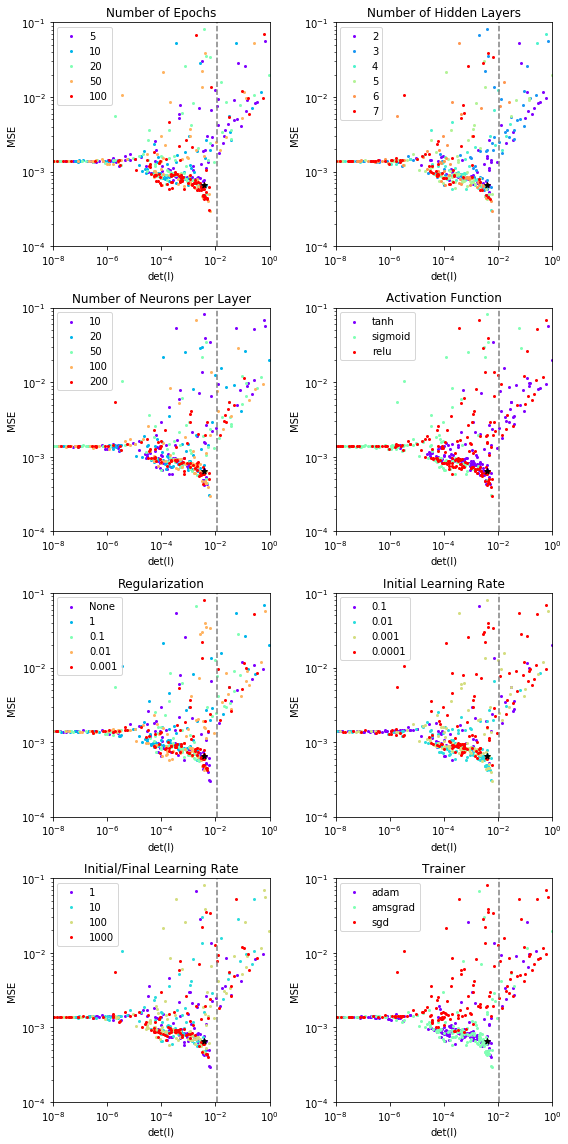

In [8]:
#######
#Truth FisherInfo
fi_truth , _= fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)
fidet_truth=np.linalg.det(fi_truth)

#######
#Input Data
data = np.load(usesummaryfile)

#######
#List Manipulation
def sublist(inputlist, index, condition):
    outputlist=[]
    for ilist in range(len(inputlist)):
        if inputlist[ilist,index]==condition:
            outputlist.append(inputlist[ilist])
    return np.array(outputlist)

#######
#Figure
myrangex=[10**(-8),1]
myrangey=[10**(-4),.1]
mysize=4
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2)
f.set_size_inches(8,16)

# choices_epochs
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_epochs)))
for i in range(len(choices_epochs)):
    thisdata=sublist(data,1,i)
    ax1.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_epochs[i]))
ax1.scatter(data[0,9], data[0,10],color='black',marker="*")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('det(I)')
ax1.set_ylabel('MSE')
ax1.set_xlim(myrangex)
ax1.set_ylim(myrangey)
ax1.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax1.set_title('Number of Epochs')
ax1.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nhidden
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nhidden)))
for i in range(len(choices_nhidden)):
    thisdata=sublist(data,2,i)
    ax2.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nhidden[i]))
ax2.scatter(data[0,9], data[0,10],color='black',marker="*")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('det(I)')
ax2.set_ylabel('MSE')
ax2.set_xlim(myrangex)
ax2.set_ylim(myrangey)
ax2.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax2.set_title('Number of Hidden Layers')
ax2.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_nneuron
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_nneuron)))
for i in range(len(choices_nneuron)):
    thisdata=sublist(data,3,i)
    ax3.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_nneuron[i]))
ax3.scatter(data[0,9], data[0,10],color='black',marker="*")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('det(I)')
ax3.set_ylabel('MSE')
ax3.set_xlim(myrangex)
ax3.set_ylim(myrangey)
ax3.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax3.set_title('Number of Neurons per Layer')
ax3.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_activation
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_activation)))
for i in range(len(choices_activation)):
    thisdata=sublist(data,4,i)
    ax4.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_activation[i]))
ax4.scatter(data[0,9], data[0,10],color='black',marker="*")
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_xlabel('det(I)')
ax4.set_ylabel('MSE')
ax4.set_xlim(myrangex)
ax4.set_ylim(myrangey)
ax4.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax4.set_title('Activation Function')
ax4.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_regularization
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_regularization)))
for i in range(len(choices_regularization)):
    thisdata=sublist(data,5,i)
    ax5.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_regularization[i]))
ax5.scatter(data[0,9], data[0,10],color='black',marker="*")
ax5.set_yscale('log')
ax5.set_xscale('log')
ax5.set_xlabel('det(I)')
ax5.set_ylabel('MSE')
ax5.set_xlim(myrangex)
ax5.set_ylim(myrangey)
ax5.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax5.set_title('Regularization')
ax5.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrinitial)))
for i in range(len(choices_lrinitial)):
    thisdata=sublist(data,6,i)
    ax6.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrinitial[i]))
ax6.scatter(data[0,9], data[0,10],color='black',marker="*")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_xlabel('det(I)')
ax6.set_ylabel('MSE')
ax6.set_xlim(myrangex)
ax6.set_ylim(myrangey)
ax6.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax6.set_title('Initial Learning Rate')
ax6.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_learning
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_lrratio)))
for i in range(len(choices_lrratio)):
    thisdata=sublist(data,7,i)
    ax7.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_lrratio[i]))
ax7.scatter(data[0,9], data[0,10],color='black',marker="*")
ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_xlabel('det(I)')
ax7.set_ylabel('MSE')
ax7.set_xlim(myrangex)
ax7.set_ylim(myrangey)
ax7.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax7.set_title('Initial/Final Learning Rate')
ax7.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

# choices_trainer
mycolors = cm.rainbow(np.linspace(0, 1, len(choices_trainer)))
for i in range(len(choices_trainer)):
    thisdata=sublist(data,8,i)
    ax8.scatter(thisdata[:,9], thisdata[:,10],color=mycolors[i],s=mysize,alpha=1,label=str(choices_trainer[i]))
ax8.scatter(data[0,9], data[0,10],color='black',marker="*")
ax8.set_yscale('log')
ax8.set_xscale('log')
ax8.set_xlabel('det(I)')
ax8.set_ylabel('MSE')
ax8.set_xlim(myrangex)
ax8.set_ylim(myrangey)
ax8.legend(bbox_to_anchor=(0.02, 0.98), loc=2, borderaxespad=0.)
ax8.set_title('Trainer')
ax8.plot([fidet_truth,fidet_truth], myrangey, linestyle="--", color='gray')

#######
#Plot
plt.tight_layout()
plt.show()

In [7]:
#Get list of good settings
data_sort = data[data[:,10].argsort()[::1]][:5,:]

for i in range(len(data_sort)):
    print ('Setting with det(I)=',data_sort[i,9],'and MSE=',data_sort[i,10], 'had settings')
    print (' - Number of Epochs:',choices_epochs[int(data_sort[i,1])])
    print (' - Number of Hidden Layers:',choices_nhidden[int(data_sort[i,2])])
    print (' - Number of Neurons per Layer:',choices_nneuron[int(data_sort[i,3])])
    print (' - Activation Function:',choices_activation[int(data_sort[i,4])])
    print (' - Regularization Parameter:',choices_regularization[int(data_sort[i,5])])
    print (' - Initial Learning Rate:',choices_lrinitial[int(data_sort[i,6])])
    print (' - Final Learning Rate:',choices_lrinitial[int(data_sort[i,6])]/choices_lrratio[int(data_sort[i,7])])
    print (' - Trainer:',choices_trainer[int(data_sort[i,8])])
    print ('')

Setting with det(I)= 0.006124970046511533 and MSE= 0.00029858027299227555 had settings
 - Number of Epochs: 50
 - Number of Hidden Layers: 6
 - Number of Neurons per Layer: 100
 - Activation Function: relu
 - Regularization Parameter: None
 - Initial Learning Rate: 0.001
 - Final Learning Rate: 0.001
 - Trainer: amsgrad

Setting with det(I)= 0.005621511274825701 and MSE= 0.00030686817197001187 had settings
 - Number of Epochs: 100
 - Number of Hidden Layers: 4
 - Number of Neurons per Layer: 20
 - Activation Function: sigmoid
 - Regularization Parameter: None
 - Initial Learning Rate: 0.01
 - Final Learning Rate: 0.01
 - Trainer: amsgrad

Setting with det(I)= 0.005344179647982832 and MSE= 0.00039887066552662 had settings
 - Number of Epochs: 50
 - Number of Hidden Layers: 6
 - Number of Neurons per Layer: 100
 - Activation Function: relu
 - Regularization Parameter: None
 - Initial Learning Rate: 0.001
 - Final Learning Rate: 1e-06
 - Trainer: adam

Setting with det(I)= 0.0038338774195